In [7]:
# ═════════════════════════════════════════════════════════════════════
# 0.  IMPORTS & PATHS
# ═════════════════════════════════════════════════════════════════════
import os, numpy as np, pandas as pd, geopandas as gpd
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio.warp import calculate_default_transform
from rasterio.transform import rowcol
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
import numpy as np

shp_dir   = r"C:\Users\ka34292\Desktop\Spatial Analyis\Shapefiles"
flood_dir = r"C:\Users\ka34292\Desktop\Spatial Analyis\FloodMaps"

parcels_fp  = os.path.join(shp_dir, "Parcel_with_Building_Area1.shp")
tracts_fp   = os.path.join(shp_dir, "Austin_tract_Merged1.shp")
district_fp = os.path.join(shp_dir, "Council_Districts.shp")

rasters = {
    10 : os.path.join(flood_dir, "n30w98_2020_0p50_P_1in10.tif"),
    100: os.path.join(flood_dir, "n30w98_2020_0p50_P_1in100.tif"),
    500: os.path.join(flood_dir, "n30w98_2020_0p50_P_1in500.tif"),
}

# ═════════════════════════════════════════════════════════════════════
# 1.  LOAD & REPROJECT SHAPEFILES
# ═════════════════════════════════════════════════════════════════════
target_crs = 2278  # NAD83 / Texas State Plane Texas S-Central (US ft)

parcels   = gpd.read_file(parcels_fp).to_crs(target_crs)
tracts    = gpd.read_file(tracts_fp).to_crs(target_crs)
districts = gpd.read_file(district_fp).to_crs(target_crs)

# attach Census tract GEOID to each parcel
parcels = gpd.sjoin(parcels,
                    tracts[["GEOID", "geometry"]],
                    how="left", predicate="within")



# ═════════════════════════════════════════════════════════════════════
# 2.  FILTER “ELIGIBLE” PARCELS  (500–10 000 ft² etc.)
# ═════════════════════════════════════════════════════════════════════
eligible = parcels[
    (parcels["P_Area"] >= 100) & 
    (parcels["P_Area"] <= 10000) &
    (parcels["B_Area"] >= 100) & 
    (parcels["B_Area"] <= 5000)&
    (parcels["B_Area"] <= parcels["P_Area"])
].copy()


In [8]:
import math
import numpy as np
import pandas as pd
import rasterio
import rasterio.enums
from rasterio.vrt import WarpedVRT
from rasterio.windows import Window
from rasterio.transform import rowcol, xy
from scipy.spatial import cKDTree

# ── PARAMETERS ─────────────────────────────────────────────────────────
res_ft           = 3                       # native 3 ft resolution
half_distance_ft = 50                      # decay half‐distance (ft)
alpha            = np.log(2) / half_distance_ft
aeps             = {10:0.10, 100:0.01, 500:0.002}
d_thresh         = 0.1                     # depth threshold (ft)
tile_ft          = 2000                    # tile size (ft)
tile_cells       = math.ceil(tile_ft / res_ft)
max_rad_ft       = 2000                    # max search radius (ft)
margin_cells     = math.ceil(max_rad_ft / res_ft)

# 1) figure out the full VRT grid
with rasterio.open(rasters[10]) as src0:
    with WarpedVRT(src0, crs=target_crs, resolution=res_ft) as vrt:
        width, height = vrt.width, vrt.height
        transform     = vrt.transform

# 2) assign parcels to tiles & store centroids
centroids = eligible.geometry.centroid
rowcols   = [rowcol(transform, pt.x, pt.y, op=np.floor) for pt in centroids]
tiles     = [(r // tile_cells, c // tile_cells) for r, c in rowcols]
eligible["tile"]        = tiles
eligible["centroid_xy"] = list(zip(centroids.x, centroids.y))

# 3) prepare an output Series indexed by parcel
fei_series = pd.Series(0.0, index=eligible.index)

# 4) loop over tiles, build one KD‐tree per tile & return period
for (tr, tc), sub in eligible.groupby("tile"):
    # define tile window + margin
    row_off = max(0, tr*tile_cells - margin_cells)
    col_off = max(0, tc*tile_cells - margin_cells)
    nrows   = min(height, (tr+1)*tile_cells + margin_cells) - row_off
    ncols   = min(width,  (tc+1)*tile_cells + margin_cells) - col_off
    win     = Window(col_off, row_off, ncols, nrows)

    for rp, aep in aeps.items():
        with rasterio.open(rasters[rp]) as src0:
            with WarpedVRT(src0,
                           crs=target_crs,
                           resolution=res_ft,
                           resampling=rasterio.enums.Resampling.nearest) as vrt:

                arr  = vrt.read(1, window=win, masked=True)
                mask = (arr > d_thresh) & np.isfinite(arr)
                if not mask.any():
                    continue

                # extract wet‐pixel coords & depths
                rows, cols     = np.nonzero(mask)
                rows_glob      = rows + row_off
                cols_glob      = cols + col_off
                xs, ys         = xy(vrt.transform, rows_glob, cols_glob, offset="center")
                coords         = np.vstack([xs, ys]).T
                depths         = arr.data[rows, cols]

                # KD‐tree for nearest‐pixel lookup
                tree = cKDTree(coords)

                # batch query all parcels in this tile
                pts = np.vstack(sub["centroid_xy"].tolist())
                dists, idxs_nn = tree.query(pts, k=1)
                dvals          = depths[idxs_nn]

                # compute & accumulate H = depth * exp(-α * dist)
                hazard = dvals * np.exp(-alpha * dists)
                fei_series.loc[sub.index] += aep * hazard

# 5) attach & robustly normalize (1st–99th percentile) ────────────────────
eligible["FEI_expand"] = fei_series
p1, p99               = np.percentile(fei_series, [2.5, 97.5])
eligible["FEI_rs"]    = np.clip((fei_series - p1)/(p99 - p1), 0, 1)


In [105]:
# ═════════════════════════════════════════════════════════════════════
# 4.  HOUSEHOLD-LEVEL BEHAVIOUR SCORES
# ═════════════════════════════════════════════════════════════════════

# ensure the original code still finds FEI_norm
eligible["FEI_norm"] = eligible["FEI_rs"]

# convert four % columns to numeric
for col in ["White%", "NonWht%", "NnAdvDg", "AdvDeg"]:
    tracts[col] = pd.to_numeric(tracts[col], errors="coerce")

tract_lookup = tracts.set_index("GEOID").to_dict("index")

def rain_pot(b):
    return 1.0 if b > 5000 else (0.5 if b <= 500
            else 0.5 + (b-500)/(5000-500)*0.5)

def struct_pot(p, b):
    rem = p - b
    return 1.0 if rem > 8000 else (0.5 if rem <= 1000
            else 0.5 + (rem-1000)/(8000-1000)*0.5)

hh_rows = []
for _, parc in eligible.iterrows():
    tr = tract_lookup.get(parc["GEOID"])  # skip if socio-data missing
    if tr is None:
        continue

    income = max(1e4, np.random.lognormal(tr["Incm_mn"], tr["Incm_sd"]))
    if income > 5e5:
        continue

    race = np.random.choice(
        ["White", "Non-White"],
        p=[tr["White%"]/100, tr["NonWht%"]/100]
    )
    adv = np.random.choice(
        ["Adv Degree", "No Adv Degree"],
        p=[tr["AdvDeg"]/100, tr["NnAdvDg"]/100]
    )

    def draw(col):
        mean, sd = tr[col].split("(")
        return np.random.normal(
            float(mean.strip()),
            float(sd.replace(")", "").strip())
        )

    pn, att, awr, sc = (draw(k) for k in ["p((SD))", "at((SD))", "aw((SD))", "s_((SD)"])

    structural = (
        1.51
        + (-0.45 if race == "Non-White" else 0)
        + (0.08 if income < 2e4 else (-0.17 if income < 5e4 else 0.15))
        + (-0.26 if adv == "No Adv Degree" else 0)
        + 0.37*pn + 0.23*sc - 0.02*att + 0.02*awr
    )

    rain = (
        0.39
        + (-0.18 if race == "Non-White" else 0)
        + (-0.05 if adv == "No Adv Degree" else 0)
        + (0.03 if income < 2e4 else (0.02 if income < 5e4 else 0.13))
        + 0.22*pn + 0.07*sc + 0.05*att - 0.02*awr
    )

    nonstr = (
        4.45
        + (-0.22 if race == "Non-White" else 0)
        + (0.11 if adv == "No Adv Degree" else 0)
        + (0.13 if income < 2e4 else (-0.21 if income < 5e4 else
           (-0.24 if income < 8e4 else 0)))
        + 0.51*pn + 0.11*sc + 0.03*att + 0.14*awr
    )

    hh_rows.append(dict(
        tract_id        = parc["GEOID"],
        structural_beh  = structural,
        rain_beh        = rain,
        nonstr_beh      = nonstr,
        FEI_norm        = parc["FEI_norm"],
        awareness       = awr,
        attitude        = att,
        personal_norms  = pn,
        social_capital  = sc,
        income          = income,
        race_bin        = 0 if race == "White" else 1,
        advdeg_bin      = 0 if adv == "Adv Degree" else 1,
    ))

hh_df = pd.DataFrame(hh_rows)

# ── normalise behaviour scores 0–1 ───────────────────────────────────
for col in ["structural_beh", "rain_beh", "nonstr_beh"]:
    vmin, vmax = hh_df[col].min(), hh_df[col].max()
    hh_df[f"{col}_norm"] = (hh_df[col] - vmin) / (vmax - vmin + 1e-9)

# ═════════════════════════════════════════════════════════════════════
# 5.  TRACT-LEVEL MEANS  (raw & normalised scores + latent vars)
# ═════════════════════════════════════════════════════════════════════
means = (
    hh_df.groupby("tract_id")
         .agg(
             structural_mean      = ("structural_beh",     "mean"),
             rain_mean            = ("rain_beh",           "mean"),
             nonstruct_mean       = ("nonstr_beh",         "mean"),
             structural_norm_mean = ("structural_beh_norm","mean"),
             rain_norm_mean       = ("rain_beh_norm",      "mean"),
             nonstruct_norm_mean  = ("nonstr_beh_norm",    "mean"),
             fei_norm_mean        = ("FEI_norm",           "mean"),
             aw_mean              = ("awareness",          "mean"),
             att_mean             = ("attitude",           "mean"),
             pn_mean              = ("personal_norms",     "mean"),
             sc_mean              = ("social_capital",     "mean"),
             inc_mean             = ("income",             "mean"),
             pct_nonwhite         = ("race_bin",           "mean"),
             pct_advdeg           = ("advdeg_bin",         "mean")
         )
         .reset_index()
)

tracts_plot = tracts.merge(
    means,
    left_on="GEOID",
    right_on="tract_id",
    how="left"
)


TypeError: unsupported operand type(s) for *: 'float' and 'function'

In [39]:
# ═════════════════════════════════════════════════════════════
# 4.  HOUSEHOLD-LEVEL BEHAVIOUR SCORES  (names aligned to base code)
# ═════════════════════════════════════════════════════════════

import numpy as np
import pandas as pd

# ------------------------------------------------------------------
# 1.  PREP: ensure required columns exist & are numeric
# ------------------------------------------------------------------

eligible["FEI_norm"] = eligible["FEI_rs"]  # preserve legacy reference

for col in ["White%", "NonWht%", "NnAdvDg", "AdvDeg"]:
    tracts[col] = pd.to_numeric(tracts[col], errors="coerce")

# tract-level socio-demographic lookup
tract_lookup = tracts.set_index("GEOID").to_dict("index")

# ------------------------------------------------------------------
#
# ------------------------------------------------------------------
# ------------------------------------------------------------------
# 2.  POTENTIAL FUNCTIONS  ⇢ fully parameterised & defensible
# ------------------------------------------------------------------
#   ☐  All areas are in square feet.
#   ☐  POT_FLOOR  = minimum score for a severely space-limited site.
#   ☐  *_MIN_*    = “cramped” breakpoint (start of the ramp).
#   ☐  *_MAX_*    = “ample space” breakpoint (end of the ramp).
#                   Above this point the score is capped at 1.0.
# ------------------------------------------------------------------

# --- PARAMETERS you can cite in the methods section ---------------
POT_FLOOR        = 0.1        # sites with almost no space still retain 35 % of baseline potential
RAIN_MIN_AREA    = 500         # ft² roof area where potential starts to rise
RAIN_MAX_AREA    = 200       # ft² roof area where rain potential saturates
YARD_MIN_AREA    = 1000        # ft² yard (pervious) area where potential starts to rise
YARD_MAX_AREA    = 5000       # ft² yard area where structural potential saturates

# --- helper: generic piece-wise linear scaler ---------------------
def _piecewise_linear(val, min_val, max_val,
                      floor=POT_FLOOR, cap=1.0):
    """Maps a physical metric to [floor, cap] with a linear ramp."""
    if val >= max_val:
        return cap
    if val <= min_val:
        return floor
    return floor + (val - min_val) / (max_val - min_val) * (cap - floor)

# --- rain-harvesting potential ------------------------------------
def rain_pot(building_ft2):
    """
    Potential index for rain barrels / cisterns.
    • 0–400 ft² roof → score = POT_FLOOR
    • 400–2 500 ft²  → linear ramp POT_FLOOR → 1.0
    • ≥2 500 ft² roof → score = 1.0
    """
    return _piecewise_linear(building_ft2, RAIN_MIN_AREA, RAIN_MAX_AREA)

# --- structural (infiltration) potential --------------------------
def struct_pot(parcel_ft2, building_ft2):
    """
    Potential index for rain gardens / bioswales.
    • yard = parcel – building
    • 0–500 ft² yard  → score = POT_FLOOR
    • 500–6 000 ft²   → linear ramp POT_FLOOR → 1.0
    • ≥6 000 ft² yard → score = 1.0
    """
    yard_ft2 = max(0, parcel_ft2 - building_ft2)
    return _piecewise_linear(yard_ft2, YARD_MIN_AREA, YARD_MAX_AREA)


# ------------------------------------------------------------------
# 3.  SYNTHETIC HOUSEHOLD GENERATION & BEHAVIOUR SCORES
# ------------------------------------------------------------------

hh_rows = []

for _, parc in eligible.iterrows():
    tr = tract_lookup.get(parc["GEOID"])
    if tr is None:
        continue  # tract socio-data missing

    # socio-economic draws -------------------------------------------------
    income = max(1e4, np.random.lognormal(tr["Incm_mn"], tr["Incm_sd"]))
    if income > 5e5:
        continue  # extreme outlier

    race = np.random.choice(
        ["White", "Non-White"],
        p=[tr["White%"] / 100, tr["NonWht%"] / 100],
    )
    adv = np.random.choice(
        ["Adv Degree", "No Adv Degree"],
        p=[tr["AdvDeg"] / 100, tr["NnAdvDg"] / 100],
    )

    # helper to draw latent vars from "mean(sd)" string -------------------
    def draw(col):
        mean_str, sd_str = tr[col].split("(")
        return np.random.normal(float(mean_str.strip()), float(sd_str.replace(")", "").strip()))

    pn, att, awr, sc = (draw(k) for k in ["p((SD))", "at((SD))", "aw((SD))", "s_((SD)"])

    p_area, b_area = parc["P_Area"], parc["B_Area"]

    # physical suitability factors ---------------------------------------
    rain_factor   = rain_pot(b_area)
    struct_factor = struct_pot(p_area, b_area)

    # behaviour score equations (raw × potential) ------------------------
    structural = (
        1.51
        + (-0.45 if race == "Non-White" else 0)
        + (0.08 if income < 2e4 else (-0.17 if income < 5e4 else 0.15))
        + (-0.26 if adv == "No Adv Degree" else 0)
        + 0.37 * pn + 0.23 * sc - 0.02 * att + 0.02 * awr
    ) * struct_factor

    rain = (
        0.39
        + (-0.18 if race == "Non-White" else 0)
        + (-0.05 if adv == "No Adv Degree" else 0)
        + (0.03 if income < 2e4 else (0.02 if income < 5e4 else 0.13))
        + 0.22 * pn + 0.07 * sc + 0.05 * att - 0.02 * awr
    ) * rain_factor

    nonstr = (
        4.45
        + (-0.22 if race == "Non-White" else 0)
        + (0.11 if adv == "No Adv Degree" else 0)
        + (0.13 if income < 2e4 else (-0.21 if income < 5e4 else (-0.24 if income < 8e4 else 0)))
        + 0.51 * pn + 0.11 * sc + 0.03 * att + 0.14 * awr
    )

    hh_rows.append(dict(
        tract_id       = parc["GEOID"],
        structural_beh = structural,
        rain_beh       = rain,
        nonstr_beh     = nonstr,
        FEI_norm       = parc["FEI_norm"],
        awareness      = awr,
        attitude       = att,
        personal_norms = pn,
        social_capital = sc,
        income         = income,
        race_bin       = 0 if race == "White" else 1,
        advdeg_bin     = 0 if adv == "Adv Degree" else 1,
    ))

hh_df = pd.DataFrame(hh_rows)

# ------------------------------------------------------------------
# 4.  NORMALISE BEHAVIOUR SCORES 0-1
# ------------------------------------------------------------------

for col in ["structural_beh", "rain_beh", "nonstr_beh"]:
    vmin, vmax = hh_df[col].min(), hh_df[col].max()
    hh_df[f"{col}_norm"] = (hh_df[col] - vmin) / (vmax - vmin + 1e-9)

# ------------------------------------------------------------------
# 5.  TRACT-LEVEL MEANS  (raw & normalised scores + latent vars)
# ------------------------------------------------------------------

means = (
    hh_df.groupby("tract_id")
         .agg(
             structural_mean      = ("structural_beh",     "mean"),
             rain_mean            = ("rain_beh",           "mean"),
             nonstr_mean          = ("nonstr_beh",         "mean"),
             structural_norm_mean = ("structural_beh_norm","mean"),
             rain_norm_mean       = ("rain_beh_norm",      "mean"),
             nonstr_norm_mean     = ("nonstr_beh_norm",    "mean"),
             fei_norm_mean        = ("FEI_norm",           "mean"),
             aw_mean              = ("awareness",          "mean"),
             att_mean             = ("attitude",           "mean"),
             pn_mean              = ("personal_norms",     "mean"),
             sc_mean              = ("social_capital",     "mean"),
             inc_mean             = ("income",             "mean"),
             pct_nonwhite         = ("race_bin",           "mean"),
             pct_advdeg           = ("advdeg_bin",         "mean")
         )
         .reset_index()
)

tracts_plot = tracts.merge(
    means,
    left_on="GEOID",
    right_on="tract_id",
    how="left"
)


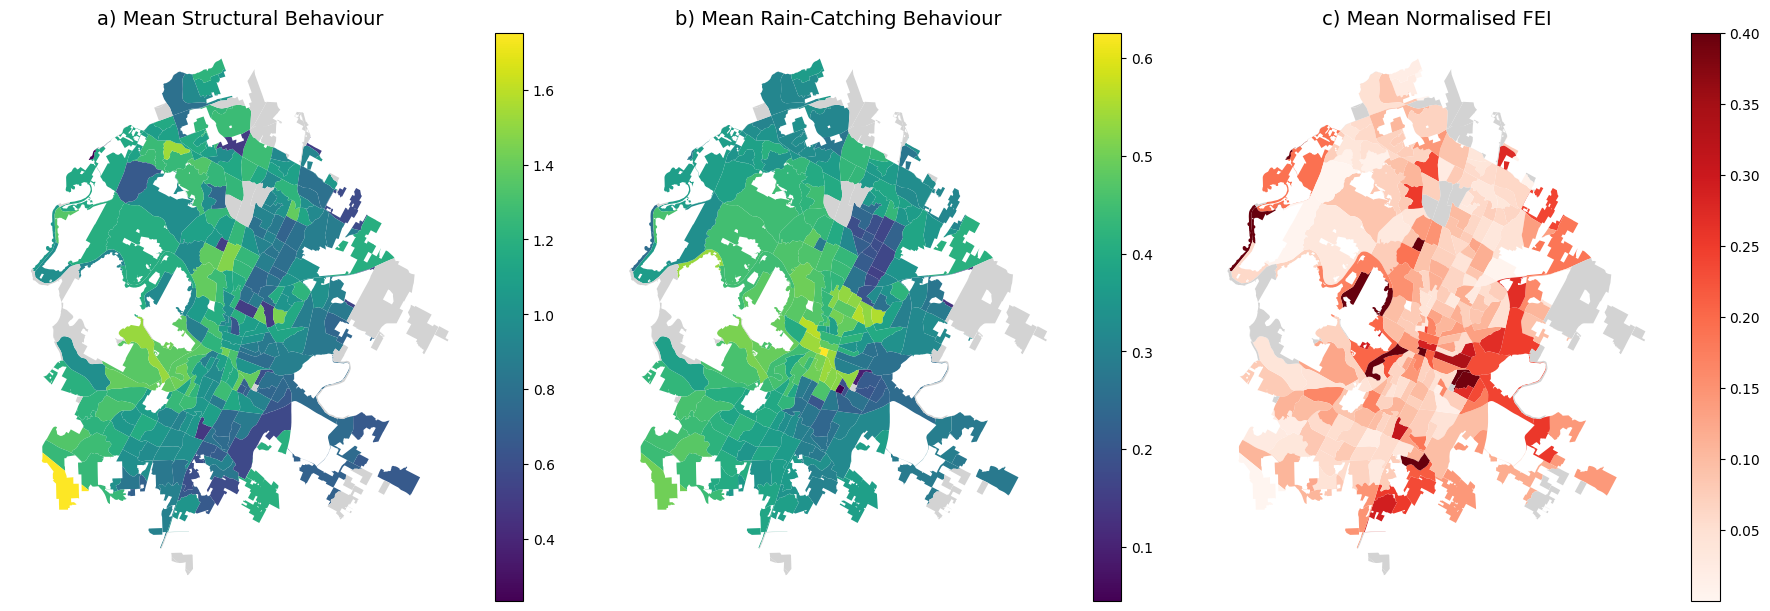

In [42]:
import matplotlib.pyplot as plt
import string
import numpy as np

# Clip FEI values at 0.5 so that everything above appears in the same color
tracts_plot["fei_clipped"] = tracts_plot["fei_norm_mean"].clip(upper=0.5)

# define panels: (column_name, title)
panels = [
    ("structural_mean", "Mean Structural Behaviour"),
    ("rain_mean",      "Mean Rain-Catching Behaviour"),
    ("fei_clipped",    "Mean Normalised FEI"),
]

# create 1×3 layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for idx, (col, ttl) in enumerate(panels, start=1):
    ax = axes[idx - 1]
    
    # red palette only for FEI (use vmax=0.5 to fix upper bound of color scale)
    if col == "fei_clipped":
        tracts_plot.plot(
            column=col,
            cmap="Reds",
            legend=True,
            ax=ax,
            vmax=0.4,
            missing_kwds=dict(color="lightgrey", label="No data")
        )
    else:
        tracts_plot.plot(
            column=col,
            legend=True,
            #vmin=0.3,
            #vmax=0.7,
            ax=ax,
            missing_kwds=dict(color="lightgrey", label="No data")
        )
    
    # add panel numbering a), b), c)
    letter = string.ascii_lowercase[idx - 1]
    ax.set_title(f"{letter}) {ttl}", fontsize=14)
    ax.axis("off")

plt.show()


In [43]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 1: Analysis
#   • Build spatial weights
#   • Prepare panel_vars
#   • Compute Local Moran’s I (Moran_Local) for each variable
#   • Compute co‐location join‐count significance arrays
#   • Build summary table DataFrame
# ──────────────────────────────────────────────────────────────────────────────

from libpysal.weights import Queen
from esda import Moran_Local
import numpy as np
import pandas as pd
from math import ceil

# 7. BUILD SPATIAL WEIGHTS (queen contiguity, row‐standardised)
tracts_plot = tracts_plot[tracts_plot.geometry.notna()].copy()
w = Queen.from_dataframe(tracts_plot, idVariable="GEOID")
w.transform = "r"  # row‐standardise
print("Weights created — # neighbours mean:", 
      np.mean(list(map(len, w.neighbors.values()))))

# 8.1 FIXED LIST OF VARIABLES (keep only those present)
panel_vars = {
    "fei_norm_mean"  : "FEI",
    "structural_mean": "Structural\nBehaviour",
    "rain_mean"      : "Rain‐catch\nBehaviour",
    "aw_mean"        : "Awareness",
    "att_mean"       : "Attitude",
    "pn_mean"        : "Personal\nNorms",
    "sc_mean"        : "Social\nCapital",
    "inc_mean"       : "Mean\nIncome",
    "pct_nonwhite"   : "% Non‐white",
    "pct_advdeg"     : "% Adv Degree",
}
panel_vars = {k: v for k, v in panel_vars.items() if k in tracts_plot.columns}
panel_vars = {
    k: panel_vars[k]
    for k in (["fei_norm_mean"] + [c for c in panel_vars if c != "fei_norm_mean"])
}

# IDs and permutation setup
ids, rng, permuts = w.id_order, np.random.default_rng(23), 999
ref_var = "fei_norm_mean"

# 8.2 COMPUTE LISA (Moran_Local) FOR EACH VARIABLE
lisa_results = {
    var: Moran_Local(tracts_plot[var].fillna(0), w)
    for var in panel_vars
}

# 8.3 COMPUTE CO‐LOCATION SIGNIFICANCE ARRAYS
y_high = (
    (tracts_plot.set_index("GEOID")[ref_var] > tracts_plot[ref_var].median())
    .astype(int)
    .reindex(ids)
)
coloc_sig = {}

for var in panel_vars:
    if var == ref_var:
        continue

    # binary high/low for comparison var
    z_high = (
        (tracts_plot.set_index("GEOID")[var] > tracts_plot[var].median())
        .astype(int)
        .reindex(ids)
    )

    # observed join-count
    obs = np.array([
        y_high[i] * z_high.loc[w.neighbors[i]].sum()
        for i in ids
    ])

    # permutation distribution
    perm = np.zeros((permuts, len(ids)), dtype=int)
    z_vals = z_high.values
    for p in range(permuts):
        zp = rng.permutation(z_vals)
        zp_s = pd.Series(zp, index=ids)
        perm[p] = [
            y_high[i] * zp_s.loc[w.neighbors[i]].sum()
            for i in ids
        ]

    pvals = ((perm >= obs).sum(axis=0) + 1) / (permuts + 1)

    # encode significance levels
    sig = np.zeros(len(ids), int)
    sig[(pvals <= .05) & (pvals > .01)]  = 1
    sig[(pvals <= .01) & (pvals > .001)] = 2
    sig[(pvals <= .001)]                = 3

    coloc_sig[var] = sig

# 9. BUILD SIGNIFICANCE TABLE (FEI-high ∩ other-high)
ref_ser  = tracts_plot.set_index("GEOID")[ref_var]
ref_high = (ref_ser > ref_ser.median()).astype(int)

rows = []
for var, label in panel_vars.items():
    if var == ref_var:
        continue

    cmp_ser  = tracts_plot.set_index("GEOID")[var]
    cmp_high = (cmp_ser > cmp_ser.median()).astype(int)

    # observed join-count per tract
    obs = {
        gid: ref_high.loc[gid] * cmp_high.loc[w.neighbors[gid]].sum()
        for gid in ids
    }

    # permutations
    greater = {gid: 0 for gid in ids}
    cmp_vals = cmp_high.loc[ids].values
    for _ in range(permuts):
        perm_s = pd.Series(np.random.permutation(cmp_vals), index=ids)
        for gid in ids:
            jc = ref_high.loc[gid] * perm_s.loc[w.neighbors[gid]].sum()
            if jc >= obs[gid]:
                greater[gid] += 1

    pseudo_p = {gid: (greater[gid] + 1) / (permuts + 1) for gid in ids}
    sig_n    = sum(1 for gid in ids if pseudo_p[gid] < 0.05)
    tot_n    = len(ids)

    rows.append({
        "Binary_variable_measures": f"FEI‐high & {label}‐high",
        "Significant_tracts"      : sig_n,
        "Insignificant_tracts"    : tot_n - sig_n,
        "Total"                   : tot_n
    })

tbl_coloc = pd.DataFrame(rows)


C:\Users\ka34292\AppData\Local\Temp\ipykernel_27880\2280175227.py:18: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w = Queen.from_dataframe(tracts_plot, idVariable="GEOID")


Weights created — # neighbours mean: 5.902985074626866


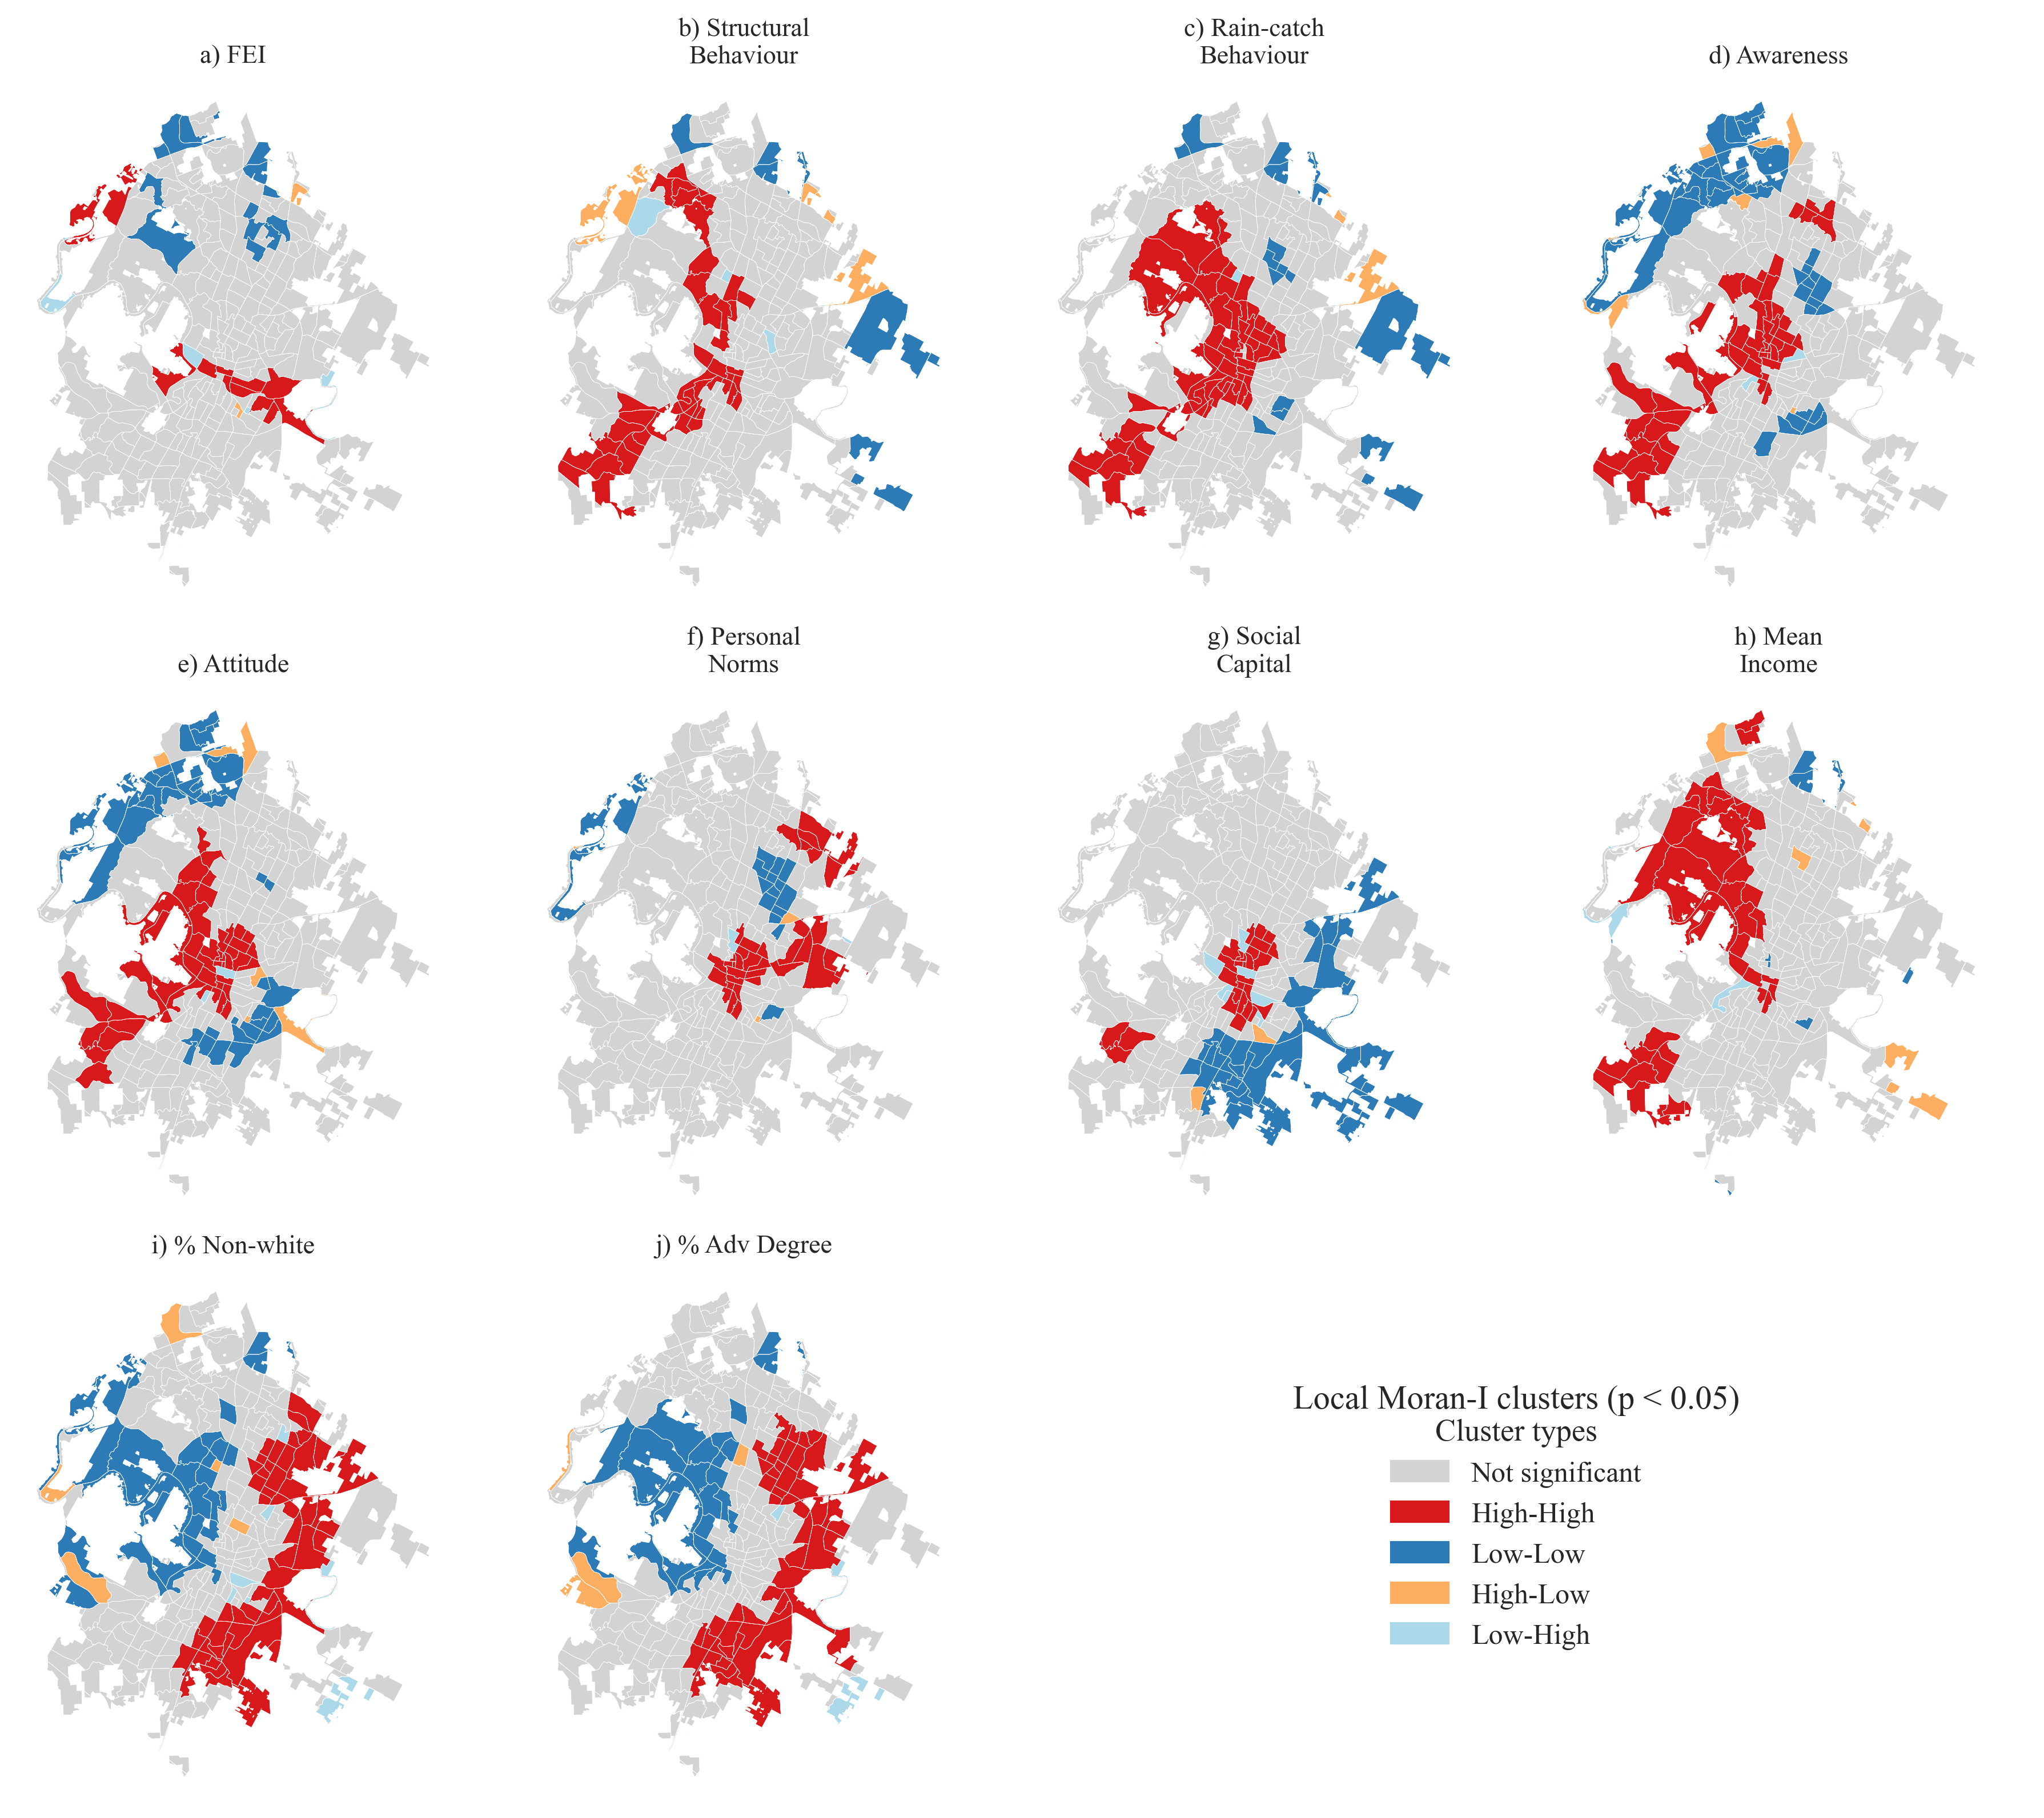

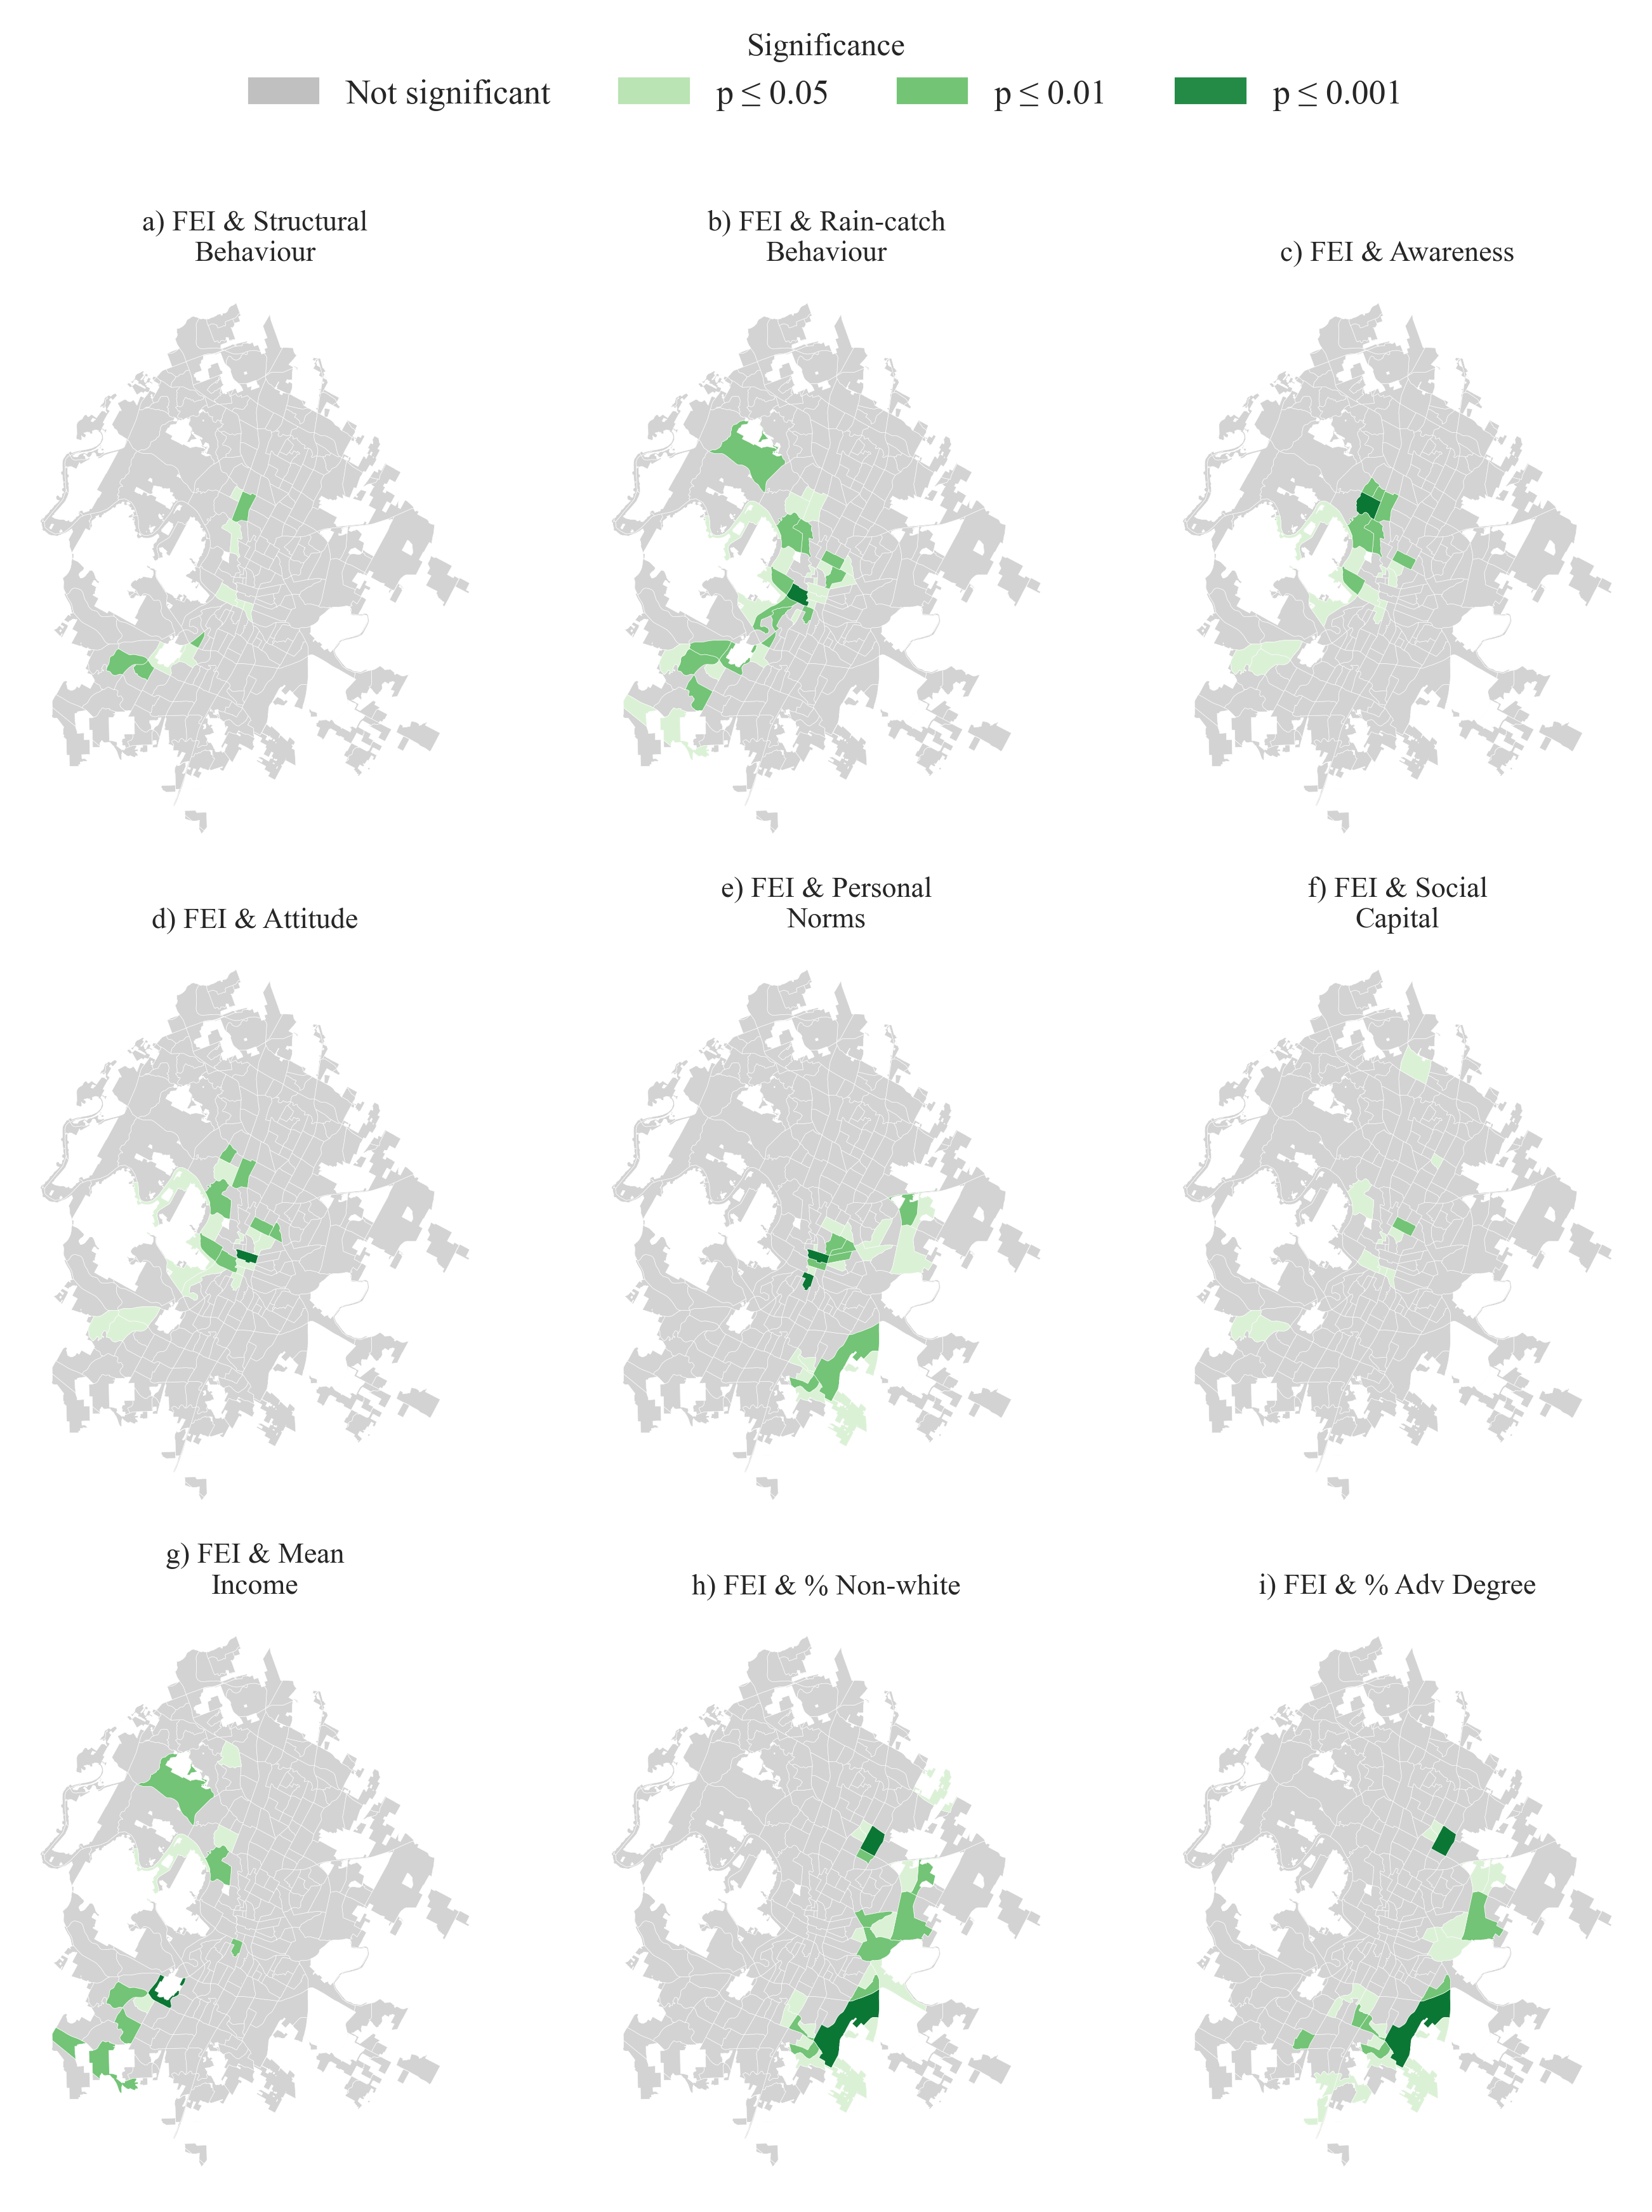


— Appendix IV · Co-location join-count significance —


In [71]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 2: Figures & Table Display (with merged legend slot & numbering)
# ──────────────────────────────────────────────────────────────────────────────

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from splot.esda import lisa_cluster
from math import ceil
import string

edge_col, edge_w = "white", .15

# ──────────────────────────────────────────────────────────────────────────────
# Figure 1: Local Moran’s I clusters in a 3×4 grid,
#   with panels numbered a)–j), and a merged legend/title in slots 11–12
# ──────────────────────────────────────────────────────────────────────────────

n = len(panel_vars)       # should be 10
fig1 = plt.figure(figsize=(3*4, 3.5*3), constrained_layout=True)

# create the 10 small maps
for idx, (col, lbl) in enumerate(panel_vars.items(), start=1):
    ax = fig1.add_subplot(3, 4, idx)
    lisa_cluster(lisa_results[col], tracts_plot, p=0.05, ax=ax, legend=False)
    tracts_plot.boundary.plot(ax=ax, edgecolor=edge_col, linewidth=edge_w)
    letter = string.ascii_lowercase[idx-1]
    ax.set_title(f"{letter}) {lbl}", fontsize=11)
    ax.set_axis_off()

# merged axis for slots 11 & 12
ax_leg = fig1.add_subplot(3, 4, (11, 12))
ax_leg.axis("off")

# title above legend
ax_leg.text(
    0.5, 0.75,
    "Local Moran-I clusters (p < 0.05)",
    ha="center", va="center",
    fontsize=14
)

# bigger legend in the middle
ax_leg.legend(
    handles=[
        mpatches.Patch(color="lightgrey", label="Not significant"),
        mpatches.Patch(color="#d7191c",   label="High-High"),
        mpatches.Patch(color="#2c7bb6",   label="Low-Low"),
        mpatches.Patch(color="#fdae61",   label="High-Low"),
        mpatches.Patch(color="#abd9e9",   label="Low-High"),
    ],
    loc="center",
    ncol=1,
    frameon=False,
    fontsize=12,
    title="Cluster types",
    title_fontsize=13
)

plt.show()


# ──────────────────────────────────────────────────────────────────────────────
# Figure 2: Co-location join-count maps in a 3×3 grid,
#   numbered a)–i), with legend & title placed a bit higher
# ──────────────────────────────────────────────────────────────────────────────

vars2 = [(col, panel_vars[col]) for col in panel_vars if col != ref_var]
fig2, axes2 = plt.subplots(3, 3,
                           figsize=(3*3, 3.5*3),
                           constrained_layout=True)

for ax, ((col, lbl), letter) in zip(axes2.flatten(), zip(vars2, string.ascii_lowercase)):
    # attach precomputed significance
    tracts_plot["sig_tmp"] = coloc_sig[col]

    tracts_plot.plot(ax=ax,
                     color="lightgrey",
                     edgecolor=edge_col,
                     linewidth=edge_w)
    tracts_plot[tracts_plot.sig_tmp > 0].plot(
        column="sig_tmp", ax=ax, cmap="Greens",
        vmin=0.5, vmax=3.5,
        edgecolor=edge_col,
        linewidth=edge_w,
        legend=False
    )
    ax.set_title(f"{letter}) FEI & {lbl}", fontsize=11)
    ax.set_axis_off()

# remove the temporary column
tracts_plot.drop(columns="sig_tmp", inplace=True, errors="ignore")

# place shared legend horizontally
fig2.legend(
    handles=[
        mpatches.Patch(color="silver",        label="Not significant"),
        mpatches.Patch(color="#bae4b3",       label="p ≤ 0.05"),
        mpatches.Patch(color="#74c476",       label="p ≤ 0.01"),
        mpatches.Patch(color="#238b45",       label="p ≤ 0.001"),
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),
    ncol=4,
    frameon=False,
    fontsize=13,
    title="Significance"
)



plt.show()


# ──────────────────────────────────────────────────────────────────────────────
# Finally, display the significance table
# ──────────────────────────────────────────────────────────────────────────────
print("\n— Appendix IV · Co-location join-count significance —")
display(tbl_coloc.style.hide(axis="index"))


In [72]:
# Save Moran’s I cluster figure
fig1.savefig('figure1_lisa_clusters.png', dpi=1000, bbox_inches='tight')

# Save co-location join-count figure
fig2.savefig('figure2_colocation_joincount.png', dpi=1000, bbox_inches='tight')

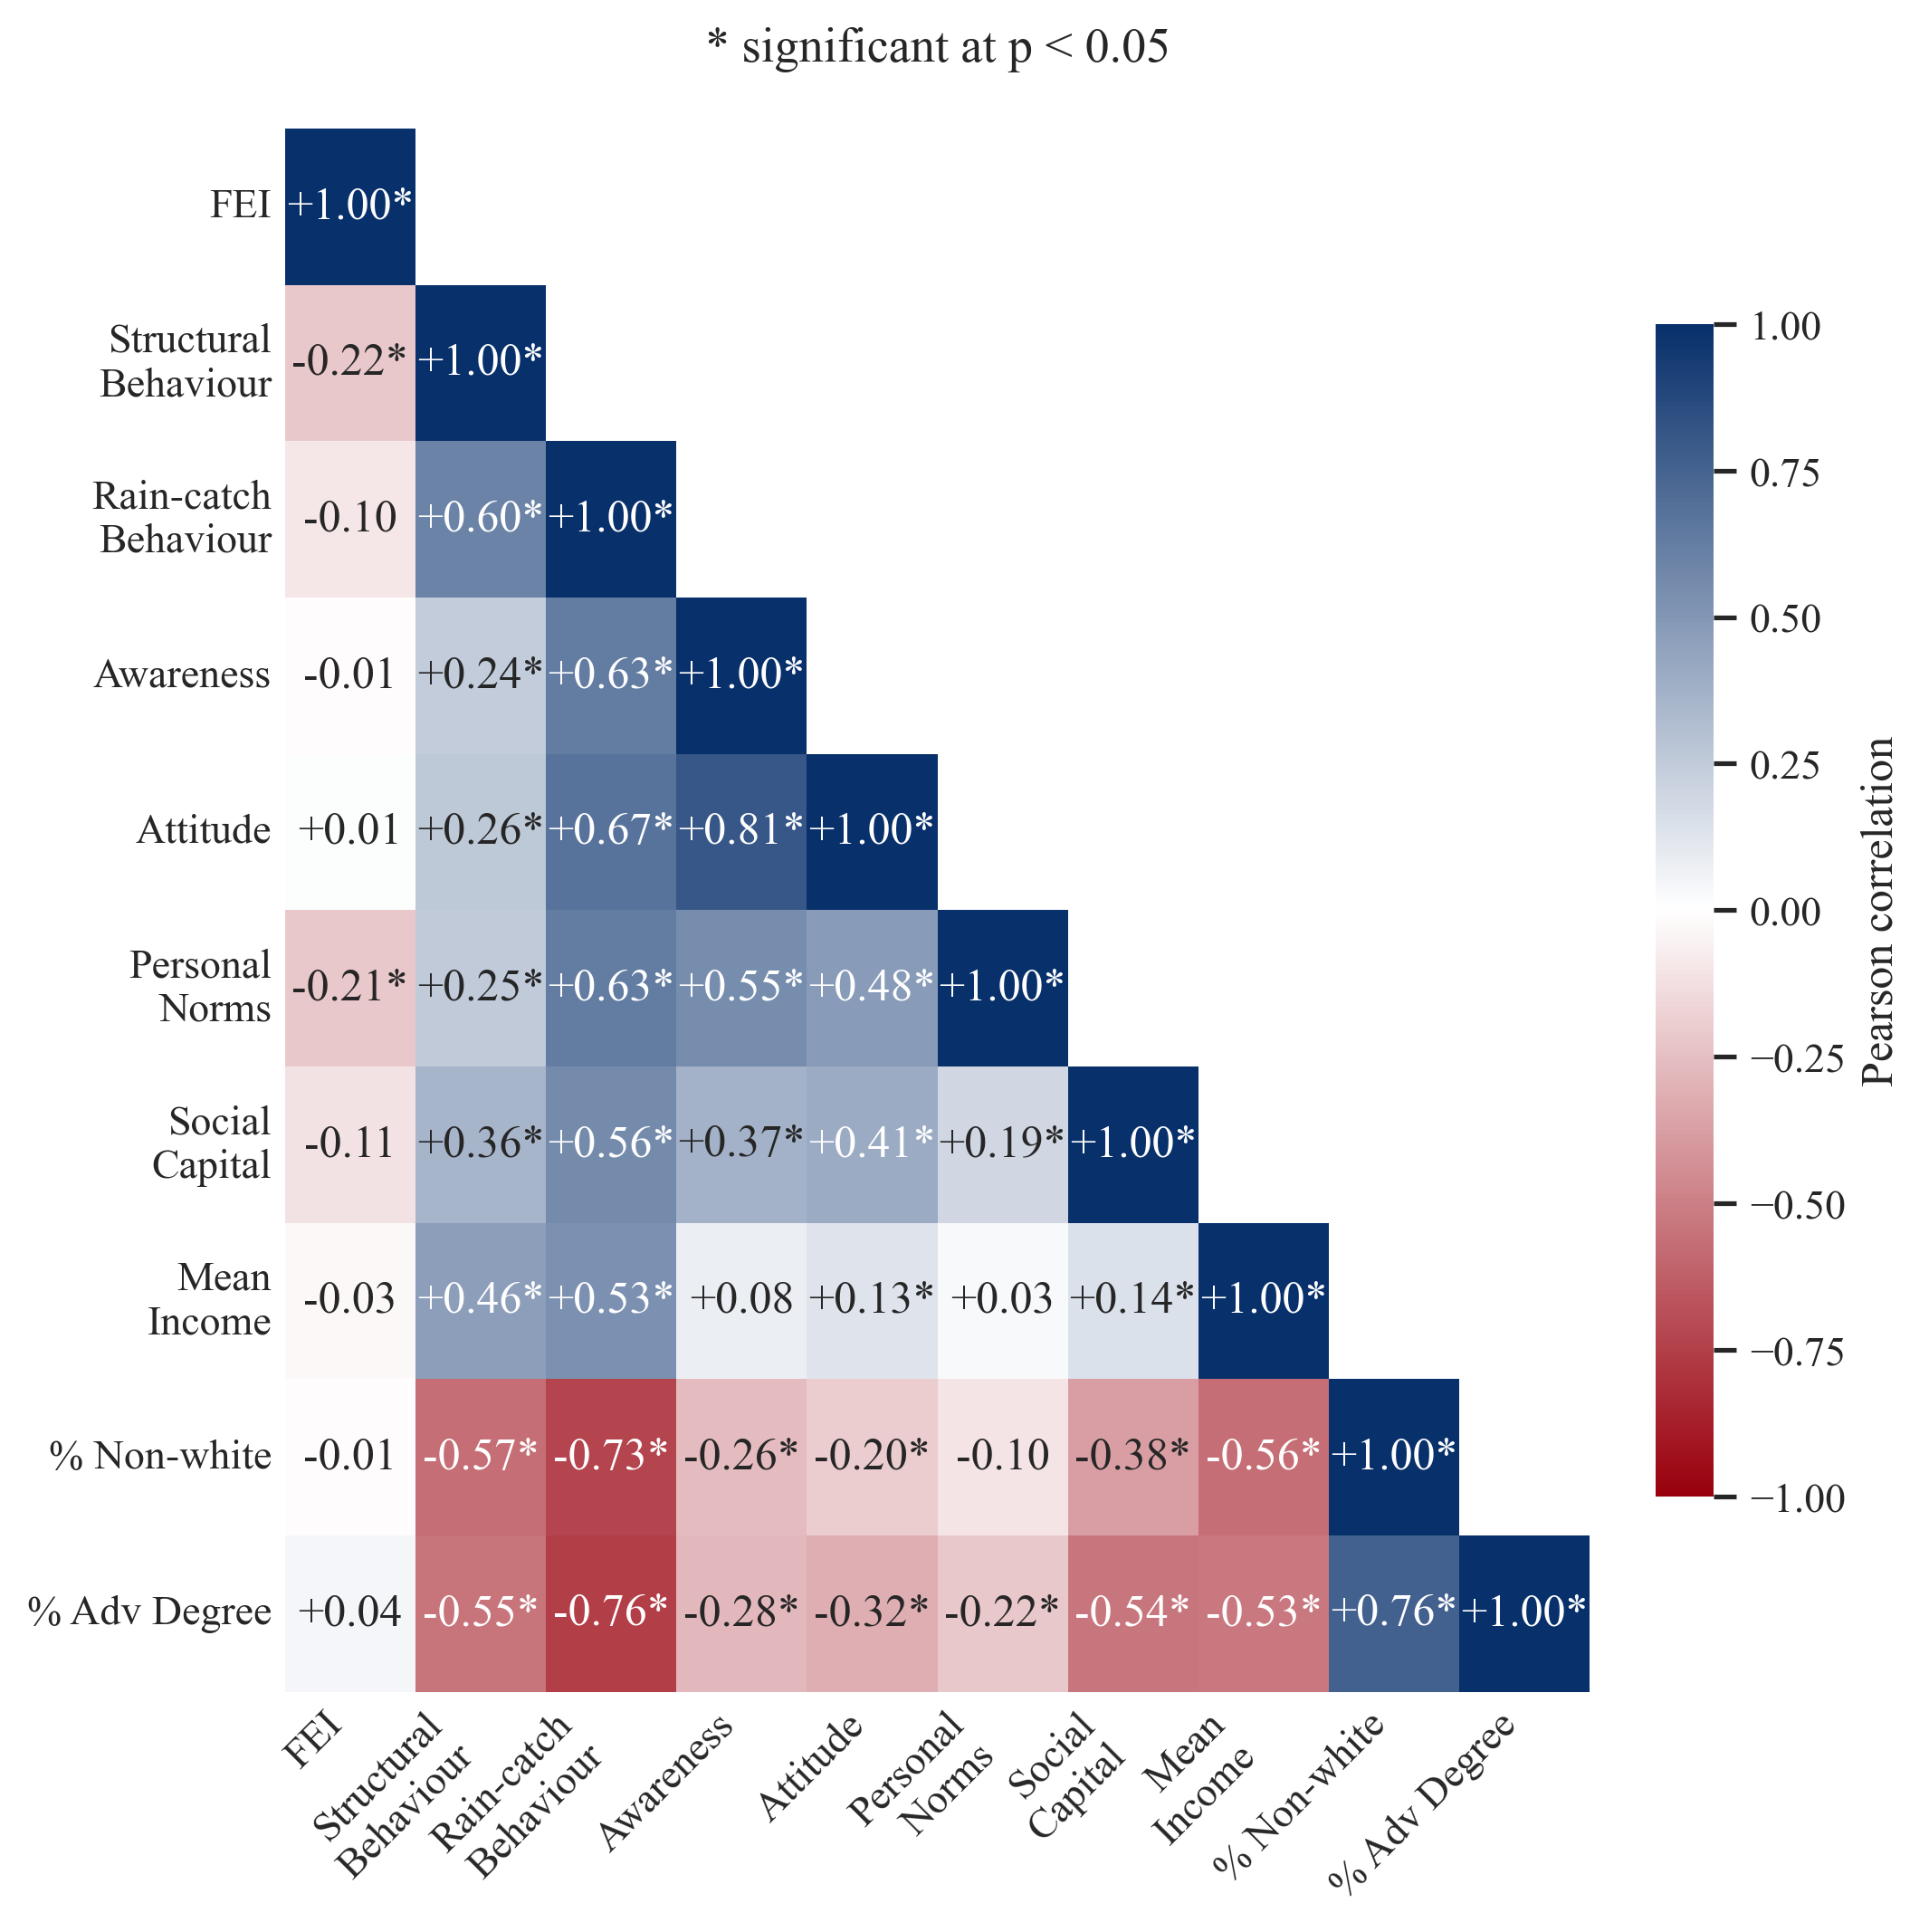

In [63]:
# ═════════════════════════════════════════════════════════════════════
#  Pair-wise Pearson-correlation heat-map  –  custom palette & styling
# ═════════════════════════════════════════════════════════════════════
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import pearsonr
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams["font.family"] = "Times New Roman"   # global font

def _scalar(x):
    """Return a Python float from scalar / 0-D / length-1 array."""
    arr = np.asarray(x)
    return float(arr.ravel()[0]) if arr.size else np.nan

# --------------------------------------------------------------------
# 1.  variables & labels
# --------------------------------------------------------------------
var_labels = {
    "fei_norm_mean"  : "FEI",
    "structural_mean": "Structural\nBehaviour",
    "rain_mean"      : "Rain-catch\nBehaviour",
    "aw_mean"        : "Awareness",
    "att_mean"       : "Attitude",
    "pn_mean"        : "Personal\nNorms",
    "sc_mean"        : "Social\nCapital",
    "inc_mean"       : "Mean\nIncome",
    "pct_nonwhite"   : "% Non-white",
    "pct_advdeg"     : "% Adv Degree",
}

present = {k: v for k, v in var_labels.items() if k in tracts_plot.columns}

usable, skipped = {}, []
for col, lbl in present.items():
    s = tracts_plot[col]
    if s.notna().sum() >= 3 and s.dropna().nunique() > 1:
        usable[col] = lbl
    else:
        skipped.append(lbl)
if len(usable) < 2:
    raise ValueError("Need at least two usable variables.")

cols, labels = list(usable.keys()), list(usable.values())
n = len(cols)

# --------------------------------------------------------------------
# 2.  r & p matrices
# --------------------------------------------------------------------
r = np.full((n, n), np.nan)
p = np.full_like(r, np.nan)

for i, ci in enumerate(cols):
    for j, cj in enumerate(cols[:i+1]):                 # j ≤ i  (lower + diag)
        pair = tracts_plot[[ci, cj]].dropna()
        if len(pair) >= 3:
            res = pearsonr(pair[ci], pair[cj])
            r_ = _scalar(getattr(res, "statistic", res[0]))
            p_ = _scalar(getattr(res, "pvalue",    res[1]))
            r[i, j], p[i, j] = r_, p_

r_df = pd.DataFrame(r, index=labels, columns=labels)
p_df = pd.DataFrame(p, index=labels, columns=labels)

# --------------------------------------------------------------------
# 3.  annotation (“+0.58*”)
# --------------------------------------------------------------------
annot = r_df.copy().astype(str)
for i in range(n):
    for j in range(i+1):
        if np.isnan(r_df.iat[i, j]):
            annot.iat[i, j] = ""
        else:
            star = "*" if p_df.iat[i, j] < 0.05 else ""
            annot.iat[i, j] = f"{r_df.iat[i, j]:+.2f}{star}"

# --------------------------------------------------------------------
# 4.  custom red-white-blue palette  (-1 = red,  1 = blue)
# --------------------------------------------------------------------
cmap_rwb = LinearSegmentedColormap.from_list(
    "rwb",
    [(0.00, "#99000D"),      # deep red
     (0.50, "#FFFFFF"),      # white
     (1.00, "#08306B")],     # deep blue
    N=256
)

# mask upper triangle **above** the diagonal (diag visible)
mask = np.triu(np.ones_like(r_df, dtype=bool), k=1)

# --------------------------------------------------------------------
# 5.  plot with minimal grid & spines removed
# --------------------------------------------------------------------
fig, ax = plt.subplots(
    figsize=(0.5*n + 2, 0.5*n + 2),
    constrained_layout=True
)

sns.heatmap(
    r_df,
    mask=mask,
    annot=annot,
    fmt="",
    cmap=cmap_rwb,
    vmin=-1, vmax=1, center=0,
    linewidths=0,   # remove cell borders
    cbar_kws=dict(label="Pearson correlation", shrink=0.75),
    annot_kws={"fontsize": 12, "fontfamily": "Times New Roman"},
    ax=ax
)

# rotate tick labels and set their font sizes
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)

# hide all spines
for spine in ax.spines.values():
    spine.set_visible(False)

# remove tick marks
ax.tick_params(length=0)

# title
ax.set_title("* significant at p < 0.05", pad=18, fontsize=13)

plt.show()


In [46]:
# ═════════════════════════════════════════════════════════════════════
#  Global Moran’s I table  (10 tract-level variables, 999 permutations)
#  – run AFTER `tracts_plot` and spatial weights object `w` exist
# ═════════════════════════════════════════════════════════════════════
import pandas as pd
from esda import Moran

# 1.  variables (same order as in the LISA panels)
gmi_vars = [
    ("fei_norm_mean",  "FEI"),
    ("structural_mean","Structural Behaviour"),
    ("rain_mean",      "Rain-catch Behaviour"),
    ("aw_mean",        "Awareness"),
    ("att_mean",       "Attitude"),
    ("pn_mean",        "Personal Norms"),
    ("sc_mean",        "Social Capital"),
    ("inc_mean",       "Mean Income"),
    ("pct_nonwhite",   "% Non-white"),
    ("pct_advdeg",     "% Adv Degree"),
]

rows = []
for col, label in gmi_vars:
    if col not in tracts_plot.columns:
        continue                          # skip if missing
    vec = tracts_plot[col].fillna(0).values
    mor = Moran(vec, w, permutations=999)

    # permutation mean of simulated I values
    perm_mean = float(mor.sim.mean()) if hasattr(mor, "sim") else None

    rows.append(dict(
        Variable        = label,
        Moran_I         = f"{mor.I: .4f}",
        E_I             = f"{mor.EI: .4f}",
        Perm_Mean       = f"{perm_mean: .4f}" if perm_mean is not None else "—",
        Z_value         = f"{mor.z_sim: .4f}",          # permutation z
        Permutations    = 999,
        Pseudo_p_value  = f"{mor.p_sim: .3f}",
    ))

gmi_table = pd.DataFrame(rows)

# 2.  pretty print
print("\nGlobal Moran-I (999 permutations)\n")
display(gmi_table.style
        .set_table_styles([dict(selector="th", props=[("font-weight","bold")])])
        .hide(axis="index"))



Global Moran-I (999 permutations)



In [47]:
# ═════════════════════════════════════════════════════════════════════
#  Appendix-style summary tables
#     ▸ Descriptive statistics
#     ▸ Local Moran-I cluster counts
#     ▸ Co-location join-count significance (FEI-high ∩ other-high)
#  (run after `tracts_plot` and weights `w` exist)
# ═════════════════════════════════════════════════════════════════════
import numpy as np, pandas as pd
from esda import Moran_Local
from scipy.stats import pearsonr           # only for N>1 check

# --------------------------------------------------------------------
# A. variable list & pretty labels
# --------------------------------------------------------------------
var_map = {
    "fei_norm_mean"  : "FEI",
    "structural_mean": "Structural Behaviour",
    "rain_mean"      : "Rain-catch Behaviour",
    "aw_mean"        : "Awareness",
    "att_mean"       : "Attitude",
    "pn_mean"        : "Personal Norms",
    "sc_mean"        : "Social Capital",
    "inc_mean"       : "Mean Income",
    "pct_nonwhite"   : "% Non-white",
    "pct_advdeg"     : "% Adv Degree",
}
vars_present = [c for c in var_map if c in tracts_plot.columns]
labels       = [var_map[c] for c in vars_present]
n_t          = len(tracts_plot)            # number of tracts

# helper to make nice numeric strings -------------------------------------------------
fmt = lambda x: f"{x:,.3f}" if isinstance(x,(float,np.floating)) else f"{x:,}"

# ====================================================================
# 1.  Descriptive statistics table  (mean, sd, min, max, N)
# ====================================================================
desc_rows = []
for col, lab in zip(vars_present, labels):
    s = tracts_plot[col].dropna()
    desc_rows.append(dict(
        Variable      = lab,
        Observations  = len(s),
        Mean          = fmt(s.mean()),
        Std_Dev       = fmt(s.std()),
        Min           = fmt(s.min()),
        Max           = fmt(s.max()),
    ))
tbl_desc = pd.DataFrame(desc_rows)
print("\n— Descriptive statistics —")
display(tbl_desc.style.hide(axis='index'))

# ====================================================================
# 2.  Local Moran-I cluster counts table
# ====================================================================
cluster_rows = []
for col, lab in zip(vars_present, labels):
    lisa = Moran_Local(tracts_plot[col].fillna(0).values, w, permutations=999)
    quad = lisa.q                      # 1=HH, 2=LH, 3=LL, 4=HL
    sig  = lisa.p_sim < 0.05
    counts = {
        "Not significant" : int((~sig).sum()),
        "High-high"       : int((sig & (quad==1)).sum()),
        "Low-low"         : int((sig & (quad==3)).sum()),
        "Low-high"        : int((sig & (quad==2)).sum()),
        "High-low"        : int((sig & (quad==4)).sum()),
        "Total"           : n_t
    }
    counts["Variable"] = lab
    cluster_rows.append(counts)

tbl_lisa = pd.DataFrame(cluster_rows)[
    ["Variable","Not significant","High-high","Low-low",
     "Low-high","High-low","Total"]
]
print("\n— Local Moran-I cluster counts (p < 0.05) —")
display(tbl_lisa.style.hide(axis='index'))




— Descriptive statistics —



— Local Moran-I cluster counts (p < 0.05) —


In [ ]:
# ═════════════════════════════════════════════════════════════════════
# 7.  BUILD SPATIAL WEIGHTS  (queen contiguity, row-standardised)
#     run this after `tracts_plot` exists and BEFORE the LISA cell
# ═════════════════════════════════════════════════════════════════════
from libpysal.weights import Queen

# drop geometries that are missing (optional safety)
tracts_plot = tracts_plot[tracts_plot.geometry.notna()].copy()

w = Queen.from_dataframe(tracts_plot, idVariable="GEOID")
w.transform = "r"          # row-standardise
print("Weights created — # neighbours mean:", np.mean(list(map(len, w.neighbors.values()))))

# ═════════════════════════════════════════════════════════════════════
# 8.  UNIVARIATE LISA  &  CO-LOCATION JOIN-COUNT GRIDS  (10 variables)
# ═════════════════════════════════════════════════════════════════════
from math import ceil
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from esda import Moran_Local
from splot.esda import lisa_cluster
import matplotlib.patches as mpatches

# --------------------------------------------------------------------
# 8.1  FIXED LIST OF VARIABLES (keep only those present)
# --------------------------------------------------------------------
panel_vars = {
    "fei_norm_mean"  : "FEI",
    "structural_mean": "Structural\nBehaviour",
    "rain_mean"      : "Rain-catch\nBehaviour",
    "aw_mean"        : "Awareness",
    "att_mean"       : "Attitude",
    "pn_mean"        : "Personal\nNorms",
    "sc_mean"        : "Social\nCapital",
    "inc_mean"       : "Mean\nIncome",
    "pct_nonwhite"   : "% Non-white",
    "pct_advdeg"     : "% Adv Degree",
}

panel_vars = {k: v for k, v in panel_vars.items() if k in tracts_plot.columns}

# always place FEI first
panel_vars = {k: panel_vars[k] for k in
              (["fei_norm_mean"] + [c for c in panel_vars if c != "fei_norm_mean"])}

n                = len(panel_vars)
ncols, nrows     = 4, ceil(n / 4)
edge_col, edge_w = "white", .15
rng, permuts     = np.random.default_rng(23), 999
ids              = w.id_order

# --------------------------------------------------------------------
# 8.2  UNIVARIATE LISA GRID
# --------------------------------------------------------------------
fig1, axes = plt.subplots(nrows, ncols,
                          figsize=(3*ncols, 3.5*nrows),
                          constrained_layout=True)
axes = axes.flatten()

for ax, (col, lbl) in zip(axes, panel_vars.items()):
    lisa = Moran_Local(tracts_plot[col].fillna(0), w)
    lisa_cluster(lisa, tracts_plot, p=0.05, ax=ax, legend=False)
    tracts_plot.boundary.plot(ax=ax, edgecolor=edge_col, linewidth=edge_w)
    ax.set_title(lbl, fontsize=9)
    ax.set_axis_off()

for ax in axes[n:]:
    ax.set_visible(False)

fig1.legend(
    handles=[
        mpatches.Patch(color="lightgrey", label="Not significant"),
        mpatches.Patch(color="#d7191c",   label="High-High"),
        mpatches.Patch(color="#2c7bb6",   label="Low-Low"),
        mpatches.Patch(color="#fdae61",   label="High-Low"),
        mpatches.Patch(color="#abd9e9",   label="Low-High"),
    ],
    ncol=5, loc="upper center", bbox_to_anchor=(0.4, 1.08),
    frameon=False, fontsize=9
)
fig1.suptitle("Local Moran-I clusters (p < 0.05)",
              x=0.4, y=1.20, fontsize=14)
plt.show()

# --------------------------------------------------------------------
# 8.3  CO-LOCATION JOIN-COUNT GRID  (FEI-high ∩ other-high)
# --------------------------------------------------------------------
ref_var = "fei_norm_mean"
y_high  = (tracts_plot.set_index("GEOID")[ref_var] >
           tracts_plot[ref_var].median()).astype(int).reindex(ids)

fig2, axes = plt.subplots(nrows, ncols,
                          figsize=(3*ncols, 3.5*nrows),
                          constrained_layout=True)
axes = axes.flatten()

for ax, (col, lbl) in zip(axes, panel_vars.items()):

    if col == ref_var:
        ax.set_visible(False)
        continue

    z_high = (tracts_plot.set_index("GEOID")[col] >
              tracts_plot[col].median()).astype(int).reindex(ids)

    # observed join-count
    obs = np.array([
        y_high[i] * z_high.loc[w.neighbors[i]].sum()
        for i in ids
    ])

    # permutation distribution
    perm = np.zeros((permuts, len(ids)), dtype=int)
    z_vals = z_high.values
    for p in range(permuts):
        zp   = rng.permutation(z_vals)
        zp_s = pd.Series(zp, index=ids)
        perm[p] = [
            y_high[i] * zp_s.loc[w.neighbors[i]].sum()
            for i in ids
        ]
    pvals = ((perm >= obs).sum(axis=0) + 1) / (permuts + 1)

    sig = np.zeros(len(ids), int)
    sig[(pvals <= .05)  & (pvals > .01)]  = 1
    sig[(pvals <= .01) & (pvals > .001)]  = 2
    sig[(pvals <= .001)]                 = 3
    tracts_plot["sig_tmp"] = sig

    # plot
    tracts_plot.plot(ax=ax, color="lightgrey",
                     edgecolor=edge_col, linewidth=edge_w)
    tracts_plot[tracts_plot.sig_tmp > 0].plot(
        column="sig_tmp", ax=ax, cmap="Greens",
        vmin=.5, vmax=3.5,
        edgecolor=edge_col, linewidth=edge_w, legend=False
    )
    ax.set_title(f"FEI-high ∩ {lbl}-high", fontsize=9)
    ax.set_axis_off()

for ax in axes[len(panel_vars):]:
    ax.set_visible(False)

fig2.legend(
    handles=[
        mpatches.Patch(color="lightgrey",        label="Not significant"),
        mpatches.Patch(color=plt.cm.Greens(.4),  label="p ≤ 0.05"),
        mpatches.Patch(color=plt.cm.Greens(.6),  label="p ≤ 0.01"),
        mpatches.Patch(color=plt.cm.Greens(.8),  label="p ≤ 0.001"),
    ],
    ncol=4, loc="upper center", bbox_to_anchor=(0.4, 1.08),
    frameon=False, fontsize=9
)
fig2.suptitle("Co-location join-count (FEI-high with other-high variables)",
              x=0.40, y=1.20, fontsize=14)
plt.show()

tracts_plot.drop(columns="sig_tmp", inplace=True, errors="ignore")


# ═════════════════════════════════════════════════════════════════════
# 9.  TABLE – Significant vs. Insignificant tracts for co-location
#     FEI-high  ∩  other-high   (pseudo-p < 0.05, 999 perms)
# ═════════════════════════════════════════════════════════════════════
import pandas as pd
import numpy as np

# reference series (indexed by GEOID)
ref_ser  = tracts_plot.set_index("GEOID")["fei_norm_mean"]
ref_high = (ref_ser > ref_ser.median()).astype(int)

rows = []
for var, label in panel_vars.items():
    if var == "fei_norm_mean":
        continue

    # comparison series
    cmp_ser  = tracts_plot.set_index("GEOID")[var]
    cmp_high = (cmp_ser > cmp_ser.median()).astype(int)

    # compute observed local join-count per tract
    obs = {
        gid: ref_high.loc[gid] * cmp_high.loc[w.neighbors[gid]].sum()
        for gid in w.id_order
    }

    # run 999 permutations
    greater_counts = {gid: 0 for gid in w.id_order}
    cmp_vals = cmp_high.loc[w.id_order].values
    for _ in range(999):
        permuted = pd.Series(
            np.random.permutation(cmp_vals),
            index=w.id_order
        )
        for gid in w.id_order:
            jc = ref_high.loc[gid] * permuted.loc[w.neighbors[gid]].sum()
            if jc >= obs[gid]:
                greater_counts[gid] += 1

    # compute pseudo-p and tally
    pseudo_p = {gid: (greater_counts[gid] + 1) / 1000
                for gid in w.id_order}
    sig_n    = sum(1 for gid in w.id_order if pseudo_p[gid] < 0.05)
    tot_n    = len(w.id_order)

    rows.append({
        "Binary_variable_measures": f"FEI-high & {label}-high",
        "Significant_tracts"      : sig_n,
        "Insignificant_tracts"    : tot_n - sig_n,
        "Total"                   : tot_n
    })

tbl_coloc = pd.DataFrame(rows)

print("\n— Appendix IV · Co-location join-count significance —")
display(tbl_coloc.style.hide(axis="index"))


In [ ]:
# ═════════════════════════════════════════════════════════════════════
# 0. BASIC IMPORTS
# ═════════════════════════════════════════════════════════════════════
import os, numpy as np, pandas as pd, geopandas as gpd
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio.warp import calculate_default_transform
from rasterio.transform import rowcol
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

# ═════════════════════════════════════════════════════════════════════
# 1. PATHS  ▸ EDIT THESE FOUR LINES IF NECESSARY
# ═════════════════════════════════════════════════════════════════════
shp_dir   = r"C:\Users\ka34292\Desktop\Spatial Analyis\Shapefiles"
flood_dir = r"C:\Users\ka34292\Desktop\Spatial Analyis\FloodMaps"

parcels_fp = os.path.join(shp_dir, "Parcel_with_Building_Area1.shp")
tracts_fp  = os.path.join(shp_dir, "Austin_tract_Merged1.shp")
district_fp= os.path.join(shp_dir, "Council_Districts.shp")

rasters = {
    10 : os.path.join(flood_dir, "n30w98_2020_0p50_P_1in10.tif"),
    100: os.path.join(flood_dir, "n30w98_2020_0p50_P_1in100.tif"),
    500: os.path.join(flood_dir, "n30w98_2020_0p50_P_1in500.tif"),
}

# ═════════════════════════════════════════════════════════════════════
# 2. LOAD  &  REPROJECT  SHAPEFILES
# ═════════════════════════════════════════════════════════════════════
target_crs = 2278        # NAD83 / Texas State-Plane S-Central (US ft)

parcels   = gpd.read_file(parcels_fp).to_crs(target_crs)
tracts    = gpd.read_file(tracts_fp).to_crs(target_crs)
districts = gpd.read_file(district_fp).to_crs(target_crs)

# attach GEOID to each parcel
parcels = gpd.sjoin(
    parcels, tracts[['GEOID', 'geometry']], how="left", predicate="within"
)

# ═════════════════════════════════════════════════════════════════════
# 3. FILTER “ELIGIBLE” PARCELS  (same rules you used)
# ═════════════════════════════════════════════════════════════════════
eligible = parcels[
    (parcels["P_Area"].between(500, 1e4)) &
    (parcels["B_Area"].between(500, 5e3)) &
    (parcels["B_Area"] <= parcels["P_Area"])
].copy()

# ═════════════════════════════════════════════════════════════════════
# 4. FLOOD-EXPOSURE INDEX  (proximity only)
# ═════════════════════════════════════════════════════════════════════
half_distance_ft = 200                   # 50 m ≈ 164 ft
alpha            = np.log(2) / half_distance_ft  # 0.00423 ft⁻¹
aeps             = {10:0.10, 100:0.01, 500:0.002}
depth_thresh_ft  = 0.1                      # wet if >0.2 ft
eligible["FEI"]  = 0.0

def read_raster_ft(path, dst_crs=target_crs, dst_res=10):
    """Return depth array, affine transform, and pixel size (ft, ft)."""
    with rasterio.open(path) as src:
        transform, w, h = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height,
            *src.bounds, resolution=dst_res
        )
        with WarpedVRT(
            src, crs=dst_crs, transform=transform,
            width=w, height=h, resampling=rasterio.enums.Resampling.nearest
        ) as vrt:
            return vrt.read(1, masked=True), vrt.transform, vrt.res

for rp, tif in rasters.items():
    print(f"→ processing {rp}-year raster")
    depth_ft, aff, res = read_raster_ft(tif)

    wet  = (depth_ft > depth_thresh_ft) & np.isfinite(depth_ft)
    dist = distance_transform_edt(~wet, sampling=res)  # ft
    prox = np.exp(-alpha * dist)                       # 0-1

    rows, cols = rowcol(
        aff, eligible.geometry.centroid.x,
        eligible.geometry.centroid.y, op=np.floor
    )
    rows = np.clip(rows.astype(int), 0, prox.shape[0]-1)
    cols = np.clip(cols.astype(int), 0, prox.shape[1]-1)

    eligible[f"prox_{rp}"] = prox[rows, cols]
    eligible["FEI"]       += aeps[rp] * eligible[f"prox_{rp}"]

eligible["FEI_norm"] = (
    eligible["FEI"] - eligible["FEI"].min()
) / (
    eligible["FEI"].max() - eligible["FEI"].min()
)

print("\nSample parcels with FEI:")
print(eligible[["Parcel_Id", "FEI", "FEI_norm"]].head())

# ═════════════════════════════════════════════════════════════════════
# 5. HOUSEHOLD-LEVEL LATENT VARIABLES & BEHAVIOUR SCORES
# ═════════════════════════════════════════════════════════════════════
# ensure numeric %
for col in ["White%", "NonWht%", "NnAdvDg", "AdvDeg"]:
    tracts[col] = pd.to_numeric(tracts[col], errors="coerce")

# fast GEOID → tract row lookup
tract_lookup = tracts.set_index("GEOID").to_dict("index")

def rain_pot(b):            # rain-catching potential
    return 1.0 if b > 5000 else (0.5 if b <= 500
            else 0.5 + (b-500)/(5000-500)*0.5)

def struct_pot(p,b):        # structural potential
    rem = p - b
    return 1.0 if rem > 8000 else (0.5 if rem <= 1000
            else 0.5 + (rem-1000)/(8000-1000)*0.5)

hh_rows = []
for _, parc in eligible.iterrows():
    tr = tract_lookup.get(parc["GEOID"])
    if tr is None:               # no socio data for this tract
        continue

    income = max(1e4, np.random.lognormal(tr["Incm_mn"], tr["Incm_sd"]))
    if income > 5e5:             # skip extreme outlier
        continue

    race = np.random.choice(
        ["White","Non-White"],
        p=[tr["White%"]/100, tr["NonWht%"]/100]
    )
    adv  = np.random.choice(
        ["Adv Degree","No Adv Degree"],
        p=[tr["AdvDeg"]/100, tr["NnAdvDg"]/100]
    )

    def draw(col):
        mean, sd = tr[col].split("(")
        return np.random.normal(float(mean.strip()),
                                 float(sd.replace(")","").strip()))
    pn  = draw("p((SD))")
    att = draw("at((SD))")
    awr = draw("aw((SD))")
    sc  = draw("s_((SD)")

    rc_pot   = rain_pot(parc["B_Area"])
    str_pot  = struct_pot(parc["P_Area"], parc["B_Area"])

    structural = (
        1.51 + (-0.45 if race=="Non-White" else 0) +
        (0.08 if income<2e4 else (-0.17 if income<5e4 else 0.15)) +
        (-0.26 if adv=="No Adv Degree" else 0) +
        0.37*pn + 0.23*sc - 0.02*att + 0.02*awr
    ) 

    rain = (
        0.39 + (-0.18 if race=="Non-White" else 0) +
        (-0.05 if adv=="No Adv Degree" else 0) +
        (0.03 if income<2e4 else (0.02 if income<5e4 else 0.13)) +
        0.22*pn + 0.07*sc + 0.05*att - 0.02*awr
    ) 

    nonstr = (
        4.45 + (-0.22 if race=="Non-White" else 0) +
        (0.11 if adv=="No Adv Degree" else 0) +
        (0.13 if income<2e4 else (-0.21 if income<5e4 else
         (-0.24 if income<8e4 else 0))) +
        0.51*pn + 0.11*sc + 0.03*att + 0.14*awr
    )

    hh_rows.append(dict(
        tract_id       = parc["GEOID"],
        structural_beh = structural,
        rain_beh       = rain,
        nonstr_beh     = nonstr,
        FEI_norm       = parc["FEI_norm"]
    ))

hh_df = pd.DataFrame(hh_rows)

# ═════════════════════════════════════════════════════════════════════
# 6. TRACT-LEVEL MEANS & CHOROPLETHS
# ═════════════════════════════════════════════════════════════════════
means = (hh_df.groupby("tract_id")
         .agg(structural_mean = ("structural_beh","mean"),
              rain_mean       = ("rain_beh","mean"),
              fei_norm_mean   = ("FEI_norm","mean"))
         .reset_index())

tracts_plot = tracts.merge(
    means, left_on="GEOID", right_on="tract_id", how="left"
)

for col, ttl in [
        ("structural_mean","Mean Structural Behaviour"),
        ("rain_mean",     "Mean Rain-Catching Behaviour"),
        ("fei_norm_mean", "Mean Normalised FEI")]:
    fig, ax = plt.subplots(figsize=(8,6))
    tracts_plot.plot(column=col, legend=True, ax=ax,
                     missing_kwds=dict(color="lightgrey", label="No data"))
    ax.set_title(ttl, fontsize=12)
    ax.set_axis_off()
    plt.show()

# optional: save eligible parcels with FEI columns
#eligible.to_file(r"C:\Users\ka34292\Desktop\Spatial Analyis\eligible_parcels_exposure.shp")


In [ ]:
# ═════════════════════════════════════════════════════════════════════
# 8.  PANEL PLOTS  •  UNIVARIATE LISA  &  CO-LOCATION JOIN-COUNT GRIDS
#     (insert immediately after you create `w` and `tracts_plot`)
# ═════════════════════════════════════════════════════════════════════
from math import ceil
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from esda import Moran_Local
from splot.esda import lisa_cluster
import matplotlib.patches as mpatches

# --------------------------------------------------------------------
# 8.1  variables to visualise  (keep only those present)
# --------------------------------------------------------------------
panel_vars = {
    "fei_norm_mean"  : "FEI",
    "structural_mean": "Structural\nBehaviour",
    "rain_mean"      : "Rain-catch\nBehaviour",
    "MedianInc"      : "Median\nIncome",
    "PovertyPct"     : "Poverty %",
    "CollegePct"     : "College %",
    "WhitePct"       : "White %",
    "BlackPct"       : "AA/Black %",
    "HispPct"        : "Hispanic %",
    "RentPct"        : "Rent %",
    "HH_Size"        : "Avg. HH\nSize",
}
panel_vars = {k: v for k, v in panel_vars.items() if k in tracts_plot.columns}

n = len(panel_vars)
ncols, nrows = 4, ceil(n / 4)

# ═════════════════════════════════════════════════════════════════════
# 8.2  UNIVARIATE LOCAL MORAN-I CLUSTER GRID
# ═════════════════════════════════════════════════════════════════════
fig1, axes1 = plt.subplots(
    nrows, ncols, figsize=(3.0*ncols, 3.6*nrows),
    constrained_layout=True
)
axes1 = axes1.flatten()

for ax, (col, lbl) in zip(axes1, panel_vars.items()):
    lisa = Moran_Local(tracts_plot[col].fillna(0), w)
    lisa_cluster(lisa, tracts_plot, p=0.05, ax=ax, legend=False)
    ax.set_title(lbl, fontsize=9)
    ax.set_axis_off()

for ax in axes1[n:]:
    ax.set_visible(False)

# • cluster legend (patches use same colours as PySAL)
lisa_patches = [
    mpatches.Patch(color="lightgrey", label="Not significant"),
    mpatches.Patch(color="#d7191c",    label="High-High"),
    mpatches.Patch(color="#2c7bb6",    label="Low-Low"),
    mpatches.Patch(color="#fdae61",    label="High-Low"),
    mpatches.Patch(color="#abd9e9",    label="Low-High"),
]
fig1.legend(handles=lisa_patches, ncol=5, loc="upper center",
            bbox_to_anchor=(0.4, 1.1), frameon=False, fontsize=9)
fig1.suptitle("Local Moran-I clusters (p < 0.05)", x=0.4, y=1.2, fontsize=14)
plt.show()

# ═════════════════════════════════════════════════════════════════════
# 8.3  CO-LOCATION JOIN-COUNT GRID   (FEI-high ∩ Other-high)
# ═════════════════════════════════════════════════════════════════════
rng     = np.random.default_rng(23)   # reproducible permutations
permuts = 999
ids     = w.id_order                  # tract IDs matching the weights

ref_var = "fei_norm_mean"
y_high  = (tracts_plot.set_index("GEOID")[ref_var] >
           tracts_plot[ref_var].median()).astype(int).reindex(ids)

fig2, axes2 = plt.subplots(
    nrows, ncols, figsize=(3.0*ncols, 3.6*nrows),
    constrained_layout=True
)
axes2 = axes2.flatten()

for ax, (col, lbl) in zip(axes2, panel_vars.items()):

    if col == ref_var:            # skip FEI versus itself
        ax.set_visible(False)
        continue

    z_high = (tracts_plot.set_index("GEOID")[col] >
              tracts_plot[col].median()).astype(int).reindex(ids)

    # observed join-count for each tract i (only where FEI-high)
    obs = np.array([
        y_high[i] * z_high.loc[w.neighbors[i]].sum()
        for i in ids
    ])

    # permutation distribution
    perm_counts = np.zeros((permuts, len(ids)), dtype=int)
    z_vals = z_high.values.copy()
    for p in range(permuts):
        z_perm = rng.permutation(z_vals)
        z_perm_s = pd.Series(z_perm, index=ids)
        perm_counts[p] = [
            y_high[i] * z_perm_s.loc[w.neighbors[i]].sum()
            for i in ids
        ]
    # p-value (add 1 numerator & denominator for unbiased estimate)
    pvals = ( (perm_counts >= obs).sum(axis=0) + 1 ) / (permuts + 1)

    sig = np.zeros(len(ids), dtype=int)
    sig[(pvals <= .05)  & (pvals > .01)]   = 1
    sig[(pvals <= .01) & (pvals > .001)]   = 2
    sig[(pvals <= .001)]                   = 3
    tracts_plot["sig_tmp"] = sig

    # base layer: non-significant grey
    tracts_plot.plot(ax=ax, color="lightgrey",
                     linewidth=.1, edgecolor="white")

    # overlay significant polygons
    tracts_plot[tracts_plot.sig_tmp > 0].plot(
        column="sig_tmp", ax=ax, cmap="Greens",
        vmin=.5, vmax=3.5, linewidth=.1, edgecolor="white", legend=False
    )
    ax.set_title(f"FEI-high ∩ {lbl}-high", fontsize=9)
    ax.set_axis_off()

for ax in axes2[len(panel_vars):]:
    ax.set_visible(False)

# • co-location legend
colo_patches = [
    mpatches.Patch(color="lightgrey",        label="Not significant"),
    mpatches.Patch(color=plt.cm.Greens(.4),  label="p ≤ 0.05"),
    mpatches.Patch(color=plt.cm.Greens(.6),  label="p ≤ 0.01"),
    mpatches.Patch(color=plt.cm.Greens(.8),  label="p ≤ 0.001"),
]
fig2.legend(handles=colo_patches, ncol=4, loc="upper center",
            bbox_to_anchor=(0.5, 1.1), frameon=False, fontsize=9)
fig2.suptitle("Co-location join-count (FEI-high with other high variables)", x=0.5,
              y=1.2, fontsize=14)
plt.show()

tracts_plot.drop(columns="sig_tmp", inplace=True)

In [ ]:
# ═════════════════════════════════════════════════════════════════════
# 8.  PANEL PLOTS  •  UNIVARIATE LISA  &  CO-LOCATION JOIN-COUNT GRIDS
#     (place immediately after you create `w` and `tracts_plot`)
# ═════════════════════════════════════════════════════════════════════
from math import ceil
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from esda import Moran_Local
from splot.esda import lisa_cluster
import matplotlib.patches as mpatches

# --------------------------------------------------------------------
# 8.1  VARIABLES TO VISUALISE  (use only those present in tracts_plot)
# --------------------------------------------------------------------
panel_vars = {
    # flood & behaviour indices
    "fei_norm_mean"   : "FEI",
    "structural_mean" : "Structural\nBehaviour",
    "rain_mean"       : "Rain-catch\nBehaviour",

    # additional latent or demographic variables you asked for
    "aw_mean"         : "Awareness",
    "att_mean"        : "Attitude",
    "pn_mean"         : "Personal\nNorms",
    "sc_mean"         : "Social\nCapital",
    "inc_mean"        : "Mean\nIncome",          # if you created it
    "pct_nonwhite"    : "% Non-white",
    "pct_advdeg"      : "% Adv Degree",
}

# keep only columns that actually exist
panel_vars = {k: v for k, v in panel_vars.items() if k in tracts_plot.columns}

n      = len(panel_vars)
ncols, nrows = 4, ceil(n / 4)

# ============================================================================
# 8.2  UNIVARIATE LOCAL MORAN-I  GRID
# ============================================================================
fig1, axes = plt.subplots(nrows, ncols,
                          figsize=(3.0*ncols, 3.6*nrows),
                          constrained_layout=True)
axes = axes.flatten()

for ax, (col, lbl) in zip(axes, panel_vars.items()):
    lisa = Moran_Local(tracts_plot[col].fillna(0), w)
    lisa_cluster(lisa, tracts_plot, p=0.05, ax=ax, legend=False)
    # white outlines so both grids share border style
    tracts_plot.boundary.plot(ax=ax, edgecolor="white", linewidth=.15)
    ax.set_title(lbl, fontsize=9)
    ax.set_axis_off()

for ax in axes[n:]:
    ax.set_visible(False)

# legend for LISA grid
lisa_patches = [
    mpatches.Patch(color="lightgrey", label="Not significant"),
    mpatches.Patch(color="#d7191c",    label="High-High"),
    mpatches.Patch(color="#2c7bb6",    label="Low-Low"),
    mpatches.Patch(color="#fdae61",    label="High-Low"),
    mpatches.Patch(color="#abd9e9",    label="Low-High"),
]
fig1.legend(handles=lisa_patches, ncol=5, loc="upper center",
            bbox_to_anchor=(0.40, 1.08), frameon=False, fontsize=9)
fig1.suptitle("Local Moran-I clusters (p < 0.05)",
              x=0.40, y=1.20, fontsize=14)
plt.show()

# ============================================================================
# 8.3  CO-LOCATION JOIN-COUNT  GRID   (FEI-high ∩ Other-high)
# ============================================================================
rng, permuts = np.random.default_rng(23), 999
ids          = w.id_order

ref_var = "fei_norm_mean"
y_high  = (tracts_plot.set_index("GEOID")[ref_var] >
           tracts_plot[ref_var].median()).astype(int).reindex(ids)

fig2, axes = plt.subplots(nrows, ncols,
                          figsize=(3.0*ncols, 3.6*nrows),
                          constrained_layout=True)
axes = axes.flatten()

for ax, (col, lbl) in zip(axes, panel_vars.items()):

    if col == ref_var:
        ax.set_visible(False)
        continue

    z_high = (tracts_plot.set_index("GEOID")[col] >
              tracts_plot[col].median()).astype(int).reindex(ids)

    # ----- observed join-count ---------------------------------------
    obs = np.array([
        y_high[i] * z_high.loc[w.neighbors[i]].sum()
        for i in ids
    ])

    # ----- permutation distribution ----------------------------------
    perm_counts = np.zeros((permuts, len(ids)), dtype=int)
    z_vals = z_high.values
    for p in range(permuts):
        zp = rng.permutation(z_vals)
        zp_s = pd.Series(zp, index=ids)
        perm_counts[p] = [
            y_high[i] * zp_s.loc[w.neighbors[i]].sum()
            for i in ids
        ]
    pvals = ((perm_counts >= obs).sum(axis=0) + 1) / (permuts + 1)

    sig = np.zeros(len(ids), dtype=int)
    sig[(pvals <= .05)  & (pvals > .01)]  = 1
    sig[(pvals <= .01) & (pvals > .001)] = 2
    sig[(pvals <= .001)]                 = 3
    tracts_plot["sig_tmp"] = sig

    # base layer (grey fill, white outline)
    tracts_plot.plot(ax=ax, color="lightgrey",
                     edgecolor="white", linewidth=.15)
    # overlay significant polygons
    tracts_plot[tracts_plot.sig_tmp > 0].plot(
        column="sig_tmp", ax=ax, cmap="Greens",
        vmin=.5, vmax=3.5,
        edgecolor="white", linewidth=.15, legend=False
    )
    ax.set_title(f"FEI-high ∩ {lbl}-high", fontsize=9)
    ax.set_axis_off()

for ax in axes[len(panel_vars):]:
    ax.set_visible(False)

# legend for co-location grid
colo_patches = [
    mpatches.Patch(color="lightgrey",        label="Not significant"),
    mpatches.Patch(color=plt.cm.Greens(.4),  label="p ≤ 0.05"),
    mpatches.Patch(color=plt.cm.Greens(.6),  label="p ≤ 0.01"),
    mpatches.Patch(color=plt.cm.Greens(.8),  label="p ≤ 0.001"),
]
fig2.legend(handles=colo_patches, ncol=4, loc="upper center",
            bbox_to_anchor=(0.40, 1.08), frameon=False, fontsize=9)
fig2.suptitle("Co-location join-count (FEI-high with other high variables)",
              x=0.40, y=1.20, fontsize=14)
plt.show()

tracts_plot.drop(columns="sig_tmp", inplace=True)


In [ ]:
# ═════════════════════════════════════════════════════════════════════
# 8.  UNIVARIATE LISA  &  CO-LOCATION JOIN-COUNT GRIDS  (auto-all vars)
# ═════════════════════════════════════════════════════════════════════
from math import ceil
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from esda import Moran_Local
from splot.esda import lisa_cluster
import matplotlib.patches as mpatches

# --------------------------------------------------------------------
# 8.1  BUILD LIST OF CANDIDATE VARIABLES
# --------------------------------------------------------------------
# take every non-geometry, numeric column
cand_cols = [
    c for c in tracts_plot.columns
    if c != "geometry" and pd.api.types.is_numeric_dtype(tracts_plot[c])
]

# drop columns that are all NaN / constant
cand_cols = [
    c for c in cand_cols
    if tracts_plot[c].notna().sum() >= 3 and tracts_plot[c].nunique() > 1
]

# human-readable labels (fallback = column name)
nice = {
    "fei_norm_mean"  : "FEI",
    "structural_mean": "Structural\nBehaviour",
    "rain_mean"      : "Rain-catch\nBehaviour",
    "aw_mean"        : "Awareness",
    "att_mean"       : "Attitude",
    "pn_mean"        : "Personal\nNorms",
    "sc_mean"        : "Social\nCapital",
    "inc_mean"       : "Mean\nIncome",
    "pct_nonwhite"   : "% Non-white",
    "pct_advdeg"     : "% Adv Degree",
}
panel_vars = {c: nice.get(c, c) for c in cand_cols}

# put FEI first for readability
panel_vars = {k: panel_vars[k] for k in
              (["fei_norm_mean"] + [c for c in panel_vars if c!="fei_norm_mean"])}

n      = len(panel_vars)
ncols, nrows = 4, ceil(n / 4)
edge_col, edge_w = "white", .15   # tract border style
rng, permuts     = np.random.default_rng(23), 999
ids              = w.id_order

# --------------------------------------------------------------------
# 8.2  UNIVARIATE LISA GRID
# --------------------------------------------------------------------
fig1, axes = plt.subplots(nrows, ncols,
                          figsize=(3*ncols, 3.5*nrows),
                          constrained_layout=True)
axes = axes.flatten()

for ax, (col, lbl) in zip(axes, panel_vars.items()):
    lisa = Moran_Local(tracts_plot[col].fillna(0), w)
    lisa_cluster(lisa, tracts_plot, p=0.05, ax=ax, legend=False)
    tracts_plot.boundary.plot(ax=ax, edgecolor=edge_col, linewidth=edge_w)
    ax.set_title(lbl, fontsize=9)
    ax.set_axis_off()
for ax in axes[n:]:
    ax.set_visible(False)

fig1.legend(
    handles=[
        mpatches.Patch(color="lightgrey", label="Not significant"),
        mpatches.Patch(color="#d7191c",   label="High-High"),
        mpatches.Patch(color="#2c7bb6",   label="Low-Low"),
        mpatches.Patch(color="#fdae61",   label="High-Low"),
        mpatches.Patch(color="#abd9e9",   label="Low-High"),
    ],
    ncol=5, loc="upper center", bbox_to_anchor=(0.4, 1.08),
    frameon=False, fontsize=9
)
fig1.suptitle("Local Moran-I clusters (p < 0.05)",
              x=0.4, y=1.20, fontsize=14)
plt.show()

# --------------------------------------------------------------------
# 8.3  CO-LOCATION JOIN-COUNT GRID  (FEI-high ∩ other-high)
# --------------------------------------------------------------------
ref_var = "fei_norm_mean"
y_high  = (tracts_plot.set_index("GEOID")[ref_var] >
           tracts_plot[ref_var].median()).astype(int).reindex(ids)

fig2, axes = plt.subplots(nrows, ncols,
                          figsize=(3*ncols, 3.5*nrows),
                          constrained_layout=True)
axes = axes.flatten()

for ax, (col, lbl) in zip(axes, panel_vars.items()):

    if col == ref_var:
        ax.set_visible(False)
        continue

    z_high = (tracts_plot.set_index("GEOID")[col] >
              tracts_plot[col].median()).astype(int).reindex(ids)

    # observed join-count
    obs = np.array([
        y_high[i] * z_high.loc[w.neighbors[i]].sum()
        for i in ids
    ])

    # permutations
    perm = np.zeros((permuts, len(ids)), dtype=int)
    z_vals = z_high.values
    for p in range(permuts):
        zp  = rng.permutation(z_vals)
        zpS = pd.Series(zp, index=ids)
        perm[p] = [
            y_high[i] * zpS.loc[w.neighbors[i]].sum()
            for i in ids
        ]
    pvals = ((perm >= obs).sum(axis=0) + 1) / (permuts + 1)

    sig = np.zeros(len(ids), int)
    sig[(pvals <= .05)  & (pvals > .01)]  = 1
    sig[(pvals <= .01) & (pvals > .001)]  = 2
    sig[(pvals <= .001)]                  = 3
    tracts_plot["sig_tmp"] = sig

    tracts_plot.plot(ax=ax, color="lightgrey",
                     edgecolor=edge_col, linewidth=edge_w)
    tracts_plot[tracts_plot.sig_tmp>0].plot(
        column="sig_tmp", ax=ax, cmap="Greens",
        vmin=.5, vmax=3.5,
        edgecolor=edge_col, linewidth=edge_w, legend=False
    )
    ax.set_title(f"FEI-high ∩ {lbl}-high", fontsize=9)
    ax.set_axis_off()

for ax in axes[len(panel_vars):]:
    ax.set_visible(False)

fig2.legend(
    handles=[
        mpatches.Patch(color="lightgrey",        label="Not significant"),
        mpatches.Patch(color=plt.cm.Greens(.4),  label="p ≤ 0.05"),
        mpatches.Patch(color=plt.cm.Greens(.6),  label="p ≤ 0.01"),
        mpatches.Patch(color=plt.cm.Greens(.8),  label="p ≤ 0.001"),
    ],
    ncol=4, loc="upper center", bbox_to_anchor=(0.4, 1.08),
    frameon=False, fontsize=9
)
fig2.suptitle("Co-location join-count (FEI-high with other-high variables)",
              x=0.40, y=1.20, fontsize=14)
plt.show()

tracts_plot.drop(columns="sig_tmp", inplace=True, errors="ignore")


### Importing Required Libraries and Loading Geospatial Data
In this initial cell, we import all necessary Python libraries and load the geospatial data required for the simulation. This includes shapefiles for tracts, districts, and parcels, which provide the geographic context for the agents.


In [ ]:
import random
import numpy as np
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import geopandas as gpd
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from PIL import Image
import os
from tqdm import tqdm 
from shapely.geometry import Point

# Load the shapefile containing geographic information about the tracts
tracts = gpd.read_file("C:/Users/ka34292/Desktop/Spatial Analyis/Shapefiles/Austin_tract_Merged1.shp")

districts = gpd.read_file("C:/Users/ka34292/Desktop/Spatial Analyis/Shapefiles/Council_Districts.shp")

# Load the shapefile containing parcel information
parcels = gpd.read_file("C:/Users/ka34292/Desktop/Spatial Analyis/Shapefiles/Parcel_with_Building_Area1.shp")

# Print the column names of both shapefiles
print("Tracts Shapefile Columns:")
print(tracts.columns)

print("\ndistricts Shapefile Columns:")
print(districts.columns)

print("\nParcels Shapefile Columns:")
print(parcels.columns)


### Data Preprocessing: Reprojecting and Filtering Parcels
This cell handles the preprocessing of parcel data, including reprojection to match the coordinate reference system (CRS) of the tracts, spatial joining to assign parcels to tracts, and filtering parcels based on area criteria to determine eligibility for agent placement.

In [ ]:
import pandas as pd

# Reproject the parcels to match the CRS of the tracts (EPSG:4269)
parcels = parcels.to_crs(tracts.crs)

# Perform a spatial join to assign each parcel to the tract it belongs to
parcels_with_tracts = gpd.sjoin(parcels, tracts, how="left", predicate="within")

# Drop rows with missing 'GEOID' values before filtering
parcels_with_tracts = parcels_with_tracts.dropna(subset=['GEOID'])

# Convert 'GEOID' to string if necessary
parcels_with_tracts['GEOID'] = parcels_with_tracts['GEOID'].astype(str)
tracts['GEOID'] = tracts['GEOID'].astype(str)

# Define the target projected CRS for UTM Zone 14N (EPSG:26914)
target_crs = "EPSG:26914"

# Reproject the tracts and parcels to the target CRS
tracts = tracts.to_crs(target_crs)
parcels = parcels.to_crs(target_crs)
parcels_with_tracts = parcels_with_tracts.to_crs(target_crs)

# Filter parcels based on the area and building area criteria for agent placement
eligible_parcels = parcels_with_tracts[(parcels_with_tracts["P_Area"] >= 100) & 
                                       (parcels_with_tracts["P_Area"] <= 10000) &
                                       (parcels_with_tracts["B_Area"] >= 100) & 
                                       (parcels_with_tracts["B_Area"] <= 5000)]

problematic_parcels = eligible_parcels[eligible_parcels['B_Area'] > eligible_parcels['P_Area']]
eligible_parcels = eligible_parcels[eligible_parcels['B_Area'] <= eligible_parcels['P_Area']]

print("\neligible_parcels:")
print(eligible_parcels.columns)


In [ ]:
import os, numpy as np, rasterio
from rasterio.vrt import WarpedVRT
from rasterio.warp import calculate_default_transform
from scipy.ndimage import distance_transform_edt

# -------------------------------------------------------------------
# 1.  file paths (update if names / folder change)
# -------------------------------------------------------------------
folder  = r"C:\Users\ka34292\Desktop\Spatial Analyis\FloodMaps"
rasters = {10 : os.path.join(folder, "n30w98_2020_0p50_P_1in10.tif"),
           100: os.path.join(folder, "n30w98_2020_0p50_P_1in100.tif"),
           500: os.path.join(folder, "n30w98_2020_0p50_P_1in500.tif")}

# -------------------------------------------------------------------
# 2.  parameters (now in US-survey feet)
# -------------------------------------------------------------------
half_distance_ft   = 164               # 50 m ≈ 164 ft
alpha              = np.log(2) / half_distance_ft  # ≈ 0.00423 ft⁻¹
aeps               = {10:0.10, 100:0.01, 500:0.002}
depth_threshold_ft = 0.2               # still 0.2 ft (~0.06 m)

# -------------------------------------------------------------------
# 3.  make sure parcels are in EPSG:2278  (they already are, but enforce)
# -------------------------------------------------------------------
eligible_parcels = eligible_parcels.to_crs(2278)
eligible_parcels["FEI"] = 0.0     # initialise

# -------------------------------------------------------------------
# 4.  helper: re-project raster to 2278 on the fly
# -------------------------------------------------------------------
def open_in_stateplane(src_path, target_crs=2278, res_ft=10):
    with rasterio.open(src_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds, resolution=res_ft
        )
        vrt = WarpedVRT(
            src,
            crs=target_crs,
            transform=transform,
            width=width,
            height=height,
            resampling=rasterio.enums.Resampling.nearest,
        )
        data = vrt.read(1, masked=True)   # depth values (still feet)
    return data, vrt.transform

# -------------------------------------------------------------------
# 5.  main loop
# -------------------------------------------------------------------
for rp, tif in rasters.items():
    print(f"processing {rp}-yr raster …")
    depth_ft, transform = open_in_stateplane(tif)      # depth in feet, grid in EPSG 2278

    wet = (depth_ft > depth_threshold_ft) & np.isfinite(depth_ft)
    dist = distance_transform_edt(~wet, sampling=(transform.a, transform.e))  # feet

    proximity = np.exp(-alpha * dist)                  # 0–1

    # sample proximity at parcel centroids
    prox_vals = []
    for geom in eligible_parcels.geometry:
        col, row = ~transform * geom.centroid.coords[0]   # map to raster indices
        col, row = int(col), int(row)
        # guard against centroids outside raster extent
        if 0 <= row < proximity.shape[0] and 0 <= col < proximity.shape[1]:
            prox_vals.append(float(proximity[row, col]))
        else:
            prox_vals.append(0.0)

    eligible_parcels[f"prox_{rp}"] = prox_vals
    eligible_parcels["FEI"]       += aeps[rp] * eligible_parcels[f"prox_{rp}"]

# -------------------------------------------------------------------
# 6.  normalise
# -------------------------------------------------------------------
fei_min, fei_max = eligible_parcels["FEI"].min(), eligible_parcels["FEI"].max()
eligible_parcels["FEI_norm"] = (eligible_parcels["FEI"] - fei_min) / (fei_max - fei_min)

print(eligible_parcels[["Parcel_Id", "FEI", "FEI_norm"]].head())
# eligible_parcels.to_file("eligible_parcels_exposure.shp")


In [ ]:
eligible_parcels.to_file("eligible_parcels_exposure.shp")



### Defining Potential Score Calculation Functions
Here, we define functions to calculate the potential scores for rain-catching and structural practices based on parcel areas. These scores influence the likelihood of agents adopting specific GSI practices


In [ ]:
# Function to calculate potential scores for Rain-Catching
def calculate_rain_catching_potential(B_Area):
    if B_Area > 5000:
        return 1.0  # High potential
    elif 500 < B_Area <= 5000:
        # Linear interpolation for moderate potential between 0.5 and 1.0
        return 0.5 + ((B_Area - 500) / (5000 - 500)) * (1 - 0.5)
    else:
        return 0.5  # Lower potential

# Function to calculate potential scores for Structural Practices
def calculate_structural_practices_potential(P_Area, B_Area):
    remaining_area = P_Area - B_Area
    if remaining_area > 8000:
        return 1.0  # High potential
    elif 1000 < remaining_area <= 8000:
        # Linear interpolation for moderate potential between 0.5 and 1.0
        return 0.5 + ((remaining_area - 1000) / (8000 - 1000)) * (1 - 0.5)
    else:
        return 0.5  # Lower potential


### Handling Data and Household Assignment
This cell initializes data structures to store household information and behavior scores. It iterates over eligible parcels to assign households with various attributes based on socio-economic distributions.

In [ ]:
# Ensure that percentage columns are converted to numerical types
tracts['White%'] = pd.to_numeric(tracts['White%'], errors='coerce')
tracts['NonWht%'] = pd.to_numeric(tracts['NonWht%'], errors='coerce')
tracts['NnAdvDg'] = pd.to_numeric(tracts['NnAdvDg'], errors='coerce')
tracts['AdvDeg'] = pd.to_numeric(tracts['AdvDeg'], errors='coerce')

# Precompute household data based on eligible parcels
household_data = []  # Stores information about each household
structural_behavior_scores = []  # Initialize the list to store total behavior scores
raincatching_behavior_scores = []
nonstructural_behavior_scores = []
total_behavior_scores = []

rain_catching_potential_values = []
structural_practices_potential_values = []

# Iterate over each eligible parcel and assign households
for i, parcel in eligible_parcels.iterrows():
    tract_id = parcel['GEOID']  # Using 'GEOID' as the tract ID
    
    # Extract distribution parameters from the tracts file for the current tract
    tract_info = tracts[tracts['GEOID'] == tract_id].iloc[0]

    # Income: Use log-normal distribution based on Incm_mn and Incm_sd
    log_income_mean = tract_info['Incm_mn']
    log_income_sd = tract_info['Incm_sd']

    # Generate income
    income = np.random.lognormal(log_income_mean, log_income_sd)

    # Filter out parcels with income greater than 500,000
    if income > 500000:
        continue  # Skip this parcel and move to the next one

    # Ensure income is at least 10,000
    income = max(10000, income)
    
    # Race: Use White% and NonWht% to define the distribution
    race_dist = [tract_info['White%'] / 100, tract_info['NonWht%'] / 100]
    race = np.random.choice(["White", "Non-White"], p=race_dist)
    
    # Education Level: Use NnAdvDg and AdvDeg percentages
    adv_degree_dist = [tract_info['AdvDeg'] / 100, tract_info['NnAdvDg'] / 100]
    adv_degree = np.random.choice(["Adv Degree", "No Adv Degree"], p=adv_degree_dist)
    
    # Latent Variables: Use the mean (outside parentheses) and std (inside parentheses) for each latent variable
    personal_norms_mean = tract_info['p((SD))'].split('(')[0].strip()
    personal_norms_sd = tract_info['p((SD))'].split('(')[1].replace(')', '').strip()
    personal_norms = np.random.normal(float(personal_norms_mean), float(personal_norms_sd))
    
    attitude_mean = tract_info['at((SD))'].split('(')[0].strip()
    attitude_sd = tract_info['at((SD))'].split('(')[1].replace(')', '').strip()
    attitude = np.random.normal(float(attitude_mean), float(attitude_sd))
    
    awareness_mean = tract_info['aw((SD))'].split('(')[0].strip()
    awareness_sd = tract_info['aw((SD))'].split('(')[1].replace(')', '').strip()
    awareness = np.random.normal(float(awareness_mean), float(awareness_sd))
    
    # Correct reference for social capital using 's_((SD)'
    social_capital_mean = tract_info['s_((SD)'].split('(')[0].strip()
    social_capital_sd = tract_info['s_((SD)'].split('(')[1].replace(')', '').strip()
    social_capital = np.random.normal(float(social_capital_mean), float(social_capital_sd))

    # Calculate Rain-Catching and Structural Practices Potential Scores in the loop
    rain_catching_potential = calculate_rain_catching_potential(parcel['B_Area'])
    structural_practices_potential = calculate_structural_practices_potential(parcel['P_Area'], parcel['B_Area'])


    
    # Calculate behavior scores based on potentials
    # (Using initial latent variables for all behaviors)
    structural_behavior = (
        1.51  # Regression constant
        + (-0.45 if race == "Non-White" else 0)  # Race effect

        + (0.08 if income < 20000  # Very Low Income
            else (-0.17  if income < 50000  # Low Income
            else (0.15 )))
        + (-0.26 if adv_degree == "No Adv Degree" else 0)  # Education effect
      
        + 0.37 * personal_norms  # Regression coefficient for personal norms
        + 0.23 * social_capital  # Regression coefficient for social capital
        - 0.02 * attitude
        + 0.02 * awareness
    ) *1 #structural_practices_potential

    raincatching_behavior = (
        0.39  # Regression constant
        + (-0.18 if race == "Non-White" else 0)  # Race effect
        + (-0.05 if adv_degree == "No Adv Degree" else 0)  # Education effect
        + (0.03 if income < 20000  # Very Low Income
            else (0.02  if income < 50000  # Low Income
            else (0.13)))
        + 0.22 * personal_norms  # Regression coefficient for personal norms
        + 0.07 * social_capital  # Regression coefficient for social capital
        + 0.05 * attitude
        - 0.02 * awareness
    ) * 1 #rain_catching_potential

    nonstructural_behavior = (
        4.45  # Regression constant
        + (-0.22 if race == "Non-White" else 0)  # Race effect
        + (0.11 if adv_degree == "No Adv Degree" else 0)  # Education effect
        + (0.13 if income < 20000  # Very Low Income
            else (-0.21  if income < 50000  # Low Income
            else (-0.24 if income < 80000 else 0)))
        + 0.51 * personal_norms  # Regression coefficient for personal norms
        + 0.11 * social_capital  # Regression coefficient for social capital
        + 0.03 * attitude
        + 0.14 * awareness
    )  # No potential score applied for non-structural behavior

    total_behavior = nonstructural_behavior + raincatching_behavior + structural_behavior

    # Append behavior scores to respective lists
    structural_behavior_scores.append(structural_behavior)
    raincatching_behavior_scores.append(raincatching_behavior)
    nonstructural_behavior_scores.append(nonstructural_behavior)
    total_behavior_scores.append(total_behavior)
    rain_catching_potential_values.append(rain_catching_potential)
    structural_practices_potential_values.append(structural_practices_potential)

    # Store the household data, including all behavior scores, potential scores, and the B_Area and P_Area values
    household_data.append(
        (
            tract_id, parcel['GEOID'], attitude, awareness, social_capital, personal_norms,
            income, race, adv_degree,
            structural_behavior, raincatching_behavior, nonstructural_behavior, total_behavior,
            structural_practices_potential, rain_catching_potential, parcel['FEI_norm'],  # Store the potential scores
            parcel['B_Area'], parcel['P_Area']  # Store the building footprint and parcel shape area
        )
    )


In [ ]:
# ── Tract-level summaries & choropleth maps ─────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt

# 1. Convert the household_data list into a DataFrame
hh_cols = [
    "tract_id", "parcel_geoid", "attitude", "awareness", "social_capital",
    "personal_norms", "income", "race", "adv_degree",
    "structural_behavior", "raincatching_behavior", "nonstructural_behavior",
    "total_behavior", "structural_potential", "rain_catching_potential",
    "FEI_norm", "B_Area", "P_Area"
]
hh_df = pd.DataFrame(household_data, columns=hh_cols)

# 2. Compute tract-level means
tract_means = (
    hh_df.groupby("tract_id")
         .agg(structural_mean      = ("structural_behavior",   "mean"),
              raincatching_mean    = ("raincatching_behavior", "mean"),
              fei_norm_mean        = ("FEI_norm",              "mean"))
         .reset_index()
)

# 3. Join the means back to the tracts GeoDataFrame
tracts_plot = tracts.merge(tract_means, left_on="GEOID", right_on="tract_id", how="left")

# 4. Plot – one figure per variable (no explicit colour choice)
for col, ttl in [
        ("structural_mean",   "Mean Structural-Behavior Score per Tract"),
        ("raincatching_mean", "Mean Rain-Catching-Behavior Score per Tract"),
        ("fei_norm_mean",     "Mean Normalised Flood-Exposure Index per Tract")]:
    
    fig, ax = plt.subplots(figsize=(8, 6))
    tracts_plot.plot(column=col, legend=True, ax=ax)
    ax.set_title(ttl, fontsize=12)
    ax.set_axis_off()
    plt.show()


### Calculating Percentile Ranks and Thresholds for Behavior Scores
This segment defines functions to calculate percentile ranks and sigmoid-based thresholds for behavior scores. These thresholds are used to determine whether agents adopt specific GSI practices based on their scores.

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import rankdata

# Corrected function to calculate percentile ranks
def calculate_percentile_ranks(behavior_scores):
    """
    Calculate percentile ranks for behavior scores.

    Args:
        behavior_scores (list or np.array): List of behavior scores for which to calculate percentile ranks.

    Returns:
        np.array: Array of percentile ranks (values between 0 and 1).
    """
    sorted_indices = np.argsort(behavior_scores)  # Indices of sorted scores in ascending order
    num_scores = len(behavior_scores)  # Total number of behavior scores
    
    ranks = np.zeros_like(behavior_scores)
    for rank, index in enumerate(sorted_indices):
        ranks[index] = rank + 1  # Rank starts from 1
    
    percentile_ranks = (ranks - 1) / (num_scores - 1)  # Adjust to get a rank between 0 and 1
    
    return percentile_ranks

# Modified function to calculate sigmoid-based thresholds using percentile ranks
def calculate_sigmoid_thresholds(behavior_scores, percentile_ranks):
    """
    Calculate thresholds using a continuously scaled sigmoid function based on percentile ranks.
    For higher percentiles, thresholds will be close to their score.
    For lower percentiles, thresholds will be significantly higher than their score.

    Args:
        behavior_scores (list): The list of behavior scores.
        percentile_ranks (list): The list of percentile ranks for agents.

    Returns:
        np.array: Array of thresholds based on the sigmoid formula.
    """
    behavior_scores = np.array(behavior_scores)
    base = np.percentile(behavior_scores, 50)  # 75th percentile as the base

    thresholds = np.zeros_like(behavior_scores)

    for i, score in enumerate(behavior_scores):
        x = percentile_ranks[i]  # Agent's percentile rank

        # Dynamically calculate k based on the percentile rank
        k = 1 + np.exp(-2 * (x - 0.5))  # Steepness grows as rank decreases

        # Sigmoid-based threshold calculation with scaling for lower percentiles
        sigmoid_value = 1 / (1 + np.exp(-k * (x - 0.5)))

        # Threshold increases more significantly for lower percentiles
        thresholds[i] = base + sigmoid_value * score * (1 + 0.5*(1 - x))

    return thresholds

# General function to calculate thresholds for any behavior type
def calculate_behavior_thresholds(behavior_scores):
    """
    General function to calculate thresholds for any behavior type based on sigmoid + score percentile.
    
    Args:
        behavior_scores (list or np.array): List of behavior scores for a particular behavior type.
    
    Returns:
        np.array: Array of calculated thresholds for the behavior scores.
    """
    # Step 1: Calculate percentile ranks for the behavior scores
    percentile_ranks = calculate_percentile_ranks(behavior_scores)
    
    # Step 2: Calculate thresholds using sigmoid + score percentile approach
    thresholds = calculate_sigmoid_thresholds(behavior_scores, percentile_ranks)
    
    return thresholds

# Recalculate thresholds using the adjusted function
structural_behavior_thresholds = calculate_behavior_thresholds(structural_behavior_scores)
raincatching_behavior_thresholds = calculate_behavior_thresholds(raincatching_behavior_scores)
nonstructural_behavior_thresholds = calculate_behavior_thresholds(nonstructural_behavior_scores)
total_behavior_thresholds = calculate_behavior_thresholds(total_behavior_scores)

# Assign the new thresholds to households
for i, household in enumerate(household_data):
    household_data[i] = household + (
        structural_behavior_thresholds[i],
        raincatching_behavior_thresholds[i],
        nonstructural_behavior_thresholds[i],
        total_behavior_thresholds[i]
    )


### Visualizing Latent Variables and Socio-Economic Characteristics
This cell generates histograms to visualize the distributions of latent variables (Attitude, Awareness, Social Capital, Personal Norms) and socio-economic characteristics (Income, Race, Advanced Degree) of the households.


In [ ]:
import matplotlib.pyplot as plt

# Extract the latent variables from the household_data
attitude_values = [household[2] for household in household_data]  # Column index for attitude
awareness_values = [household[3] for household in household_data]  # Column index for awareness
social_capital_values = [household[4] for household in household_data]  # Column index for social capital
personal_norms_values = [household[5] for household in household_data]  # Column index for personal norms

# Create a 2x2 plot grid for the distributions
plt.figure(figsize=(10, 8))

# Subplot for attitude
plt.subplot(2, 2, 1)
plt.hist(attitude_values, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Attitude')
plt.xlabel('Attitude')
plt.ylabel('Frequency')

# Subplot for awareness
plt.subplot(2, 2, 2)
plt.hist(awareness_values, bins=30, color='green', edgecolor='black')
plt.title('Distribution of Awareness')
plt.xlabel('Awareness')
plt.ylabel('Frequency')

# Subplot for social capital
plt.subplot(2, 2, 3)
plt.hist(social_capital_values, bins=30, color='orange', edgecolor='black')
plt.title('Distribution of Social Capital')
plt.xlabel('Social Capital')
plt.ylabel('Frequency')

# Subplot for personal norms
plt.subplot(2, 2, 4)
plt.hist(personal_norms_values, bins=30, color='purple', edgecolor='black')
plt.title('Distribution of Personal Norms')
plt.xlabel('Personal Norms')
plt.ylabel('Frequency')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Now for the socio-economic characteristics plot
import numpy as np

# Flatten the lists for income, race, and advanced degree status
income_values_flat = [household[6] for household in household_data]  # Column index for income
race_values_flat = [household[7] for household in household_data]  # Column index for race
adv_degree_values_flat = [household[8] for household in household_data]  # Column index for education level (Adv Degree)

# Create a figure for the 3 side-by-side bar plots
plt.figure(figsize=(15, 5))

# Income distribution plot
plt.subplot(1, 3, 1)
plt.hist(income_values_flat, bins=100, color='blue', edgecolor='black')
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')

plt.show()

# Race distribution plot
plt.subplot(1, 3, 2)
plt.bar(['White', 'Non-White'], [race_values_flat.count('White'), race_values_flat.count('Non-White')], color=['blue', 'green'], edgecolor='black')
plt.title('Race Distribution')
plt.xlabel('Race')
plt.ylabel('Count')

# Advanced degree distribution plot
plt.subplot(1, 3, 3)
plt.bar(['Adv Degree', 'No Adv Degree'], [adv_degree_values_flat.count('Adv Degree'), adv_degree_values_flat.count('No Adv Degree')], color=['blue', 'orange'], edgecolor='black')
plt.title('Advanced Degree Distribution')
plt.xlabel('Education Level')
plt.ylabel('Count')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### Plotting Behavior Score Distributions
This section defines a helper function to plot distributions of various behavior scores and potential scores. It provides a comprehensive overview of how these scores are distributed across the households.

In [ ]:
import matplotlib.pyplot as plt

def plot_distribution(data, variable_name, bins=50):
    """
    Plots the distribution of a given variable.
    
    Parameters:
    data (array-like): The data to be plotted (list, array, or pandas column).
    variable_name (str): The name of the variable for labeling purposes.
    bins (int): Number of bins for the histogram (default is 50).
    """
    plt.figure(figsize=(5, 3))
    plt.hist(data, bins=bins, alpha=0.7, edgecolor='black')
    plt.xlabel(variable_name)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {variable_name}")
    plt.grid(True)
    plt.show()

# Example usage:

plot_distribution(total_behavior_scores, "total_behavior_scores")
plot_distribution(total_behavior_thresholds, "total_behavior_thresholds")
plot_distribution(structural_behavior_scores, "structural_behavior_scores")
plot_distribution(structural_behavior_thresholds, "structural_behavior_thresholds")
plot_distribution(raincatching_behavior_thresholds, "raincatching_behavior_thresholds")
plot_distribution(nonstructural_behavior_thresholds, "nonstructural_behavior_thresholds")
plot_distribution(nonstructural_behavior_scores, "nonstructural_behavior_scores")
# At the end of the loop, inspect the distribution of potential scores
plot_distribution(rain_catching_potential_values, "Rain Catching Potential Distribution")
plot_distribution(structural_practices_potential_values, "Structural Practices Potential Distribution")
B_Area_values = eligible_parcels['B_Area'].tolist()
plot_distribution(B_Area_values, "Building Footprint (B_Area)")

remaining_values = eligible_parcels['P_Area'] - eligible_parcels['B_Area']

plot_distribution(remaining_values, "Remaining Footprint (P_Area - B_Area)")


### Assigning Importance Coefficients and Calculating Sub-Scores
This cell assigns importance coefficients to various GSI subcategories and calculates sub-scores for rain-catching and structural practices based on these coefficients. These sub-scores further refine the behavior scores of the agents.

In [ ]:
# Importance coefficients for rain-catching subcategories
rain_catching_importance = {
    "rain_barrel": 2,
    "cistern": 8,
    "rain_garden": 10
}

# Importance coefficients for structural behavior subcategories
structural_practices_importance = {
    "yard_slope_change": 2,
    "yard_vegetation_change": 2,
    "reducing_irrigation_water": 1
}

# Calculate total importance for rain-catching and structural practices
total_rain_catching_importance = sum(rain_catching_importance.values())
total_structural_practices_importance = sum(structural_practices_importance.values())

# New calculations for rain-catching and structural behavior subcategories
updated_household_data = []

for i, household in enumerate(household_data):
    # Extract the rain-catching and structural behavior scores
    raincatching_behavior = household[10]
    structural_behavior = household[9]
    
    # Calculate the sub-scores for rain-catching behavior
    rain_barrel_score = (raincatching_behavior * rain_catching_importance['rain_barrel']) / total_rain_catching_importance
    cistern_score = (raincatching_behavior * rain_catching_importance['cistern']) / total_rain_catching_importance
    rain_garden_score = (raincatching_behavior * rain_catching_importance['rain_garden']) / total_rain_catching_importance

    # Calculate the sub-scores for structural practices behavior
    yard_slope_change_score = (structural_behavior * structural_practices_importance['yard_slope_change']) / total_structural_practices_importance
    yard_vegetation_change_score = (structural_behavior * structural_practices_importance['yard_vegetation_change']) / total_structural_practices_importance
    reducing_irrigation_water_score = (structural_behavior * structural_practices_importance['reducing_irrigation_water']) / total_structural_practices_importance

    # Append the calculated sub-scores to the existing household data
    household_data[i] = household + (
        rain_barrel_score,
        cistern_score,
        rain_garden_score,
        yard_slope_change_score,
        yard_vegetation_change_score,
        reducing_irrigation_water_score
    )


### Assigning Price Sensitivity Based on Income Percentiles
This part of the notebook assigns price sensitivity scores to households based on their income percentiles. These scores act as barriers to adopting certain GSI practices, reflecting the financial constraints faced by different income groups.

In [ ]:
import numpy as np

# Sort the household data based on income (assuming income is at index 6 of household data)
household_data_sorted_by_income = sorted(household_data, key=lambda x: x[6])

# Number of households
num_households = len(household_data_sorted_by_income)

# Function to assign price sensitivity based on percentiles
def assign_price_sensitivity_by_percentile(household_index, total_households, thresholds):
    # Calculate the percentile for the household
    household_percentile = (household_index + 1) / total_households  # +1 to avoid zero-index issues

    # Iterate through the thresholds and assign sensitivity
    for threshold, sensitivity in thresholds:
        if household_percentile <= threshold:
            return sensitivity
    return 0  # If none of the thresholds match, assign 0 sensitivity

# Define thresholds and sensitivities for each practice
# Ensure that thresholds cover distinct ranges
rain_barrel_thresholds = [(0.02, 1), (0.05, 0.5), (0.10, 0.25)]  # Remaining will default to 0
cistern_thresholds = [(0.15, 1), (0.25, 0.5), (0.60, 0.25)]  # Remaining will default to 0
rain_garden_thresholds = [(0.20, 1), (0.40, 0.5), (0.60, 0.25)]  # Remaining will default to 0
yard_vegetation_change_thresholds = [(0.10, 1), (0.20, 0.5), (0.40, 0.25)]  # Remaining will default to 0
reducing_irrigation_water_thresholds = [(0.05, 1), (0.20, 0.5), (0.40, 0.25)]  # Remaining will default to 0
yard_slope_change_thresholds = [(0.15, 1), (0.25, 0.5), (0.50, 0.25)]  # Remaining will default to 0

# Iterate over each household and assign price sensitivity scores based on percentiles
for i, household in enumerate(household_data_sorted_by_income):
    # Calculate price sensitivities for each practice
    price_sensitivity_rain_barrel = assign_price_sensitivity_by_percentile(i, num_households, rain_barrel_thresholds)
    price_sensitivity_cistern = assign_price_sensitivity_by_percentile(i, num_households, cistern_thresholds)
    price_sensitivity_rain_garden = assign_price_sensitivity_by_percentile(i, num_households, rain_garden_thresholds)
    price_sensitivity_yard_vegetation_change = assign_price_sensitivity_by_percentile(i, num_households, yard_vegetation_change_thresholds)
    price_sensitivity_reducing_irrigation_water = assign_price_sensitivity_by_percentile(i, num_households, reducing_irrigation_water_thresholds)
    price_sensitivity_yard_slope_change = assign_price_sensitivity_by_percentile(i, num_households, yard_slope_change_thresholds)

    # Update household data with the new price sensitivity values
    household_data_sorted_by_income[i] = household + (
        price_sensitivity_rain_barrel,
        price_sensitivity_cistern,
        price_sensitivity_rain_garden,
        price_sensitivity_yard_vegetation_change,
        price_sensitivity_reducing_irrigation_water,
        price_sensitivity_yard_slope_change
    )

# Optionally, if you want to reflect these changes in the original household_data, you can copy back:
household_data = household_data_sorted_by_income


### Reference Indices for Household Data
This cell defines a dictionary to reference the indices of various attributes within the household_data tuples. This facilitates easier access to specific data points when building agents and analyzing results.

In [ ]:
# Reference indices for household_data
household_data_indices = {
    'tract_id': 0,                                    # Tract GEOID
    'GEOID': 1,                                       # Parcel GEOID (Optional, same as tract_id)
    'attitude': 2,                                    # Latent variable: Attitude
    'awareness': 3,                                   # Latent variable: Awareness
    'social_capital': 4,                              # Latent variable: Social Capital
    'personal_norms': 5,                              # Latent variable: Personal Norms
    'income': 6,                                      # Household income
    'race': 7,                                        # Race of the household
    'adv_degree': 8,                                  # Advanced degree status
    'structural_behavior': 9,                        # Behavior score for structural practices
    'raincatching_behavior': 10,                     # Behavior score for rain-catching practices
    'nonstructural_behavior': 11,                    # Behavior score for non-structural practices
    'total_behavior': 12,                             # Total behavior score across all practices
    'structural_practices_potential': 13,             # Potential score for structural practices
    'rain_catching_potential': 14,                    # Potential score for rain-catching practices
    'B_Area': 15,                                     # Building area
    'P_Area': 16,                                     # Parcel shape area
    'structural_behavior_threshold': 17,              # Threshold for structural practices behavior
    'raincatching_behavior_threshold': 18,            # Threshold for rain-catching practices behavior
    'nonstructural_behavior_threshold': 19,           # Threshold for non-structural behavior
    'total_behavior_threshold': 20,                   # Threshold for total behavior score
    'rain_barrel_score': 21,                          # Sub-score for rain barrel
    'cistern_score': 22,                              # Sub-score for cistern
    'rain_garden_score': 23,                          # Sub-score for rain garden
    'yard_slope_change_score': 24,                    # Sub-score for yard slope change
    'yard_vegetation_change_score': 25,               # Sub-score for yard vegetation change
    'reducing_irrigation_water_score': 26,            # Sub-score for reducing irrigation water
    'price_sensitivity_rain_barrel': 27,              # Price sensitivity for rain barrel
    'price_sensitivity_cistern': 28,                  # Price sensitivity for cistern
    'price_sensitivity_rain_garden': 29,              # Price sensitivity for rain garden
    'price_sensitivity_yard_vegetation_change': 30,    # Price sensitivity for yard vegetation change
    'price_sensitivity_reducing_irrigation_water': 31, # Price sensitivity for reducing irrigation water
    'price_sensitivity_yard_slope_change': 32         # Price sensitivity for yard slope change
}


### Plotting Price Sensitivity Distributions
This cell defines a function to visualize the distribution of price sensitivity scores across different GSI practices. It utilizes bar plots to represent the percentage distribution of sensitivity levels.

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Function to plot the distribution of price sensitivities for a given index in household data
def plot_price_sensitivity_distribution(household_data, index, title):
    # Extract the price sensitivity values
    sensitivities = [household[index] for household in household_data]
    
    # Count occurrences of each sensitivity value (0, 0.25, 0.5, 1)
    sensitivity_counts = Counter(sensitivities)
    
    # Define the categories and their respective counts (ensuring all categories are represented)
    categories = [0, 0.25, 0.5, 1]
    counts = [sensitivity_counts.get(cat, 0) for cat in categories]
    
    # Normalize counts to represent percentages
    total = sum(counts)
    if total == 0:
        print(f"No data available for {title}.")
        return
    percentages = [(count / total) * 100 for count in counts]
    
    # Create a bar plot for the categories
    plt.figure(figsize=(6, 4))
    plt.bar(categories, percentages, tick_label=["0", "0.25", "0.5", "1"], edgecolor='black', alpha=0.7)
    
    # Set title and labels
    plt.title(title)
    plt.xlabel('Price Sensitivity')
    plt.ylabel('Percentage')
    
    # Show grid
    plt.grid(True, axis='y')
    
    # Display the plot
    plt.show()

# Reference indices for price sensitivities based on the corrected household_data_indices
rain_barrel_index = household_data_indices['price_sensitivity_rain_barrel']           # 27
cistern_index = household_data_indices['price_sensitivity_cistern']                   # 28
rain_garden_index = household_data_indices['price_sensitivity_rain_garden']           # 29
yard_vegetation_index = household_data_indices['price_sensitivity_yard_vegetation_change']  # 30
reducing_irrigation_index = household_data_indices['price_sensitivity_reducing_irrigation_water'] # 31
yard_slope_index = household_data_indices['price_sensitivity_yard_slope_change']     # 32

# Plotting the distributions for each price sensitivity
plot_price_sensitivity_distribution(
    household_data_sorted_by_income,
    rain_barrel_index,
    'Distribution of Rain Barrel Price Sensitivity'
)
plot_price_sensitivity_distribution(
    household_data_sorted_by_income,
    cistern_index,
    'Distribution of Cistern Price Sensitivity'
)
plot_price_sensitivity_distribution(
    household_data_sorted_by_income,
    rain_garden_index,
    'Distribution of Rain Garden Price Sensitivity'
)
plot_price_sensitivity_distribution(
    household_data_sorted_by_income,
    yard_vegetation_index,
    'Distribution of Yard Vegetation Change Price Sensitivity'
)
plot_price_sensitivity_distribution(
    household_data_sorted_by_income,
    reducing_irrigation_index,
    'Distribution of Reducing Irrigation Water Price Sensitivity'
)
plot_price_sensitivity_distribution(
    household_data_sorted_by_income,
    yard_slope_index,
    'Distribution of Yard Slope Change Price Sensitivity'
)


### Filtering Tracts with Sufficient Households and Plotting Distribution
This cell filters out tracts with fewer than 10 households to ensure statistical reliability in the simulation. It then visualizes the distribution of the number of households per tract.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the number of households per tract
household_counts = pd.Series([household[0] for household in household_data]).value_counts()

# Filter out tracts with fewer than 10 households
household_data = [household for household in household_data if household_counts[household[0]] >= 10]

# Extract the updated tract IDs from the filtered household_data
tract_ids = [household[0] for household in household_data]

# Count the number of households in each tract (after filtering)
household_counts = pd.Series(tract_ids).value_counts()

# Function to plot histogram
def plot_distribution(data, variable_name, bins=50):
    """
    Plots the distribution of a given variable.
    
    Parameters:
    data (array-like): The data to be plotted (list, array, or pandas column).
    variable_name (str): The name of the variable for labeling purposes.
    bins (int): Number of bins for the histogram (default is 50).
    """
    plt.figure(figsize=(7, 5))
    plt.hist(data, bins=bins, alpha=0.7, edgecolor='black')
    plt.xlabel(variable_name)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {variable_name}")
    plt.grid(True)
    plt.show()

# Plot the distribution of the number of households per tract
plot_distribution(household_counts, "Number of Households per Tract")


### Plotting Distributions of Various Variables

In [ ]:
import matplotlib.pyplot as plt

# Variable names based on the provided indices, corresponding to columns 2 to 32
variable_names = [
    'Attitude', 'Awareness', 'Social Capital', 'Personal Norms', 'Income', 'Race', 'Advanced Degree',
    'Structural Behavior Score', 'Raincatching Behavior Score', 'Nonstructural Behavior Score', 'Total Behavior Score',
    'Structural Practices Potential', 'Rain Catching Potential', 'Building Area', 'Parcel Area',
    'Structural Behavior Threshold', 'Raincatching Behavior Threshold', 'Nonstructural Behavior Threshold',
    'Total Behavior Threshold', 'Rain Barrel Score', 'Cistern Score', 'Rain Garden Score',
    'Yard Slope Change Score', 'Yard Vegetation Change Score', 'Reducing Irrigation Water Score',
    'Price Sensitivity Rain Barrel', 'Price Sensitivity Cistern', 'Price Sensitivity Rain Garden',
    'Price Sensitivity Yard Vegetation Change', 'Price Sensitivity Reducing Irrigation Water', 'Price Sensitivity Yard Slope Change'
]

# Plotting the variables from index 2 to 32 (inclusive)
variables_to_plot = [[row[i] for row in household_data] for i in range(2, 33)]  # Extract columns 2 to 32

# Create the plot with 4 plots per row (8 rows total to cover all 31 variables)
fig, axs = plt.subplots(8, 4, figsize=(20, 30))

for i, ax in enumerate(axs.flatten()[:len(variables_to_plot)]):
    ax.hist(variables_to_plot[i], bins=20, color='black', alpha=0.7)
    ax.set_title(variable_names[i])
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Start of Agent based model development

### Defining the Household Agent Class
This critical cell defines the Household class, representing individual agents in the simulation. Each household agent possesses attributes such as income, race, education level, latent variables, behavior scores, and price sensitivity. The class includes methods for:

Initializing Communication Methods and Social Networks: Determines how agents interact based on social capital.
Calculating Similarity and Influence Weights: Assesses how agents influence each other's behavior.
Updating Latent Variables and Behavior Scores: Simulates the dynamic evolution of agent attributes over time.
Determining Adoption of GSI Practices: Applies thresholds and price sensitivities to decide whether an agent adopts specific GSI practices.

In [ ]:
import random
import math  # Added for the sigmoid function
import numpy as np
from collections import deque
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

# Define the indices for household_data
household_data_indices = {
    'tract_id': 0,                                    # Tract GEOID
    'GEOID': 1,                                       # Parcel GEOID (Optional, same as tract_id)
    'attitude': 2,                                    # Latent variable: Attitude
    'awareness': 3,                                   # Latent variable: Awareness
    'social_capital': 4,                              # Latent variable: Social Capital
    'personal_norms': 5,                              # Latent variable: Personal Norms
    'income': 6,                                      # Household income
    'race': 7,                                        # Race of the household
    'adv_degree': 8,                                  # Advanced degree status
    'structural_behavior': 9,                         # Behavior score for structural practices
    'raincatching_behavior': 10,                      # Behavior score for rain-catching practices
    'nonstructural_behavior': 11,                     # Behavior score for non-structural practices
    'total_behavior': 12,                             # Total behavior score across all practices
    'structural_practices_potential': 13,             # Potential score for structural practices
    'rain_catching_potential': 14,                    # Potential score for rain-catching practices
    'B_Area': 15,                                     # Building area
    'P_Area': 16,                                     # Parcel shape area
    'structural_behavior_threshold': 17,              # Threshold for structural practices behavior
    'raincatching_behavior_threshold': 18,            # Threshold for rain-catching practices behavior
    'nonstructural_behavior_threshold': 19,           # Threshold for non-structural behavior
    'total_behavior_threshold': 20,                   # Threshold for total behavior score
    'rain_barrel_score': 21,                          # Sub-score for rain barrel
    'cistern_score': 22,                              # Sub-score for cistern
    'rain_garden_score': 23,                          # Sub-score for rain garden
    'yard_slope_change_score': 24,                    # Sub-score for yard slope change
    'yard_vegetation_change_score': 25,               # Sub-score for yard vegetation change
    'reducing_irrigation_water_score': 26,            # Sub-score for reducing irrigation water
    'price_sensitivity_rain_barrel': 27,              # Price sensitivity for rain barrel
    'price_sensitivity_cistern': 28,                  # Price sensitivity for cistern
    'price_sensitivity_rain_garden': 29,              # Price sensitivity for rain garden
    'price_sensitivity_yard_vegetation_change': 30,   # Price sensitivity for yard vegetation change
    'price_sensitivity_reducing_irrigation_water': 31,# Price sensitivity for reducing irrigation water
    'price_sensitivity_yard_slope_change': 32         # Price sensitivity for yard slope change
}

class Household(Agent):
    # Influence weights based on social influence literature
    W_SIMILARITY = 0.3
    W_COMMUNICATION = 0.1
    W_VISUAL = 0.3
    W_SPATIAL = 0.3

    # Parameters for limiting influence over time
    MAX_INFLUENCE_DECAY = 1  # Maximum decay factor to limit influence

    def __init__(self, unique_id, model, household_data):
        """
        Initialize a Household agent with its unique ID and various attributes from household_data.
        """
        super().__init__(unique_id, model)

        # Unpack household data
        self.tract_id = household_data[household_data_indices['tract_id']]  # GEOID
        self.income = household_data[household_data_indices['income']]      # Income
        self.race = household_data[household_data_indices['race']]          # Race
        self.adv_degree = household_data[household_data_indices['adv_degree']]  # Advanced Degree

        # Initialize potential scores
        self.structural_practices_potential = household_data[household_data_indices['structural_practices_potential']]
        self.rain_catching_potential = household_data[household_data_indices['rain_catching_potential']]

        # Initialize price sensitivity values for each practice
        self.price_sensitivity = {
            'rain_barrel': household_data[household_data_indices['price_sensitivity_rain_barrel']],
            'cistern': household_data[household_data_indices['price_sensitivity_cistern']],
            'rain_garden': household_data[household_data_indices['price_sensitivity_rain_garden']],
            'yard_vegetation_change': household_data[household_data_indices['price_sensitivity_yard_vegetation_change']],
            'reducing_irrigation_water': household_data[household_data_indices['price_sensitivity_reducing_irrigation_water']],
            'yard_slope_change': household_data[household_data_indices['price_sensitivity_yard_slope_change']]
        }

        # Initialize adoption thresholds for each behavior
        self.thresholds = {
            'structural': household_data[household_data_indices['structural_behavior_threshold']],
            'raincatching': household_data[household_data_indices['raincatching_behavior_threshold']],
            'nonstructural': household_data[household_data_indices['nonstructural_behavior_threshold']]
        }

        # Unpack initial behavior scores
        self.behaviors = {
            'structural': household_data[household_data_indices['structural_behavior']],
            'raincatching': household_data[household_data_indices['raincatching_behavior']],
            'nonstructural': household_data[household_data_indices['nonstructural_behavior']]
        }

        # Initialize behavioral adoption flags
        self.adoption_flags = {
            'structural': False,
            'raincatching': False,
            'nonstructural': False
        }

        # Initialize Plan-to-Action adoption flags
        self.plan_to_action_adoption_flags = {
            'structural': False,
            'raincatching': False
        }

        # Define importance coefficients for rain-catching and structural behavior subcategories
        self.rain_catching_importance = {
            "rain_barrel": 2,
            "cistern": 8,
            "rain_garden": 15
        }
        self.structural_practices_importance = {
            "yard_slope_change": 2,
            "yard_vegetation_change": 2,
            "reducing_irrigation_water": 1
        }

        # Calculate total importance for rain-catching and structural practices
        self.total_rain_catching_importance = sum(self.rain_catching_importance.values())
        self.total_structural_practices_importance = sum(self.structural_practices_importance.values())

        # Initialize latent variables history to store the history of latent variables and behaviors
        # Separate latent variables for each behavior
        self.latent_variables_history = {
            'attitude': {
                'structural': [household_data[household_data_indices['attitude']]],
                'raincatching': [household_data[household_data_indices['attitude']]],
                'nonstructural': [household_data[household_data_indices['attitude']]]
            },
            'awareness': {
                'structural': [household_data[household_data_indices['awareness']]],
                'raincatching': [household_data[household_data_indices['awareness']]],
                'nonstructural': [household_data[household_data_indices['awareness']]]
            },
            'personal_norms': {
                'structural': [household_data[household_data_indices['personal_norms']]],
                'raincatching': [household_data[household_data_indices['personal_norms']]],
                'nonstructural': [household_data[household_data_indices['personal_norms']]]
            },
            'social_capital': [household_data[household_data_indices['social_capital']]],
            'behavior': {
                'structural': [self.behaviors['structural']],
                'raincatching': [self.behaviors['raincatching']],
                'nonstructural': [self.behaviors['nonstructural']]
            }
        }

        # Initialize adoption flags history
        self.adoption_flags_history = {
            'structural': [self.adoption_flags['structural']],
            'raincatching': [self.adoption_flags['raincatching']],
            'nonstructural': [self.adoption_flags['nonstructural']]
        }

        # Initialize SEM coefficients (ensure these match your SEM model)
        self.SEM_COEFFICIENTS = {
            # Structural Behavior Influence Coefficients
            'delta_awareness_structural': [-2.203, 1.89],
            'delta_attitude_structural': [0.4964],  # [Coeff for social capital, Coeff for structural behavior change]
            'delta_personal_norms_structural': [-0.6296, 0.5337, 3.094],  # [Coeff for social capital, awareness change, attitude change]
            'delta_structural_behavior': [-0.2984, 6.73, -0.1442],  # [Coeff for awareness change, attitude change, personal norms change]

            # Raincatching Behavior Influence Coefficients
            'delta_awareness_rain': -1.251,
            'delta_attitude_rain': 0.5042,
            'delta_personal_norms_rain': [-0.5878, 0.5827, 3.165],
            'delta_rain_behavior': [-0.4172, 4.84, -0.1972],

            # Nonstructural Behavior Influence Coefficients
            'delta_awareness_nonstructural': -1.073,
            'delta_attitude_nonstructural': 0.5021,
            'delta_personal_norms_nonstructural': [-0.5215, 0.549, 2.743],
            'delta_nonstructural_behavior': [0.3297, 1.269, 0.2957]
        }

        # Initialize communication method and social network
        # These will be initialized **after** the agent is placed on the grid
        self.contact_method = None
        self.social_contacts = []

        # Initialize attribute to store previous social capital
        self.prev_social_capital = self.latent_variables_history['social_capital'][-1]

        # Initialize network and neighborhood influence rates (to be assigned from the model)
        self.network_influence_rate = 0.0
        self.neighborhood_influence_rate = 0.0

    def initialize_communication_method(self):
        """
        Assign communication method based on social capital.
        Ensures that social_capital is non-negative.
        """
        # Assign communication method based on social capital
        current_social_capital = self.latent_variables_history['social_capital'][-1]
        if current_social_capital > -1:
            self.contact_method = 'in_person'
        elif current_social_capital > -2:
            self.contact_method = 'social_media'
        else:
            self.contact_method = 'online_forum'  # Example of an additional method

    def initialize_social_network(self):
        """Initialize social contacts based on social capital and proximity."""
        # Access the tract-specific grid
        tract_grid = self.model.grids[self.tract_id]

        # Get all neighbors within a certain radius (e.g., radius=2)
        potential_contacts = tract_grid.get_neighbors(self.pos, moore=True, radius=3, include_center=False)

        # Retrieve current social capital
        current_social_capital = self.latent_variables_history['social_capital'][-1]

        # Define network size based on social capital tiers (2 to 15)
        if current_social_capital > 1:
            desired_network_size = random.randint(9, 12)  # Very large network
        elif current_social_capital > -1:
            desired_network_size = random.randint(6, 9)   # Moderate network
        else:
            desired_network_size = random.randint(2, 6)   # Small network

        # Ensure network_size does not exceed potential contacts
        actual_network_size = min(desired_network_size, len(potential_contacts))

        # Randomly select contacts from potential contacts
        self.social_contacts = random.sample(potential_contacts, actual_network_size) if actual_network_size > 0 else []

    def calculate_similarity(self, neighbor, behavior):
        """
        Calculate the similarity between two agents based on their latent variables for a specific behavior.
        Returns a similarity score between 0 and 1.
        """
        latent_vars_agent = np.array([
            self.latent_variables_history['attitude'][behavior][-1],
            self.latent_variables_history['awareness'][behavior][-1],
            self.latent_variables_history['personal_norms'][behavior][-1],
            self.latent_variables_history['social_capital'][-1]
        ])
        latent_vars_neighbor = np.array([
            neighbor.latent_variables_history['attitude'][behavior][-1],
            neighbor.latent_variables_history['awareness'][behavior][-1],
            neighbor.latent_variables_history['personal_norms'][behavior][-1],
            neighbor.latent_variables_history['social_capital'][-1]
        ])

        # Standardize latent variables (z-score normalization)
        all_latent_vars = np.vstack((latent_vars_agent, latent_vars_neighbor))
        means = np.mean(all_latent_vars, axis=0)
        stds = np.std(all_latent_vars, axis=0) + 1e-6  # Add a small value to prevent division by zero

        standardized_agent = (latent_vars_agent - means) / stds
        standardized_neighbor = (latent_vars_neighbor - means) / stds

        # Calculate cosine similarity
        similarity = np.dot(standardized_agent, standardized_neighbor) / (np.linalg.norm(standardized_agent) * np.linalg.norm(standardized_neighbor))
        similarity = (similarity + 1) / 2  # Adjust similarity to be between 0 and 1

        return similarity

    def calculate_spatial_weight(self, agent_position, neighbor_position):
        """
        Calculate spatial influence weight based on distance.
        Returns a weight between 0 and 1.
        """
        distance = np.sqrt((agent_position[0] - neighbor_position[0]) ** 2 + (agent_position[1] - neighbor_position[1]) ** 2)
        max_distance = np.sqrt((self.model.grids[self.tract_id].width - 1) ** 2 + (self.model.grids[self.tract_id].height - 1) ** 2)
        return 1 - (distance / max_distance) if max_distance > 0 else 0

    def calculate_visual_influence(self, neighbor, behavior):
        """Calculate visual influence between self and a neighbor for a specific behavior."""
        return 1 if neighbor.adoption_flags[behavior] else 0.0

    def calculate_communication_influence(self, neighbor, behavior):
        """Calculate communication influence between self and a neighbor for a specific behavior."""
        if self.contact_method == 'in_person' and neighbor.contact_method == 'in_person':
            return 1.0  # Maximum influence
        elif self.contact_method == 'social_media' and neighbor.contact_method == 'social_media':
            return 0.5  # Moderate influence
        else:
            return 0.0  # No influence

    def determine_behavioral_cluster(self, behavior):
        """Determine the agent's cluster influence based on the proportion of nearby neighbors who have adopted the specific behavior."""
        num_neighbors = len(self.social_contacts)
        if num_neighbors > 0:
            num_adopters = sum(1 for neighbor in self.social_contacts if neighbor.adoption_flags[behavior])
            behavioral_cluster_influence = num_adopters / num_neighbors  # Value between 0 and 1
        else:
            behavioral_cluster_influence = 0.0
        return behavioral_cluster_influence

    def update_latent_variables(self):
        """
        Update the agent's latent variables based on interactions with neighbors and overall dynamics for each behavior.
        Incorporates:
        - Limit Influence Over Time
        - Weighted Network Effects
        - Reducing Influence Weight from Non-Adopters
        """
        behaviors = ['structural', 'raincatching', 'nonstructural']

        # Retrieve global adoption rates from the model
        global_adoption_rates = {
            behavior: self.model.get_global_adoption_rate(behavior) for behavior in behaviors
        }

        for behavior in behaviors:
            # Retrieve previous latent variable values
            prev_attitude = self.latent_variables_history['attitude'][behavior][-1]
            prev_awareness = self.latent_variables_history['awareness'][behavior][-1]
            prev_personal_norms = self.latent_variables_history['personal_norms'][behavior][-1]
            # Retrieve previous behavior value
            prev_behavior = self.latent_variables_history['behavior'][behavior][-1]

            # Retrieve previous social capital before this step
            prev_social_capital = self.prev_social_capital

            # Define initial weights for self and neighbors' influence
            self_weight = 0.85  
            neighbor_weight = 1 - self_weight   

            # Initialize weighted sums for each latent variable
            weighted_sum = {
                'attitude': 0.0,
                'awareness': 0.0,
                'personal_norms': 0.0
                # Note: social_capital will be handled separately
            }
            total_interaction_weight = 0.0  # For normalizing the influence

            # Calculate neighbor adoption rate for the specific behavior
            if len(self.social_contacts) > 0:
                adopting_neighbors = sum(1 for neighbor in self.social_contacts if neighbor.adoption_flags[behavior])
                neighbor_adoption_rate = adopting_neighbors / len(self.social_contacts)
            else:
                neighbor_adoption_rate = 0.0

            # Adjust influence weights based on neighbor adoption rate (Weighted Network Effects)
            influence_scaling_factor = 1 + neighbor_adoption_rate

            for neighbor in self.social_contacts:
                # Determine if neighbor is an adopter
                is_adopter = neighbor.adoption_flags[behavior]

                # Adjust interaction weight based on adoption status
                if is_adopter:
                    adopter_weight = 1.0  # Full influence
                else:
                    adopter_weight = 0.3  # Minimal influence

                # Calculate the per-neighbor influence components specific to the behavior
                similarity = self.calculate_similarity(neighbor, behavior)  # Between 0 and 1
                spatial_weight = self.calculate_spatial_weight(self.pos, neighbor.pos)  # Between 0 and 1
                communication_influence = self.calculate_communication_influence(neighbor, behavior)  # Between 0 and 1
                visual_influence = self.calculate_visual_influence(neighbor, behavior)  # Between 0 and 1

                # Combine interaction components into an overall interaction weight using assigned weights
                interaction_weight = (
                    self.W_SIMILARITY * similarity +
                    self.W_SPATIAL * spatial_weight +
                    self.W_COMMUNICATION * communication_influence +
                    self.W_VISUAL * visual_influence
                ) * adopter_weight  # Scale influence based on adoption

                # Apply the influence scaling factor (Weighted Network Effects)
                interaction_weight *= influence_scaling_factor

                # Apply weighted sum for each latent variable
                weighted_sum['attitude'] += interaction_weight * neighbor.latent_variables_history['attitude'][behavior][-1]
                weighted_sum['awareness'] += interaction_weight * neighbor.latent_variables_history['awareness'][behavior][-1]
                weighted_sum['personal_norms'] += interaction_weight * neighbor.latent_variables_history['personal_norms'][behavior][-1]

                # Accumulate total interaction weight
                total_interaction_weight += interaction_weight

            # Adjust influence decay based on global adoption rate
            global_adoption_rate = global_adoption_rates[behavior]  # Between 0 and 1
            influence_decay = 1 - (global_adoption_rate * self.MAX_INFLUENCE_DECAY)  # Scale decay
            adjusted_neighbor_weight = neighbor_weight * influence_decay  # Reduce neighbor influence as adoption increases
            adjusted_self_weight = 1 - adjusted_neighbor_weight  # Adjust self weight accordingly

            # Normalize the influence of neighbors based on total interaction weight
            if total_interaction_weight > 0:
                weighted_sum['attitude'] /= total_interaction_weight
                weighted_sum['awareness'] /= total_interaction_weight
                weighted_sum['personal_norms'] /= total_interaction_weight

                # Update each latent variable by blending self and neighbor influence with adjusted weights
                new_attitude = (adjusted_self_weight * prev_attitude) + (adjusted_neighbor_weight * weighted_sum['attitude'])
                new_awareness = (adjusted_self_weight * prev_awareness) + (adjusted_neighbor_weight * weighted_sum['awareness'])
                new_personal_norms = (adjusted_self_weight * prev_personal_norms) + (adjusted_neighbor_weight * weighted_sum['personal_norms'])
            else:
                # Apply a small decay if no influence from neighbors
                decay_factor = 0.001
                new_attitude = prev_attitude - decay_factor
                new_awareness = prev_awareness - decay_factor
                new_personal_norms = prev_personal_norms - decay_factor

            # --- Apply the SEM Pathways and Feedback Loop for the specific behavior ---
            if behavior == 'structural':
                delta_awareness = (self.SEM_COEFFICIENTS['delta_awareness_structural'][0] *
                                    (self.latent_variables_history['social_capital'][-1] - prev_social_capital)) + \
                                   (self.SEM_COEFFICIENTS['delta_awareness_structural'][1] *
                                    (new_attitude - prev_attitude))
                delta_attitude = (
                    self.SEM_COEFFICIENTS['delta_attitude_structural'][0] *
                    (self.latent_variables_history['social_capital'][-1] - prev_social_capital)
                )
                delta_personal_norms = (
                    self.SEM_COEFFICIENTS['delta_personal_norms_structural'][0] *
                    (self.latent_variables_history['social_capital'][-1] - prev_social_capital)
                    + self.SEM_COEFFICIENTS['delta_personal_norms_structural'][1] *
                    (new_awareness - prev_awareness)
                    + self.SEM_COEFFICIENTS['delta_personal_norms_structural'][2] *
                    (new_attitude - prev_attitude)
                )
                delta_behavior = (
                    self.SEM_COEFFICIENTS['delta_structural_behavior'][0] *
                    (new_awareness - prev_awareness)
                    + self.SEM_COEFFICIENTS['delta_structural_behavior'][1] *
                    (new_attitude - prev_attitude)
                    + self.SEM_COEFFICIENTS['delta_structural_behavior'][2] *
                    (new_personal_norms - prev_personal_norms)
                )
            elif behavior == 'raincatching':
                delta_awareness = self.SEM_COEFFICIENTS['delta_awareness_rain'] * (self.latent_variables_history['social_capital'][-1] - prev_social_capital)
                delta_attitude = self.SEM_COEFFICIENTS['delta_attitude_rain'] * (self.latent_variables_history['social_capital'][-1] - prev_social_capital)
                delta_personal_norms = (
                    self.SEM_COEFFICIENTS['delta_personal_norms_rain'][0] *
                    (self.latent_variables_history['social_capital'][-1] - prev_social_capital)
                    + self.SEM_COEFFICIENTS['delta_personal_norms_rain'][1] *
                    (new_awareness - prev_awareness)
                    + self.SEM_COEFFICIENTS['delta_personal_norms_rain'][2] *
                    (new_attitude - prev_attitude)
                )
                delta_behavior = (
                    self.SEM_COEFFICIENTS['delta_rain_behavior'][0] *
                    (new_awareness - prev_awareness)
                    + self.SEM_COEFFICIENTS['delta_rain_behavior'][1] *
                    (new_personal_norms - prev_personal_norms)
                    + self.SEM_COEFFICIENTS['delta_rain_behavior'][2] *
                    (new_attitude - prev_attitude)
                )
            elif behavior == 'nonstructural':
                delta_awareness = self.SEM_COEFFICIENTS['delta_awareness_nonstructural'] * (self.latent_variables_history['social_capital'][-1] - prev_social_capital)
                delta_attitude = self.SEM_COEFFICIENTS['delta_attitude_nonstructural'] * (self.latent_variables_history['social_capital'][-1] - prev_social_capital)
                delta_personal_norms = (
                    self.SEM_COEFFICIENTS['delta_personal_norms_nonstructural'][0] *
                    (self.latent_variables_history['social_capital'][-1] - prev_social_capital)
                    + self.SEM_COEFFICIENTS['delta_personal_norms_nonstructural'][1] *
                    (new_awareness - prev_awareness)
                    + self.SEM_COEFFICIENTS['delta_personal_norms_nonstructural'][2] *
                    (new_attitude - prev_attitude)
                )
                delta_behavior = (
                    self.SEM_COEFFICIENTS['delta_nonstructural_behavior'][0] *
                    (new_awareness - prev_awareness)
                    + self.SEM_COEFFICIENTS['delta_nonstructural_behavior'][1] *
                    (new_attitude - prev_attitude)
                    + self.SEM_COEFFICIENTS['delta_nonstructural_behavior'][2] *
                    (new_personal_norms - prev_personal_norms)
                )
            else:
                delta_awareness = 0
                delta_attitude = 0
                delta_personal_norms = 0
                delta_behavior = 0
            self.SEM_attitude_factor = 0.4
            self.SEM_awareness_factor = 0.4
            self.SEM_personal_norms_factor = 0.4
            # Update latent variables with SEM influences
            new_attitude += self.SEM_attitude_factor * delta_attitude
            new_awareness += self.SEM_awareness_factor * delta_awareness
            new_personal_norms += self.SEM_personal_norms_factor * delta_personal_norms

            # Update behavior scores with SEM influences
            if behavior == 'structural':
                self.behaviors['structural'] += 0 * delta_behavior  # Apply a fraction of the delta
            elif behavior == 'raincatching':
                self.behaviors['raincatching'] += 0 * delta_behavior
            elif behavior == 'nonstructural':
                self.behaviors['nonstructural'] += 0 * delta_behavior

            # Introduce reduced stochasticity to maintain diversity
            new_attitude += random.uniform(-0.1, 0.1)  # Reduced range
            new_awareness += random.uniform(-0.1, 0.1)
            new_personal_norms += random.uniform(-0.1, 0.1)

            # Update behavior scores based on new latent variables
            self.calculate_behavior_scores(behavior)

            # Append updated latent variables to history
            self.latent_variables_history['attitude'][behavior].append(new_attitude)
            self.latent_variables_history['awareness'][behavior].append(new_awareness)
            self.latent_variables_history['personal_norms'][behavior].append(new_personal_norms)
            self.latent_variables_history['behavior'][behavior].append(self.behaviors[behavior])

    def sigmoid(self, x):
        return 1 / (1 + math.exp(-x))

    def update_social_capital(self):
        """
        Update the agent's social capital based on network and neighborhood behavioral adoption.
        - Influence from network adopters: Always active, regardless of agent's own adoption.
        - Influence from neighborhood adopters: Only active if the agent has adopted.
        Positive impact only; no negative impact when neighbors do not adopt.
        Includes decay over time to model natural social capital loss.
        """
        # Retrieve previous social capital
        prev_social_capital = self.latent_variables_history['social_capital'][-1]

        # Initialize social capital change
        social_capital_change = 0.0

        # --- Influence from Network Adopters ---
        # Count number of network adopters
        network_adopters = sum(
            1 for neighbor in self.social_contacts if any(neighbor.adoption_flags.values())
        )
        network_adoption_rate = network_adopters / len(self.social_contacts) if self.social_contacts else 0

        # Calculate social capital change from network adopters
        network_change = self.network_influence_rate * self.sigmoid(network_adoption_rate * self.K)
        social_capital_change += network_change

        # --- Combined Influence from Neighborhood and Self-Adopters ---
        if any(self.adoption_flags.values()):
            # Fetch neighborhood adopters
            neighborhood_radius = 2
            tract_grid = self.model.grids[self.tract_id]
            neighborhood_agents = tract_grid.get_neighbors(
                self.pos, moore=True, radius=neighborhood_radius, include_center=False
            )

            # Count number of neighborhood adopters
            neighborhood_adopters = sum(
                1 for neighbor in neighborhood_agents if any(neighbor.adoption_flags.values())
            )
            neighborhood_adoption_rate = neighborhood_adopters / len(neighborhood_agents) if neighborhood_agents else 0

            # Calculate additional social capital change from neighborhood adopters
            neighborhood_change = self.neighborhood_influence_rate * self.sigmoid(neighborhood_adoption_rate * self.K)
            social_capital_change += neighborhood_change

        # --- Apply Decay ---
        social_capital_decay = self.SC_DECAY_RATE * prev_social_capital
        social_capital_change -= social_capital_decay

        # --- Introduce Minimal Stochasticity ---
        stochastic_factor = random.uniform(-0.002, 0.002)  # Reduced range
        social_capital_change += stochastic_factor

        # --- Update Social Capital ---
        new_social_capital = prev_social_capital + social_capital_change
        new_social_capital = max(-4.0, min(new_social_capital, 4.0))  # Clamp within bounds

        # --- Append to History ---
        self.latent_variables_history['social_capital'].append(new_social_capital)
        self.prev_social_capital = new_social_capital

        # --- Update Communication Method and Social Network ---
        self.initialize_communication_method()
        self.adjust_social_network()

    def adjust_social_network(self):
        """
        Adjust the social network size based on updated social capital.
        Network size ranges dynamically from 2 to 15 based on social capital.
        """
        # Access the tract-specific grid
        tract_grid = self.model.grids[self.tract_id]

        # Get all neighbors within a certain radius (e.g., radius=2)
        potential_contacts = tract_grid.get_neighbors(self.pos, moore=True, radius=3, include_center=False)

        # Define desired network size based on updated social capital tiers (2 to 15)
        current_social_capital = self.latent_variables_history['social_capital'][-1]

        if current_social_capital > 1:
            desired_network_size = random.randint(9, 12)  # Very large network
        elif current_social_capital > -1:
            desired_network_size = random.randint(6, 9)   # Moderate network
        else:
            desired_network_size = random.randint(2, 6)   # Small network

        # Ensure desired_network_size does not exceed potential contacts
        actual_network_size = min(desired_network_size, len(potential_contacts))

        # Update social contacts
        if len(self.social_contacts) < actual_network_size:
            # Add new contacts
            available_contacts = list(set(potential_contacts) - set(self.social_contacts))
            num_new_contacts = actual_network_size - len(self.social_contacts)
            new_contacts = random.sample(available_contacts, num_new_contacts) if num_new_contacts > 0 else []
            self.social_contacts.extend(new_contacts)
        elif len(self.social_contacts) > actual_network_size:
            # Remove existing contacts
            self.social_contacts = random.sample(self.social_contacts, actual_network_size)

        # Note: If the network size remains the same, no changes are made

    def calculate_behavior_scores(self, behavior):
        """
        Recalculate behavior scores using updated latent variables.
        Incorporate SEM dynamics into the behavior score updates.
        """
        if behavior == 'structural':
            self.behaviors['structural'] = (
                1.51  # Regression constant
                + (-0.45 if self.race == "Non-White" else 0)
                + (
                    0.08 if self.income < 20000
                    else (-0.17 if self.income < 50000 else 0.15)
                )
                + (-0.16 if self.adv_degree == "No Adv Degree" else 0)
                + 0.37 * self.latent_variables_history['personal_norms']['structural'][-1]
                + 0.23 * self.latent_variables_history['social_capital'][-1]
                - 0.02 * self.latent_variables_history['attitude']['structural'][-1]
                + 0.02 * self.latent_variables_history['awareness']['structural'][-1]
            ) * self.structural_practices_potential

        elif behavior == 'raincatching':
            self.behaviors['raincatching'] = (
                0.39  # Regression constant
                + (-0.18 if self.race == "Non-White" else 0)
                + (-0.05 if self.adv_degree == "No Adv Degree" else 0)
                + (
                    0.03  if self.income < 20000
                    else (0.02 if self.income < 50000 else 0.13)
                )
                + 0.22 * self.latent_variables_history['personal_norms']['raincatching'][-1]
                + 0.07 * self.latent_variables_history['social_capital'][-1]
                + 0.05 * self.latent_variables_history['attitude']['raincatching'][-1]
                - 0.02 * self.latent_variables_history['awareness']['raincatching'][-1]
            ) * self.rain_catching_potential

        elif behavior == 'nonstructural':
            self.behaviors['nonstructural'] = (
                4.45  # Regression constant
                + (-0.22 if self.race == "Non-White" else 0)
                + (0.11 if self.adv_degree == "No Adv Degree" else 0)
                + (
                    0.13
                    if self.income < 20000
                    else (-0.21 if self.income < 50000 else (-0.24 if self.income < 80000 else 0))
                )
                + 0.51 * self.latent_variables_history['personal_norms']['nonstructural'][-1]
                + 0.11 * self.latent_variables_history['social_capital'][-1]
                + 0.03 * self.latent_variables_history['attitude']['nonstructural'][-1]
                + 0.14 * self.latent_variables_history['awareness']['nonstructural'][-1]
            )

    def apply_price_sensitivity_barriers(self):
        """
        Apply price sensitivity as barriers to behavior scores right before threshold comparison.
        This function returns the price-sensitive behavior scores for adoption comparison.
        """
        structural_behavior_priceSen = 0

        yard_slope_change_score = (
            self.behaviors['structural'] * self.structural_practices_importance['yard_slope_change']
        ) / self.total_structural_practices_importance
        yard_vegetation_change_score = (
            self.behaviors['structural'] * self.structural_practices_importance['yard_vegetation_change']
        ) / self.total_structural_practices_importance
        reducing_irrigation_water_score = (
            self.behaviors['structural'] * self.structural_practices_importance['reducing_irrigation_water']
        ) / self.total_structural_practices_importance

        if self.price_sensitivity.get('yard_slope_change', 1) == 0:
            structural_behavior_priceSen += yard_slope_change_score
        if self.price_sensitivity.get('yard_vegetation_change', 1) == 0:
            structural_behavior_priceSen += yard_vegetation_change_score
        if self.price_sensitivity.get('reducing_irrigation_water', 1) == 0:
            structural_behavior_priceSen += reducing_irrigation_water_score

        raincatching_behavior_priceSen = 0

        rain_barrel_score = (
            self.behaviors['raincatching'] * self.rain_catching_importance['rain_barrel']
        ) / self.total_rain_catching_importance
        cistern_score = (
            self.behaviors['raincatching'] * self.rain_catching_importance['cistern']
        ) / self.total_rain_catching_importance
        rain_garden_score = (
            self.behaviors['raincatching'] * self.rain_catching_importance['rain_garden']
        ) / self.total_rain_catching_importance

        if self.price_sensitivity.get('rain_barrel', 1) == 0:
            raincatching_behavior_priceSen += rain_barrel_score
        if self.price_sensitivity.get('cistern', 1) == 0:
            raincatching_behavior_priceSen += cistern_score
        if self.price_sensitivity.get('rain_garden', 1) == 0:
            raincatching_behavior_priceSen += rain_garden_score

        return structural_behavior_priceSen, raincatching_behavior_priceSen

    def determine_adoption(self):
        """
        Determine if the agent adopts GSI practices based on their behavior scores and thresholds.
        """
        structural_behavior_priceSen, raincatching_behavior_priceSen = self.apply_price_sensitivity_barriers()

        if not self.adoption_flags['structural'] and structural_behavior_priceSen > self.thresholds['structural']:
            self.adoption_flags['structural'] = True
            self.model.adoption_counts[self.tract_id]['structural'] += 1

        if not self.adoption_flags['raincatching'] and raincatching_behavior_priceSen > self.thresholds['raincatching']:
            self.adoption_flags['raincatching'] = True
            self.model.adoption_counts[self.tract_id]['raincatching'] += 1

        if not self.adoption_flags['nonstructural'] and self.behaviors['nonstructural'] > self.thresholds['nonstructural']:
            self.adoption_flags['nonstructural'] = True
            self.model.adoption_counts[self.tract_id]['nonstructural'] += 1

    def calculate_plan_to_action_scores(self):
        """
        Calculate Plan to Action adoption scores for Structural and Raincatching actions directly
        using hardcoded regression coefficients instead of accessing from a passed dictionary.

        Returns:
            dict: Regression adoption scores for 'structural' and 'raincatching'.
        """
        scores = {}

        # Structural behavior coefficients (hardcoded)
        structural_intercept = 1.215
        structural_nonwhite_coeff = 0.15
        structural_no_adv_degree_coeff = -0.18
        structural_very_low_income_coeff = -0.06
        structural_low_income_coeff = 0.01
        structural_median_income_coeff = 0.12
        structural_personal_norms_coeff = 0.4
        structural_attitude_coeff = 0.03
        structural_awareness_coeff = -0.02
        structural_social_capital_coeff = 0.13

        # Raincatching behavior coefficients (hardcoded)
        raincatching_intercept = 0.569
        raincatching_nonwhite_coeff = 0.3
        raincatching_no_adv_degree_coeff = -0.01
        raincatching_very_low_income_coeff = -0.26
        raincatching_low_income_coeff = 0.16
        raincatching_median_income_coeff = -0.06
        raincatching_personal_norms_coeff = 0.49
        raincatching_attitude_coeff = 0.02
        raincatching_awareness_coeff = -0.07
        raincatching_social_capital_coeff = -0.07

        # Structural behavior score calculation
        structural_score = structural_intercept
        if self.race == "Non-White":
            structural_score += structural_nonwhite_coeff
        if self.adv_degree == "No Adv Degree":
            structural_score += structural_no_adv_degree_coeff
        if self.income < 20000:
            structural_score += structural_very_low_income_coeff
        elif 20000 <= self.income < 50000:
            structural_score += structural_low_income_coeff
        elif 50000 <= self.income < 80000:
            structural_score += structural_median_income_coeff

        personal_norms_structural = self.latent_variables_history['personal_norms']['structural'][-1]
        attitude_structural = self.latent_variables_history['attitude']['structural'][-1]
        awareness_structural = self.latent_variables_history['awareness']['structural'][-1]
        social_capital_structural = self.latent_variables_history['social_capital'][-1]

        structural_score += (structural_personal_norms_coeff * personal_norms_structural +
                             structural_attitude_coeff * attitude_structural +
                             structural_awareness_coeff * awareness_structural +
                             structural_social_capital_coeff * social_capital_structural) * self.structural_practices_potential

        # Raincatching behavior score calculation
        raincatching_score = raincatching_intercept
        if self.race == "Non-White":
            raincatching_score += raincatching_nonwhite_coeff
        if self.adv_degree == "No Adv Degree":
            raincatching_score += raincatching_no_adv_degree_coeff
        if self.income < 20000:
            raincatching_score += raincatching_very_low_income_coeff
        elif 20000 <= self.income < 50000:
            raincatching_score += raincatching_low_income_coeff
        elif 50000 <= self.income < 80000:
            raincatching_score += raincatching_median_income_coeff

        personal_norms_raincatching = self.latent_variables_history['personal_norms']['raincatching'][-1]
        attitude_raincatching = self.latent_variables_history['attitude']['raincatching'][-1]
        awareness_raincatching = self.latent_variables_history['awareness']['raincatching'][-1]
        social_capital_raincatching = self.latent_variables_history['social_capital'][-1]

        raincatching_score += (raincatching_personal_norms_coeff * personal_norms_raincatching +
                               raincatching_attitude_coeff * attitude_raincatching +
                               raincatching_awareness_coeff * awareness_raincatching +
                               raincatching_social_capital_coeff * social_capital_raincatching) * self.rain_catching_potential

        # Return scores for both behaviors
        scores['structural'] = structural_score
        scores['raincatching'] = raincatching_score

        return scores

    def apply_price_sensitivity_to_plan_to_action(self, plan_to_action_scores):
        """
        Apply price sensitivity as barriers to plan-to-action scores right before threshold comparison.
        This function returns the price-sensitive plan-to-action behavior scores for adoption comparison.

        Parameters:
            plan_to_action_scores (dict): Original plan-to-action scores.

        Returns:
            dict: Price-sensitive plan-to-action scores.
        """
        # Initialize adjusted scores
        adjusted_scores = {}

        # Structural Plan-to-Action
        structural_score = plan_to_action_scores.get('structural', 0)

        # Calculate structural plan-to-action price sensitivity
        yard_slope_change_score = (
            self.behaviors['structural'] * self.structural_practices_importance['yard_slope_change']
        ) / self.total_structural_practices_importance
        yard_vegetation_change_score = (
            self.behaviors['structural'] * self.structural_practices_importance['yard_vegetation_change']
        ) / self.total_structural_practices_importance
        reducing_irrigation_water_score = (
            self.behaviors['structural'] * self.structural_practices_importance['reducing_irrigation_water']
        ) / self.total_structural_practices_importance

        structural_priceSen = 0
        if self.price_sensitivity.get('yard_slope_change', 1) == 0:
            structural_priceSen += yard_slope_change_score
        if self.price_sensitivity.get('yard_vegetation_change', 1) == 0:
            structural_priceSen += yard_vegetation_change_score
        if self.price_sensitivity.get('reducing_irrigation_water', 1) == 0:
            structural_priceSen += reducing_irrigation_water_score

        # Adjust structural plan-to-action score
        adjusted_structural_score = structural_score - structural_priceSen  # Adjust as per your model's logic

        adjusted_scores['structural'] = max(adjusted_structural_score, 0)  # Ensure non-negative

        # Raincatching Plan-to-Action
        raincatching_score = plan_to_action_scores.get('raincatching', 0)

        # Calculate raincatching plan-to-action price sensitivity
        rain_barrel_score = (
            self.behaviors['raincatching'] * self.rain_catching_importance['rain_barrel']
        ) / self.total_rain_catching_importance
        cistern_score = (
            self.behaviors['raincatching'] * self.rain_catching_importance['cistern']
        ) / self.total_rain_catching_importance
        rain_garden_score = (
            self.behaviors['raincatching'] * self.rain_catching_importance['rain_garden']
        ) / self.total_rain_catching_importance

        raincatching_priceSen = 0
        if self.price_sensitivity.get('rain_barrel', 1) == 0:
            raincatching_priceSen += rain_barrel_score
        if self.price_sensitivity.get('cistern', 1) == 0:
            raincatching_priceSen += cistern_score
        if self.price_sensitivity.get('rain_garden', 1) == 0:
            raincatching_priceSen += rain_garden_score

        # Adjust raincatching plan-to-action score
        adjusted_raincatching_score = raincatching_score - raincatching_priceSen  # Adjust as per your model's logic

        adjusted_scores['raincatching'] = max(adjusted_raincatching_score, 0)  # Ensure non-negative

        return adjusted_scores

    def determine_plan_to_action_adoption(self, plan_to_action_scores):
        """
        Determine if the agent adopts based on Plan to Action adoption scores.

        Parameters:
            plan_to_action_scores (dict): The calculated plan-to-action adoption scores.
        """
        # Apply price sensitivity to plan-to-action scores
        adjusted_plan_to_action_scores = self.apply_price_sensitivity_to_plan_to_action(plan_to_action_scores)

        # Determine adoption for structural plan-to-action
        if not self.plan_to_action_adoption_flags['structural'] and adjusted_plan_to_action_scores.get('structural', 0) > 1.63:
            self.plan_to_action_adoption_flags['structural'] = True
            self.model.adoption_counts[self.tract_id]['structural_plan_to_action'] += 1

        # Determine adoption for raincatching plan-to-action
        if not self.plan_to_action_adoption_flags['raincatching'] and adjusted_plan_to_action_scores.get('raincatching', 0) > 1.055:
            self.plan_to_action_adoption_flags['raincatching'] = True
            self.model.adoption_counts[self.tract_id]['raincatching_plan_to_action'] += 1

    def step(self):
        """
        Perform a single step of the agent's decision-making process.
        """
        # Update social capital based on dual influence
        self.update_social_capital()

        # Update latent variables based on neighbors' influence and dynamics for each behavior
        self.update_latent_variables()

        # Determine GSI adoption for each behavior after updates
        self.determine_adoption()

        # Append the current adoption status to the history
        self.adoption_flags_history['structural'].append(self.adoption_flags['structural'])
        self.adoption_flags_history['raincatching'].append(self.adoption_flags['raincatching'])
        self.adoption_flags_history['nonstructural'].append(self.adoption_flags['nonstructural'])

        # Calculate Plan to Action scores using the hardcoded coefficients
        plan_to_action_scores = self.calculate_plan_to_action_scores()

        # Determine Plan to Action adoption
        self.determine_plan_to_action_adoption(plan_to_action_scores)

### Defining the GSI Adoption Model
Building upon the Household class, this cell defines the GSIAdoptionModel, which orchestrates the simulation. Key functionalities include:

Initialization: Sets up the simulation grid, places agents, and initializes adoption counts.
Agent Scheduling: Uses RandomActivation to manage agent steps.
Data Collection: Employs DataCollector to record adoption counts and latent variable histories.
Model Stepping: Advances the simulation by one step, updating all agents and collecting data.
Adoption Rate Calculations: Computes adoption rates both globally and per tract.
Agent Inspection: Provides tools to inspect individual agent behaviors and latent variable changes.

In [ ]:



class GSIAdoptionModel(Model):
    def __init__(self, tracts, parcels, eligible_parcels, household_data):
        """
        Initialize the GSIAdoptionModel, simulating GSI adoption across multiple tracts with households.

        Parameters:
            tracts (GeoDataFrame): GeoDataFrame containing tract information with 'GEOID' column.
            parcels (GeoDataFrame): GeoDataFrame containing all parcel information with 'GEOID' column.
            eligible_parcels (GeoDataFrame): GeoDataFrame containing eligible parcel information with 'GEOID' column.
            household_data (list): List containing household information, structured as lists or dicts.
        """
        super().__init__()
        self.tracts = tracts.copy()
        self.parcels = parcels.copy()  # GeoDataFrame with all parcels
        self.eligible_parcels = eligible_parcels.copy()  # GeoDataFrame with 'GEOID' column for eligible parcels
        self.schedule = RandomActivation(self)  # Random agent activation

        # Ensure 'GEOID' is string for consistent mapping
        self.tracts['GEOID'] = self.tracts['GEOID'].astype(str)
        self.parcels['GEOID'] = self.parcels['GEOID'].astype(str)
        self.eligible_parcels['GEOID'] = self.eligible_parcels['GEOID'].astype(str)

        # Create mapping from tract_id to DistrictID
        # Assuming 'concl_d' is the column in tracts that maps to DistrictID
        tract_id_to_district = self.tracts.set_index('GEOID')['concl_d'].astype(str).to_dict()

        # Initialize adoption counts for each behavior type per tract
        self.adoption_counts = {
            tract_id: {
                'structural': 0,
                'raincatching': 0,
                'nonstructural': 0,
                'structural_plan_to_action': 0,
                'raincatching_plan_to_action': 0
            }
            for tract_id in self.tracts['GEOID']
        }

        # Calculate the number of parcels per tract using 'parcels' for grid sizing
        parcels_per_tract = self.parcels.groupby('GEOID').size().to_dict()

        # Initialize grids based on the number of parcels in each tract
        self.grids = {}
        tract_agents = {tract_id: [] for tract_id in self.tracts['GEOID']}

        for tract_id in self.tracts['GEOID']:
            num_parcels = parcels_per_tract.get(tract_id, 0)
            if num_parcels == 0:
                num_parcels = 1  # To avoid sqrt(0)

            # Calculate grid size based on the number of parcels (~1 cell per parcel)
            grid_size = int(np.ceil(np.sqrt(num_parcels)))

            # Set a minimum and maximum grid size to avoid extremely small or large grids
            min_grid_size = 10
            max_grid_size = 200
            grid_size = max(min_grid_size, grid_size)
            grid_size = min(grid_size, max_grid_size)

            # Initialize the grid for the tract
            self.grids[tract_id] = MultiGrid(grid_size, grid_size, torus=False)

        # Initialize district-specific parameters for Adjustment A
        # Define ranges for network_influence_rate, neighborhood_influence_rate, influence_rate, decay_rate, and K
        network_influence_rate_min, network_influence_rate_max = 0.001, 0.005
        neighborhood_influence_rate_min, neighborhood_influence_rate_max = 0.0002, 0.001
        influence_rate_min, influence_rate_max = 0.0001, 0.005
        decay_rate_min, decay_rate_max = 0.01, 0.005
        K_min, K_max = 0.5, 1

        self.district_specific_network_influence_rate = {
            tract_id: random.uniform(network_influence_rate_min, network_influence_rate_max) for tract_id in self.tracts['GEOID']
        }
        self.district_specific_neighborhood_influence_rate = {
            tract_id: random.uniform(neighborhood_influence_rate_min, neighborhood_influence_rate_max) for tract_id in self.tracts['GEOID']
        }
        self.district_specific_influence_rate = {
            tract_id: random.uniform(influence_rate_min, influence_rate_max) for tract_id in self.tracts['GEOID']
        }
        self.district_specific_decay_rate = {
            tract_id: random.uniform(decay_rate_min, decay_rate_max) for tract_id in self.tracts['GEOID']
        }
        self.district_specific_K = {
            tract_id: random.uniform(K_min, K_max) for tract_id in self.tracts['GEOID']
        }

        # Initialize total number of agents
        self.num_agents = len(household_data)

        agent_id = 0  # Initialize unique agent ID

        # Dictionary to store precomputed neighbors for each agent
        self.precomputed_neighbors = {}

        for household in household_data:
            agent = Household(agent_id, self, household)
            self.schedule.add(agent)

            tract_id = household[household_data_indices['tract_id']]  # Correctly accessing GEOID
            tract_id = str(tract_id)  # Ensure tract_id is string

            # Set agent's DistrictID
            agent.DistrictID = tract_id_to_district.get(tract_id, 'Unknown')

            if tract_id not in self.grids:
                print(f"Warning: Tract ID {tract_id} not found in grids. Skipping agent placement.")
                agent_id += 1
                continue  # Skip agents with invalid tract IDs

            grid = self.grids[tract_id]
            grid_size = grid.width  # Assuming square grid

            # Randomly place the agent on the tract's grid
            x = random.randrange(grid_size)
            y = random.randrange(grid_size)
            grid.place_agent(agent, (x, y))

            # Update agent's position
            agent.pos = (x, y)

            # Assign district-specific social capital parameters (Adjustment A)
            agent.network_influence_rate = self.district_specific_network_influence_rate.get(tract_id, 0.01)
            agent.neighborhood_influence_rate = self.district_specific_neighborhood_influence_rate.get(tract_id, 0.01)
            agent.SC_INFLUENCE_RATE = self.district_specific_influence_rate.get(tract_id, 0.01)
            agent.SC_DECAY_RATE = self.district_specific_decay_rate.get(tract_id, 0.05)
            agent.K = self.district_specific_K.get(tract_id, 5)

            # Initialize communication method and social network AFTER placement
            agent.initialize_communication_method()
            agent.initialize_social_network()

            # Store agent by tract_id for initial adoption setup
            tract_agents[tract_id].append(agent)

            # Precompute neighbors and store them in a dictionary
            neighbors = grid.get_neighbors((x, y), moore=True, radius=2, include_center=False)
            self.precomputed_neighbors[agent_id] = neighbors  # Store neighbors for this agent

            agent_id += 1

        # Initial adoption percentage
        initial_adopter_percentage = 0.005  # 0.5% initial adoption rate for each behavior

        for tract_id, agents in tract_agents.items():
            # Structural adopters
            num_initial_adopters_structural = int(len(agents) * initial_adopter_percentage)
            if num_initial_adopters_structural > 0:
                initial_structural_adopters = random.sample(agents, num_initial_adopters_structural)
                for adopter in initial_structural_adopters:
                    adopter.adoption_flags['structural'] = True
                    self.adoption_counts[tract_id]['structural'] += 1
                    # Update the adoption_flags_history
                    adopter.adoption_flags_history['structural'][0] = True  # Set the initial value to True

            # Raincatching adopters
            num_initial_adopters_raincatching = int(len(agents) * initial_adopter_percentage)
            if num_initial_adopters_raincatching > 0:
                initial_raincatching_adopters = random.sample(agents, num_initial_adopters_raincatching)
                for adopter in initial_raincatching_adopters:
                    adopter.adoption_flags['raincatching'] = True
                    self.adoption_counts[tract_id]['raincatching'] += 1
                    # Update the adoption_flags_history
                    adopter.adoption_flags_history['raincatching'][0] = True

            # Nonstructural adopters
            num_initial_adopters_nonstructural = int(len(agents) * initial_adopter_percentage)
            if num_initial_adopters_nonstructural > 0:
                initial_nonstructural_adopters = random.sample(agents, num_initial_adopters_nonstructural)
                for adopter in initial_nonstructural_adopters:
                    adopter.adoption_flags['nonstructural'] = True
                    self.adoption_counts[tract_id]['nonstructural'] += 1
                    # Update the adoption_flags_history
                    adopter.adoption_flags_history['nonstructural'][0] = True

        # Initialize DataCollector
        self.datacollector = DataCollector(
            model_reporters={"AdoptionCounts": lambda m: m.adoption_counts.copy()},
            agent_reporters={
                "LatentVariablesHistory": lambda a: {
                    "attitude_structural": a.latent_variables_history['attitude']['structural'],
                    "awareness_structural": a.latent_variables_history['awareness']['structural'],
                    "personal_norms_structural": a.latent_variables_history['personal_norms']['structural'],
                    "attitude_raincatching": a.latent_variables_history['attitude']['raincatching'],
                    "awareness_raincatching": a.latent_variables_history['awareness']['raincatching'],
                    "personal_norms_raincatching": a.latent_variables_history['personal_norms']['raincatching'],
                    "social_capital": a.latent_variables_history['social_capital'],
                    "behavior_structural": a.latent_variables_history['behavior']['structural'],
                    "behavior_raincatching": a.latent_variables_history['behavior']['raincatching']
                },
                "AdoptionFlagsHistory": lambda a: a.adoption_flags_history
            }
        )

        # Initialize data structures for collecting statistics
        self.latent_vars_stats = {
            'structural': {'Adopter': {}, 'Non-Adopter': {}},
            'raincatching': {'Adopter': {}, 'Non-Adopter': {}}
        }
        self.behavior_scores_stats = {  # Added this
            'structural': {'Adopter': {}, 'Non-Adopter': {}},
            'raincatching': {'Adopter': {}, 'Non-Adopter': {}}
        }
        self.district_ids = set(agent.DistrictID for agent in self.schedule.agents if agent.DistrictID != 'Unknown')
        self.latent_variables = ['attitude', 'awareness', 'personal_norms', 'social_capital']

    def step(self):
        """
        Perform a single step of the model, including data collection and agent updates.
        """
        self.schedule.step()
        self.datacollector.collect(self)

        # Initialize temporary data structures to collect agent data
        agents_by_district = {district_id: [] for district_id in self.district_ids}
        agents_by_district_and_behavior = {
            behavior: {
                'Adopter': {district_id: [] for district_id in self.district_ids},
                'Non-Adopter': {district_id: [] for district_id in self.district_ids}
            } for behavior in ['structural', 'raincatching']
        }

        # Iterate over agents once to collect and organize data
        for agent in self.schedule.agents:
            district_id = agent.DistrictID
            if district_id == 'Unknown':
                continue  # Skip agents with unknown district

            # Add agent to the district's list
            agents_by_district[district_id].append(agent)

            for behavior in ['structural', 'raincatching']:
                adoption_status = 'Adopter' if agent.adoption_flags[behavior] else 'Non-Adopter'
                agents_by_district_and_behavior[behavior][adoption_status][district_id].append(agent)

        # Collect latent variables statistics
        for behavior in ['structural', 'raincatching']:
            for adoption_status in ['Adopter', 'Non-Adopter']:
                for latent_var in self.latent_variables:
                    for district_id, agents_list in agents_by_district_and_behavior[behavior][adoption_status].items():
                        if not agents_list:
                            mean_value = np.nan
                            std_value = np.nan
                        else:
                            if latent_var == 'social_capital':
                                # Consider only the latest social capital value
                                values = [agent.latent_variables_history[latent_var][-1] for agent in agents_list]
                            else:
                                values = [agent.latent_variables_history[latent_var][behavior][-1] for agent in agents_list]
                            mean_value = np.mean(values)
                            std_value = np.std(values)

                        # Initialize nested dictionaries if necessary
                        self.latent_vars_stats[behavior][adoption_status].setdefault(
                            latent_var, {}
                        ).setdefault(
                            district_id, {'mean': [], 'std': []}
                        )

                        # Append the statistics
                        self.latent_vars_stats[behavior][adoption_status][latent_var][district_id]['mean'].append(mean_value)
                        self.latent_vars_stats[behavior][adoption_status][latent_var][district_id]['std'].append(std_value)

        # Collect behavior scores statistics
        for behavior in ['structural', 'raincatching']:
            for adoption_status in ['Adopter', 'Non-Adopter']:
                for district_id, agents_list in agents_by_district_and_behavior[behavior][adoption_status].items():
                    if not agents_list:
                        mean_value = np.nan
                        std_value = np.nan
                    else:
                        values = [agent.behaviors[behavior] for agent in agents_list]
                        mean_value = np.mean(values)
                        std_value = np.std(values)

                    # Initialize nested dictionaries if necessary
                    self.behavior_scores_stats[behavior][adoption_status].setdefault(
                        district_id, {'mean': [], 'std': []}
                    )

                    # Append the statistics
                    self.behavior_scores_stats[behavior][adoption_status][district_id]['mean'].append(mean_value)
                    self.behavior_scores_stats[behavior][adoption_status][district_id]['std'].append(std_value)

    def get_adoption_counts(self):
        """
        Retrieve the adoption counts from the DataCollector.

        Returns:
            dict: A dictionary containing adoption counts per tract at each step.
        """
        return self.datacollector.get_model_vars_dataframe()["AdoptionCounts"]

    def get_adoption_percentage_per_tract(self):
        """
        Calculate the percentage of GSI adoption for each tract.

        Returns:
            dict: A dictionary mapping tract IDs to their respective adoption percentages.
        """
        adoption_percentage_per_tract = {}
        for tract_id in self.adoption_counts.keys():
            total_households_in_tract = sum(1 for agent in self.schedule.agents if agent.tract_id == tract_id)
            # Calculate total adopted behaviors (structural, raincatching, nonstructural)
            adopted_households_in_tract = sum([
                self.adoption_counts[tract_id].get('structural', 0),
                self.adoption_counts[tract_id].get('raincatching', 0),
                self.adoption_counts[tract_id].get('nonstructural', 0)
            ])
            if total_households_in_tract > 0:
                adoption_percentage_per_tract[tract_id] = (adopted_households_in_tract / total_households_in_tract) * 100
            else:
                adoption_percentage_per_tract[tract_id] = 0.0  # If no households, set adoption percentage to 0
        return adoption_percentage_per_tract

    def find_agent_with_significant_changes(self):
        """
        Identify the agent with the most significant changes in latent variables.

        Returns:
            Household: The agent with the highest total change in latent variables.
        """
        max_change = 0
        selected_agent = None
        for agent in self.schedule.agents:
            # Calculate total change across all behaviors and latent variables
            total_change = 0
            for behavior in ['structural', 'raincatching', 'nonstructural']:
                total_change += abs(agent.latent_variables_history['attitude'][behavior][-1] - agent.latent_variables_history['attitude'][behavior][0])
                total_change += abs(agent.latent_variables_history['awareness'][behavior][-1] - agent.latent_variables_history['awareness'][behavior][0])
                total_change += abs(agent.latent_variables_history['personal_norms'][behavior][-1] - agent.latent_variables_history['personal_norms'][behavior][0])
            # Include social capital change
            total_change += abs(agent.latent_variables_history['social_capital'][-1] - agent.latent_variables_history['social_capital'][0])

            if total_change > max_change:
                max_change = total_change
                selected_agent = agent
        return selected_agent

    def get_global_adoption_rate(self, behavior):
        """
        Calculate the global adoption rate for a specific behavior across all tracts.

        Parameters:
            behavior (str): The behavior type ('structural', 'raincatching', 'nonstructural').

        Returns:
            float: Adoption rate between 0 and 1.
        """
        total_adoptions = sum(
            tract_adoptions.get(behavior, 0) for tract_adoptions in self.adoption_counts.values()
        )
        return total_adoptions / self.num_agents if self.num_agents > 0 else 0.0


### Running the Simulation Model

In [ ]:
# Example to run the model
model = GSIAdoptionModel(tracts, parcels_with_tracts, eligible_parcels, household_data)

### Assigning District Identifiers and Preparing for Visualization
Before visualizing the simulation results, this cell assigns council district identifiers to the districts GeoDataFrame. It ensures that district IDs are correctly formatted and prepares the data structures needed for aggregating adoption counts at the district level.

In [ ]:
import matplotlib.pyplot as plt
import imageio
import numpy as np
from PIL import Image

# ----- INITIALIZATION BEFORE THE SIMULATION LOOP -----

# Ensure 'council_di' is correctly formatted as string
districts["council_di"] = districts["council_di"].apply(
    lambda x: str(int(float(x))) if pd.notnull(x) else None
)

# Initialize lists to store images for GIFs
tract_images = []
district_images = []

# Initialize dictionaries to store household counts and adoption counts for districts
households_per_district = {district_id: 0 for district_id in districts["council_di"].unique()}
adoption_counts_per_district = {
    district_id: {"structural": 0, "raincatching": 0, "nonstructural": 0} 
    for district_id in districts["council_di"].unique()
}

# Initialize dictionary to store adoption counts over time for each tract
adoption_over_time = {
    tract_id: {"structural": [], "raincatching": [], "nonstructural": []} 
    for tract_id in tracts["GEOID"]
}

# Initialize dictionary to store adoption counts over time for each district
adoption_over_time_district = {
    district_id: {
        "structural": [],
        "raincatching": [],
        "nonstructural": [],
        "structural_count": [],
        "raincatching_count": [],
        "nonstructural_count": []
    } 
    for district_id in districts["council_di"].unique()
}

# Count households per tract and assign them to the correct district
households_per_tract = {tract_id: 0 for tract_id in tracts["GEOID"]}
for household in household_data:
    tract_id = household[0]  # Assuming the first element is tract_id
    if tract_id in households_per_tract:
        households_per_tract[tract_id] += 1

# Aggregate household counts for districts based on their tracts
for tract_id in households_per_tract:
    try:
        district_id = tracts.loc[tracts["GEOID"] == tract_id, "concl_d"].values[0]  # Get district ID for the tract
        district_id = str(district_id)  # Convert to string to match district keys

        # Sum household counts into district level
        if district_id in households_per_district:
            households_per_district[district_id] += households_per_tract[tract_id]
        else:
            print(f"Warning: District ID {district_id} not found for tract {tract_id}")
    except KeyError:
        print(f"Warning: District ID not found for tract {tract_id}")

### Running the Simulation for Multiple Steps and Generating GIFs
This extensive cell runs the simulation over multiple steps (e.g., 36 steps) and performs the following tasks at each step:

Model Stepping: Advances the simulation by one step.
Adoption Level Mapping: Maps adoption counts to tracts and calculates adoption percentages.
District-Level Aggregation: Aggregates adoption counts and percentages at the district level.
Visualization: Plots tract-level and district-level adoption percentages using maps.
GIF Creation: Captures the visualization frames and compiles them into GIFs to illustrate the evolution of adoption over time.
Adoption Count Plotting: Generates plots showing the progression of adoption counts across behaviors over the simulation steps.
This cell provides both visual and quantitative insights into how GSI practices are adopted across different geographic and socio-economic contexts.

In [ ]:
# ----- INITIALIZE LISTS TO STORE AVERAGE SCORES -----
import matplotlib
matplotlib.rcdefaults()  # Reset Matplotlib settings to default
# Initialize lists to store average scores over time
average_behavior_structural = []
average_behavior_raincatching = []
average_plan_to_action_structural = []
average_plan_to_action_raincatching = []

# ----- RUN THE SIMULATION FOR MULTIPLE STEPS -----
for step in range(40):
    model.step()  # Step through the model

    # Map adoption counts to tracts and calculate adoption percentages
    tracts["structural_adoption_level"] = tracts["GEOID"].map(
        lambda tract_id: (
            model.adoption_counts[tract_id]['structural'] / households_per_tract.get(tract_id, 1)
        ) * 100 if households_per_tract.get(tract_id, 1) != 0 else 0
    )
    tracts["raincatching_adoption_level"] = tracts["GEOID"].map(
        lambda tract_id: (
            model.adoption_counts[tract_id]['raincatching'] / households_per_tract.get(tract_id, 1)
        ) * 100 if households_per_tract.get(tract_id, 1) != 0 else 0
    )
    tracts["nonstructural_adoption_level"] = tracts["GEOID"].map(
        lambda tract_id: (
            model.adoption_counts[tract_id]['nonstructural'] / households_per_tract.get(tract_id, 1)
        ) * 100 if households_per_tract.get(tract_id, 1) != 0 else 0
    )

    # Store adoption levels for each tract over time
    for tract_id in tracts["GEOID"]:
        if tract_id in adoption_over_time:
            structural_level = tracts.loc[tracts["GEOID"] == tract_id, "structural_adoption_level"].values[0]
            raincatching_level = tracts.loc[tracts["GEOID"] == tract_id, "raincatching_adoption_level"].values[0]
            nonstructural_level = tracts.loc[tracts["GEOID"] == tract_id, "nonstructural_adoption_level"].values[0]
            
            adoption_over_time[tract_id]["structural"].append(structural_level)
            adoption_over_time[tract_id]["raincatching"].append(raincatching_level)
            adoption_over_time[tract_id]["nonstructural"].append(nonstructural_level)

    # Initialize dictionary to store total household counts and sum of adopted households for each district
    district_adoption_counts = {
        district_id: {"structural": 0, "raincatching": 0, "nonstructural": 0}
        for district_id in districts["council_di"].unique()
    }

    # Loop through tracts and sum up adoption values for each district
    for tract_id in households_per_tract:
        try:
            district_id = tracts.loc[tracts["GEOID"] == tract_id, "concl_d"].values[0]
            district_id = str(district_id)  # Convert to string to match district keys

            # Sum the structural, raincatching, and nonstructural adoption counts for each tract
            district_adoption_counts[district_id]["structural"] += model.adoption_counts[tract_id]["structural"]
            district_adoption_counts[district_id]["raincatching"] += model.adoption_counts[tract_id]["raincatching"]
            district_adoption_counts[district_id]["nonstructural"] += model.adoption_counts[tract_id]["nonstructural"]

        except KeyError:
            print(f"Warning: District ID not found for tract {tract_id}")

    # Calculate final district-level adoption percentages by dividing sum of adopted households by total households in the district
    district_adoption_percentages = {}
    for district_id in district_adoption_counts:
        if households_per_district[district_id] > 0:
            district_adoption_percentages[district_id] = {
                "structural": (
                    district_adoption_counts[district_id]["structural"] / households_per_district[district_id]
                ) * 100,
                "raincatching": (
                    district_adoption_counts[district_id]["raincatching"] / households_per_district[district_id]
                ) * 100,
                "nonstructural": (
                    district_adoption_counts[district_id]["nonstructural"] / households_per_district[district_id]
                ) * 100,
            }
        else:
            district_adoption_percentages[district_id] = {
                "structural": 0.0,
                "raincatching": 0.0,
                "nonstructural": 0.0,
            }

    # Store district-level adoption counts over time
    for district_id in district_adoption_counts:
        adoption_over_time_district[district_id]["structural"].append(
            district_adoption_percentages[district_id]["structural"]
        )
        adoption_over_time_district[district_id]["raincatching"].append(
            district_adoption_percentages[district_id]["raincatching"]
        )
        adoption_over_time_district[district_id]["nonstructural"].append(
            district_adoption_percentages[district_id]["nonstructural"]
        )
        # Store raw counts over time as well
        adoption_over_time_district[district_id]["structural_count"].append(
            district_adoption_counts[district_id]["structural"]
        )
        adoption_over_time_district[district_id]["raincatching_count"].append(
            district_adoption_counts[district_id]["raincatching"]
        )
        adoption_over_time_district[district_id]["nonstructural_count"].append(
            district_adoption_counts[district_id]["nonstructural"]
        )

    # ----- NEW SECTION: Compute Average Behavior and Plan-to-Action Scores -----
    # Initialize variables to store total scores
    total_behavior_structural = 0
    total_behavior_raincatching = 0
    total_plan_structural = 0
    total_plan_raincatching = 0
    num_agents = len(model.schedule.agents)

    # Iterate through all agents to sum up behaviors and plan-to-action scores
    for agent in model.schedule.agents:
        total_behavior_structural += agent.behaviors['structural']
        total_behavior_raincatching += agent.behaviors['raincatching']
        plan_scores = agent.calculate_plan_to_action_scores()
        total_plan_structural += plan_scores.get('structural', 0)
        total_plan_raincatching += plan_scores.get('raincatching', 0)

    # Calculate average scores
    avg_behavior_structural = (
        total_behavior_structural / num_agents if num_agents > 0 else 0
    )
    avg_behavior_raincatching = (
        total_behavior_raincatching / num_agents if num_agents > 0 else 0
    )
    avg_plan_structural = (
        total_plan_structural / num_agents if num_agents > 0 else 0
    )
    avg_plan_raincatching = (
        total_plan_raincatching / num_agents if num_agents > 0 else 0
    )

    # Append averages to their respective lists
    average_behavior_structural.append(avg_behavior_structural)
    average_behavior_raincatching.append(avg_behavior_raincatching)
    average_plan_to_action_structural.append(avg_plan_structural)
    average_plan_to_action_raincatching.append(avg_plan_raincatching)
    # ----- END OF NEW SECTION -----

    # ----- MAP DISTRICT ADOPTION PERCENTAGES TO GEODataFrame -----
    districts["structural_adoption_level"] = districts["council_di"].map(
        lambda district_id: district_adoption_percentages[district_id]["structural"]
        if district_id in district_adoption_percentages else 0
    )
    districts["raincatching_adoption_level"] = districts["council_di"].map(
        lambda district_id: district_adoption_percentages[district_id]["raincatching"]
        if district_id in district_adoption_percentages else 0
    )
    districts["nonstructural_adoption_level"] = districts["council_di"].map(
        lambda district_id: district_adoption_percentages[district_id]["nonstructural"]
        if district_id in district_adoption_percentages else 0
    )

    # ----- EXISTING PLOTTING CODE FOR ADOPTION COUNTS -----
    # Plot tract-level and district-level GSI adoption percentages
    fig, ax = plt.subplots(2, 3, figsize=(20, 20))

    # Tract-level plots
    tracts.plot(
        column="structural_adoption_level",
        ax=ax[0, 0],
        legend=True,
        cmap="viridis",
        legend_kwds={
            'label': "Tract Structural Adoption (%)",
            'orientation': "horizontal"
        },
        vmin=0,
        vmax=30
    )
    ax[0, 0].set_title(f"Tract Structural Adoption at Step {step}")

    tracts.plot(
        column="raincatching_adoption_level",
        ax=ax[0, 1],
        legend=True,
        cmap="viridis",
        legend_kwds={
            'label': "Tract Raincatching Adoption (%)",
            'orientation': "horizontal"
        },
        vmin=0,
        vmax=30
    )
    ax[0, 1].set_title(f"Tract Raincatching Adoption at Step {step}")

    tracts.plot(
        column="nonstructural_adoption_level",
        ax=ax[0, 2],
        legend=True,
        cmap="viridis",
        legend_kwds={
            'label': "Tract Nonstructural Adoption (%)",
            'orientation': "horizontal"
        },
        vmin=0,
        vmax=30
    )
    ax[0, 2].set_title(f"Tract Nonstructural Adoption at Step {step}")

    # District-level plots
    districts.plot(
        column="structural_adoption_level",
        ax=ax[1, 0],
        legend=True,
        cmap="viridis",
        legend_kwds={
            'label': "District Structural Adoption (%)",
            'orientation': "horizontal"
        },
        vmin=0,
        vmax=30
    )
    ax[1, 0].set_title(f"District Structural Adoption at Step {step}")

    districts.plot(
        column="raincatching_adoption_level",
        ax=ax[1, 1],
        legend=True,
        cmap="viridis",
        legend_kwds={
            'label': "District Raincatching Adoption (%)",
            'orientation': "horizontal"
        },
        vmin=0,
        vmax=30
    )
    ax[1, 1].set_title(f"District Raincatching Adoption at Step {step}")

    districts.plot(
        column="nonstructural_adoption_level",
        ax=ax[1, 2],
        legend=True,
        cmap="viridis",
        legend_kwds={
            'label': "District Nonstructural Adoption (%)",
            'orientation': "horizontal"
        },
        vmin=0,
        vmax=30
    )
    ax[1, 2].set_title(f"District Nonstructural Adoption at Step {step}")

    plt.show()  # Display the plots inline during each iteration

    # ----- CONVERT PLOTS TO IMAGES AND APPEND TO GIF LISTS -----
    fig.canvas.draw()

    # Tract-level images
    tract_image = Image.frombytes('RGBA', fig.canvas.get_width_height(), fig.canvas.buffer_rgba())
    tract_images.append(np.asarray(tract_image))

    # District-level images
    district_image = Image.frombytes('RGBA', fig.canvas.get_width_height(), fig.canvas.buffer_rgba())
    district_images.append(np.asarray(district_image))

    plt.close(fig)  # Free memory

# ----- AFTER THE SIMULATION LOOP -----

# Save GIF for tract-level adoption evolution
tract_gif_path = 'C:/Users/ka34292/Desktop/Agent Based/Shapefiles/gsi_tract_adoption_evolution.gif'
imageio.mimsave(tract_gif_path, tract_images, fps=8, loop=0)  # Save GIF with 8 frames per second
print(f"Tract-level GIF saved at {tract_gif_path}")

# Save GIF for district-level adoption evolution
district_gif_path = 'C:/Users/ka34292/Desktop/Agent Based/Shapefiles/gsi_district_adoption_evolution.gif'
imageio.mimsave(district_gif_path, district_images, fps=8, loop=0)  # Save GIF with 8 frames per second
print(f"District-level GIF saved at {district_gif_path}")



In [ ]:
import matplotlib as mpl
mpl.rcdefaults()



In [ ]:
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --------------------------------------------------------------------
# 1. Prepare the GeoDataFrame and sort by 'council_di' for the bar chart
# --------------------------------------------------------------------
districts = districts.to_crs(epsg=4326)
# Sort numerically by converting the 'council_di' values to integers
districts_sorted = districts.sort_values(by='council_di', key=lambda col: col.astype(int))

# --------------------------------------------------------------------
# 2. Create the Figure and GridSpec Layout
#    - 2 rows, 2 columns
#    - Top row for subplots (a) and (b) side by side
#    - Bottom row for subplot (c) spanning both columns
#    - Use height_ratios to make the bar chart row a bit smaller
# --------------------------------------------------------------------
fig = plt.figure(figsize=(16, 12), dpi=500)
gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[1, 0.5])

# --------------------------------------------------------------------
# 3. Subplot (a): District-Level Structural Adoption (Top-Left)
# --------------------------------------------------------------------
ax_a = fig.add_subplot(gs[0, 0])

# Plot WITHOUT legend (we'll add a manual colorbar below)
districts.plot(
    column='structural_adoption_level',
    ax=ax_a,
    cmap='viridis',
    vmin=0,
    vmax=20,
    legend=False
)

# Use Axes Grid to append a colorbar axis to the right of ax_a
divider_a = make_axes_locatable(ax_a)
cax_a = divider_a.append_axes("right", size="5%", pad=0.1)  # Adjust size & pad as desired

# Create the colorbar
sm_a = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=20))
sm_a._A = []  # dummy array for colorbar
cbar_a = plt.colorbar(sm_a, cax=cax_a)
# --- Removed the label for subplot (a)'s colorbar ---
# cbar_a.set_label("Adoption (%)", fontsize=12)

# Place the subplot label (a) INSIDE top-right
ax_a.text(
    0.98, 0.98, '(a)',
    transform=ax_a.transAxes,
    ha='right', va='top',
    fontsize=15
)

# Optional: Label each district with its 'council_di'
for idx, row in districts.iterrows():
    centroid = row.geometry.centroid
    ax_a.text(
        centroid.x, centroid.y,
        str(row['council_di']),
        color='white',
        fontsize=12,
        ha='center', va='center',
        path_effects=[pe.withStroke(linewidth=2, foreground='black')]
    )

# --------------------------------------------------------------------
# 4. Subplot (b): District-Level Raincatching Adoption (Top-Right)
# --------------------------------------------------------------------
ax_b = fig.add_subplot(gs[0, 1])

districts.plot(
    column='raincatching_adoption_level',
    ax=ax_b,
    cmap='viridis',
    vmin=0,
    vmax=20,
    legend=False
)

# Append colorbar axis to the right of ax_b
divider_b = make_axes_locatable(ax_b)
cax_b = divider_b.append_axes("right", size="5%", pad=0.1)
sm_b = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=20))
sm_b._A = []
cbar_b = plt.colorbar(sm_b, cax=cax_b)
cbar_b.set_label("Adoption (%)", fontsize=12)

# Place the subplot label (b) INSIDE top-right
ax_b.text(
    0.98, 0.98, '(b)',
    transform=ax_b.transAxes,
    ha='right', va='top',
    fontsize=15
)

# Optional: Label each district
for idx, row in districts.iterrows():
    centroid = row.geometry.centroid
    ax_b.text(
        centroid.x, centroid.y,
        str(row['council_di']),
        color='white',
        fontsize=12,
        ha='center', va='center',
        path_effects=[pe.withStroke(linewidth=2, foreground='black')]
    )

# Ensure both maps share the same geographic extent
x_min, y_min, x_max, y_max = districts.total_bounds
for ax in [ax_a, ax_b]:
    ax.set_xlim(left=x_min, right=x_max)
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_aspect('equal', 'box')

# --------------------------------------------------------------------
# 5. Subplot (c): Grouped Bar Chart (Bottom Row, Spanning Both Columns)
# --------------------------------------------------------------------
ax_c = fig.add_subplot(gs[1, :])

# Place the subplot label (c) INSIDE top-right
ax_c.text(
    0.98, 0.98, '(c)',
    transform=ax_c.transAxes,
    ha='right', va='top',
    fontsize=15
)

# Extract sorted data for the bar chart
district_ids = districts_sorted['council_di'].astype(str).tolist()
struct_vals  = districts_sorted['structural_adoption_level'].values
rain_vals    = districts_sorted['raincatching_adoption_level'].values

x = np.arange(len(district_ids))
bar_width = 0.3

# Plot bars
bars_struct = ax_c.bar(
    x - bar_width, struct_vals,
    width=bar_width, color='blue',
    label='Structural'
)
bars_rain = ax_c.bar(
    x + bar_width, rain_vals,
    width=bar_width, color='green',
    label='Raincatching'
)

# Ticks & Labels
ax_c.set_xticks(x)
ax_c.set_xticklabels(district_ids, fontsize=12)
ax_c.tick_params(axis='y', labelsize=12)
ax_c.set_ylim(0, 20)

# Add dotted lines for averages
struct_mean = np.mean(struct_vals)
rain_mean   = np.mean(rain_vals)
ax_c.axhline(struct_mean, color='blue', linestyle='--', label='Structural Avg')
ax_c.axhline(rain_mean,   color='green', linestyle='--', label='Raincatching Avg')

# Axis Labels
ax_c.set_xlabel("District ID", fontsize=15)
ax_c.set_ylabel("Adoption (%)", fontsize=15)

# Legend INSIDE, top-right; shift downward so (c) label is visible
ax_c.legend(
    loc='upper right',
    bbox_to_anchor=(.52, 0.95),
    fontsize=14
)

# --------------------------------------------------------------------
# 6. Final Layout and Save
# --------------------------------------------------------------------
plt.tight_layout()  # Ensures colorbars fit inside subplots and alignment is correct

save_directory = 'C:/Users/ka34292/Desktop/Agent Based/Figures'
os.makedirs(save_directory, exist_ok=True)
filename = 'gsi_adoption_final_step.png'
save_path = os.path.join(save_directory, filename)

plt.savefig(save_path, dpi=1200, bbox_inches='tight')
print(f"Figure saved at {save_path}")

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe  # For text outline if needed
import os
import numpy as np
from matplotlib.lines import Line2D

# -------------------------------
# 1. Prepare Data and Colors
# -------------------------------
# Suppose adoption_over_time_district is a dict like:
# adoption_over_time_district[district_id] = {
#     "structural":    [... % over time ...],
#     "raincatching":  [... % over time ...]
# }

# 1a. Get the list of district IDs from your data
original_district_ids = list(adoption_over_time_district.keys())

# 1b. Sort district IDs numerically (so District 1, 2, 3, etc.)
sorted_district_ids = sorted(original_district_ids, key=lambda x: int(x))

# 1c. Build a color dictionary so each district has a distinct color
colors = plt.cm.tab10.colors  # tab10 has 10 distinct colors
color_dict = {
    d_id: colors[i % len(colors)] for i, d_id in enumerate(sorted_district_ids)
}

# 1d. Convert your structural/raincatching data into NumPy arrays for easy stats
# Rows = districts (in sorted order), Columns = time steps
structural_all = np.array([
    adoption_over_time_district[d_id]["structural"]
    for d_id in sorted_district_ids
])
rain_all = np.array([
    adoption_over_time_district[d_id]["raincatching"]
    for d_id in sorted_district_ids
])

# 1e. Compute mean, min, max for structural and raincatching (across districts)
mean_struct = structural_all.mean(axis=0)
min_struct  = structural_all.min(axis=0)
max_struct  = structural_all.max(axis=0)

mean_rain = rain_all.mean(axis=0)
min_rain  = rain_all.min(axis=0)
max_rain  = rain_all.max(axis=0)

# 1f. Determine number of time steps (T) and number of districts (N)
N, T = structural_all.shape  # N = # districts, T = # time steps

# ----------------------------------------
# 2. Compute Ranks for Bump Plots
# ----------------------------------------
# We want rank=1 for the highest adoption.
# For each time step t, we sort the districts by descending adoption.

# 2a. Structural Ranks
struct_ranks = np.zeros((N, T))
for t in range(T):
    # Get adoption values at time t for all districts
    values_t = structural_all[:, t]
    # Sort in descending order
    sorted_indices = np.argsort(-values_t)
    # Assign rank 1 to the highest adoption, etc.
    rank_array = np.zeros(N)
    for rank_position, idx_dist in enumerate(sorted_indices):
        rank_array[idx_dist] = rank_position + 1
    struct_ranks[:, t] = rank_array

# 2b. Raincatching Ranks
rain_ranks = np.zeros((N, T))
for t in range(T):
    values_t = rain_all[:, t]
    sorted_indices = np.argsort(-values_t)
    rank_array = np.zeros(N)
    for rank_position, idx_dist in enumerate(sorted_indices):
        rank_array[idx_dist] = rank_position + 1
    rain_ranks[:, t] = rank_array

# ----------------------------------------
# 3. Create the 2x2 Subplots
# ----------------------------------------
plt.style.use('classic')  # or any style you prefer

fig, ax = plt.subplots(2, 2, figsize=(22, 12), facecolor='white', dpi=500)
fig.patch.set_facecolor('white')

# ----------------------------------------
# (a) Structural: Mean & Range
# ----------------------------------------
ax[0, 0].plot(range(T), mean_struct, color='blue', label='Mean')
ax[0, 0].fill_between(range(T), min_struct, max_struct, color='blue', alpha=0.2,
                      label='Min–Max Range')
ax[0, 0].set_title("(a) Structural: Mean & Range", fontsize=16)
ax[0, 0].set_xlabel("Steps", fontsize=14)
ax[0, 0].set_ylabel("Adoption (%)", fontsize=14)
ax[0, 0].grid(True, which='major', linestyle='--', alpha=0.5)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
# Legend placed in the top left with larger font
ax[0, 0].legend(loc='upper left', fontsize=12)

# ----------------------------------------
# (b) Structural: Rank Over Time (Bump Plot)
# ----------------------------------------
for i, d_id in enumerate(sorted_district_ids):
    ax[0, 1].plot(range(T), struct_ranks[i, :],
                  color=color_dict[d_id],
                  label=f"District {d_id}",
                  linewidth=2)
# Invert y-axis so rank=1 is at the top
ax[0, 1].invert_yaxis()
ax[0, 1].set_title("(b) Structural: Rank Over Time", fontsize=16)
ax[0, 1].set_xlabel("Steps", fontsize=14)
ax[0, 1].set_ylabel("Rank (1 = Highest)", fontsize=14)
ax[0, 1].grid(True, which='major', linestyle='--', alpha=0.5)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)

# Create a local legend with unique district labels; place it in bottom right and increase fontsize
handles_b, labels_b = ax[0, 1].get_legend_handles_labels()
unique_dict_b = dict(zip(labels_b, handles_b))  # Remove duplicates
ax[0, 1].legend(unique_dict_b.values(), unique_dict_b.keys(),
                loc='lower right', fontsize=12, ncol=2)

# ----------------------------------------
# (c) Raincatching: Mean & Range
# ----------------------------------------
ax[1, 0].plot(range(T), mean_rain, color='green', label='Mean')
ax[1, 0].fill_between(range(T), min_rain, max_rain, color='green', alpha=0.2,
                      label='Min–Max Range')
ax[1, 0].set_title("(c) Raincatching: Mean & Range", fontsize=16)
ax[1, 0].set_xlabel("Steps", fontsize=14)
ax[1, 0].set_ylabel("Adoption (%)", fontsize=14)
ax[1, 0].grid(True, which='major', linestyle='--', alpha=0.5)
ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)
# Legend placed in the top left with larger font
ax[1, 0].legend(loc='upper left', fontsize=12)

# ----------------------------------------
# (d) Raincatching: Rank Over Time (Bump Plot)
# ----------------------------------------
for i, d_id in enumerate(sorted_district_ids):
    ax[1, 1].plot(range(T), rain_ranks[i, :],
                  color=color_dict[d_id],
                  label=f"District {d_id}",
                  linewidth=2)
ax[1, 1].invert_yaxis()
ax[1, 1].set_title("(d) Raincatching: Rank Over Time", fontsize=16)
ax[1, 1].set_xlabel("Steps", fontsize=14)
ax[1, 1].set_ylabel("Rank (1 = Highest)", fontsize=14)
ax[1, 1].grid(True, which='major', linestyle='--', alpha=0.5)
ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines['right'].set_visible(False)

# Create a local legend with unique district labels; place it in top right with larger font
handles_d, labels_d = ax[1, 1].get_legend_handles_labels()
unique_dict_d = dict(zip(labels_d, handles_d))
ax[1, 1].legend(unique_dict_d.values(), unique_dict_d.keys(),
                loc='upper right', fontsize=12, ncol=2)

# ----------------------------------------
# 4. Final Layout and Save
# ----------------------------------------
plt.tight_layout()

save_directory = 'C:/Users/ka34292/Desktop/Agent Based/Figures'
os.makedirs(save_directory, exist_ok=True)

filename_png = 'adoption_over_time_2x2_plots.png'
save_path_png = os.path.join(save_directory, filename_png)

plt.savefig(save_path_png, dpi=500, bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib as mpl
mpl.rcdefaults()

save_directory = 'C:/Users/ka34292/Desktop/Agent Based/Figures/New folder'

import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.colors as mcolors

def plot_latent_variable_heatmap_with_mean_final_adopters(model, save_directory):
    """
    Creates a figure with 8 subplots (4 rows x 2 columns) showing heatmaps of the density of 
    latent variable values over time for each latent variable and behavior, aggregated over all 
    final adopters. Very low density values (below 1% of max) are set to white using a modified 
    custom colormap that goes from white to dark blue. The mean time series is overlaid as a black line.
    
    Parameters:
      model: The simulation model containing agent latent variable histories.
      save_directory (str): Directory where the resulting figure will be saved.
    """
    latent_variables = ['attitude', 'awareness', 'personal_norms', 'social_capital']
    behaviors = ['structural', 'raincatching']
    
    # Create a custom colormap that goes from white to dark blue.
    custom_palette = [
        '#ffffff',  # White for the lowest density.
        '#add8e6',  # LightBlue.
        '#6495ed',  # CornflowerBlue.
        '#00008b'   # DarkBlue.
    ]
    base_cmap = mcolors.LinearSegmentedColormap.from_list("custom_blue", custom_palette, N=256)
    cmap_colors = base_cmap(np.linspace(0, 1, 256))
    # Ensure the lowest density remains white.
    cmap_colors[0] = [1, 1, 1, 1]
    custom_cmap = mcolors.ListedColormap(cmap_colors)
    
    # Create 4x2 subplots.
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(14, 12), dpi=1000)
    subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
    label_index = 0
    
    # We will keep track of the last heatmap (imshow) so we can create a shared colorbar.
    last_imshow = None
    
    # Loop over each latent variable and behavior.
    for i, var in enumerate(latent_variables):
        for j, beh in enumerate(behaviors):
            ax = axs[i, j]
            all_data = []  # Store (time_index, value) pairs from all final adopters.
            
            # Gather data from agents that are final adopters for this behavior.
            for agent in model.schedule.agents:
                if agent.adoption_flags[beh]:
                    # For 'social_capital', use overall history; otherwise, use behavior-specific data.
                    series = agent.latent_variables_history['social_capital'] if var == 'social_capital' \
                             else agent.latent_variables_history[var][beh]
                    for t, v in enumerate(series):
                        all_data.append((t, v))
            
            if not all_data:
                ax.text(0.5, 0.5, "No data", transform=ax.transAxes, 
                        ha='center', va='center', fontsize=10)
                continue
            
            all_data = np.array(all_data)
            times = all_data[:, 0]
            values = all_data[:, 1]
            
            # Define bins for time and value.
            num_time_bins = int(np.max(times)) + 1
            num_value_bins = 200  # Adjust as needed.
            
            # Create a 2D histogram (density map).
            heatmap, xedges, yedges = np.histogram2d(times, values, bins=[num_time_bins, num_value_bins])
            # Threshold: set densities below 10% of max to zero (will be shown as white).
            threshold = 0.1 * np.nanmax(heatmap)
            heatmap[heatmap < threshold] = 0
            
            extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
            
            # Plot the heatmap using the custom colormap.
            im = ax.imshow(
                heatmap.T, origin='lower', aspect='auto', extent=extent, 
                cmap=custom_cmap, vmin=0, alpha=0.6
            )
            last_imshow = im  # Save reference for the colorbar
            
            # Compute mean time series from the raw data for each time step.
            time_steps = np.arange(num_time_bins)
            mean_series = []
            for t in time_steps:
                vals_at_t = values[times == t]
                mean_series.append(np.mean(vals_at_t) if len(vals_at_t) > 0 else np.nan)
            mean_series = np.array(mean_series)
            
            # Overlay the mean time series as a black line.
            ax.plot(time_steps, mean_series, color='black', linewidth=2, alpha=1.0)
            
            ax.set_xlabel("Steps", fontsize=10)
            
            # Add subplot label.
            ax.text(0.98, 0.98, subplot_labels[label_index],
                    transform=ax.transAxes, ha='right', va='top', fontsize=10)
            label_index += 1
            
            # Set tick labels to display as floats with 1 decimal place.
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}'))
            
            # Set tick parameters to mimic the time series style.
            ax.tick_params(axis='both', which='major', labelsize=8)
            # Optionally, remove the top and right spines for a cleaner look.
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    
    # Explicitly set y-axis limits for each row.
    row_ylims = [(-3, 1), (-1, 1), (-1.7, 1.3), (-0.2, 0.2)]
    for i in range(4):
        for j in range(2):
            axs[i, j].set_ylim(row_ylims[i])
    
    # Label the y-axes for each latent variable in the left column.
    y_labels = ["Attitude", "Awareness", "Personal Norms", "Social Capital"]
    for i, label in enumerate(y_labels):
        axs[i, 0].set_ylabel(label, fontsize=10)

    plt.tight_layout()
    
    # Add a single horizontal colorbar at the bottom if we have at least one heatmap.
    if last_imshow is not None:
        fig.subplots_adjust(bottom=0.12)
        cbar_ax = fig.add_axes([0.15, 0.06, 0.7, 0.02])  # [left, bottom, width, height]
        cbar = fig.colorbar(last_imshow, cax=cbar_ax, orientation='horizontal')
        cbar.set_label("Number of Households", fontsize=10)
        cbar.ax.tick_params(labelsize=8)

    # Define filename and ensure the save directory exists.
    filename = "latent_variable_heatmap_with_mean_final_adopters1.png"
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    save_path = os.path.join(save_directory, filename)
    
    plt.savefig(save_path, dpi=1200, bbox_inches='tight')
    plt.show()
    plt.close(fig)

# Example usage:
plot_latent_variable_heatmap_with_mean_final_adopters(
    model=model, 
    save_directory=save_directory
)



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd  # Assuming 'tracts' and 'districts' are GeoDataFrames
import imageio
import numpy as np
from PIL import Image
import warnings
import os
from matplotlib.lines import Line2D

# --------------------------------------------
# Step 1: Aggregate Demographic Data
# --------------------------------------------

# Ensure 'household_data' and 'household_data_indices' are defined
# 'household_data' should be a list of lists or dictionaries
# 'household_data_indices' should map variable names to their respective indices

# Example definitions (Replace these with your actual data)
# household_data = [
#     ['1001', 'Non-White', 55000, 'No Adv Degree', ..., ...],  # 45 elements
#     ['1001', 'White', 60000, 'Adv Degree', ..., ...],
#     ['1002', 'Non-White', 45000, 'No Adv Degree', ..., ...],
#     # ... more data
# ]
# household_data_indices = {
#     'tract_id': 0,
#     'GEOID': 1,
#     'attitude': 2,
#     # ... up to 32
# }

# Define the columns based on household_data_indices (33 columns)
columns = list(household_data_indices.keys())  # 33 columns

# Verify that each household has at least 33 columns
for idx, household in enumerate(household_data):
    if len(household) < len(columns):
        warnings.warn(f"Household at index {idx} has less than {len(columns)} columns. Filling missing values with NaN.")
        # Fill missing values with NaN to maintain alignment
        household.extend([np.nan] * (len(columns) - len(household)))

# Trim each household's data to the first 33 elements
household_data_trimmed = [household[:len(columns)] for household in household_data]

# Convert the trimmed household data to a DataFrame
household_df = pd.DataFrame(household_data_trimmed, columns=columns)

# Ensure 'tract_id' is of type string for consistency
household_df['tract_id'] = household_df['tract_id'].astype(str)

# Validate required columns in household_df
expected_columns = {'tract_id', 'race', 'income', 'adv_degree'}
if not expected_columns.issubset(household_df.columns):
    missing = expected_columns - set(household_df.columns)
    raise ValueError(f"Missing columns in household_df: {missing}")

# Optionally, handle missing data after trimming
# For example, fill NaN values with appropriate defaults or drop incomplete rows
# Here, we'll fill NaN values with zeros for simplicity
household_df.fillna({
    'race': 'Unknown',
    'income': 0,
    'adv_degree': 'Unknown'
}, inplace=True)

# Calculate Percent Communities of Color per tract
percent_non_white = household_df.groupby('tract_id')['race'].apply(
    lambda x: (x == 'Non-White').mean() * 100
).reset_index()
percent_non_white.rename(columns={'race': 'percent_communities_of_color'}, inplace=True)

# Calculate Median Income per tract ($1000/yr)
median_income = household_df.groupby('tract_id')['income'].median().reset_index()
median_income.rename(columns={'income': 'median_income'}, inplace=True)
median_income['median_income_thousands'] = median_income['median_income'] / 1000  # Convert to $1000/yr

# Calculate Percent No Advanced Degree per tract
percent_no_adv_degree = household_df.groupby('tract_id')['adv_degree'].apply(
    lambda x: (x == 'No Adv Degree').mean() * 100
).reset_index()
percent_no_adv_degree.rename(columns={'adv_degree': 'percent_no_adv_degree'}, inplace=True)

# --------------------------------------------
# Step 2: Merge All Demographics into a Single DataFrame
# --------------------------------------------

# Merge all demographics into a single DataFrame
demog_df = percent_non_white.merge(
    median_income[['tract_id', 'median_income_thousands']],
    on='tract_id',
    how='left'
).merge(
    percent_no_adv_degree,
    on='tract_id',
    how='left'
)

# Ensure 'tract_id' is string
demog_df['tract_id'] = demog_df['tract_id'].astype(str)

# Check for uniqueness of 'tract_id' to prevent duplication during merge
for df, name in zip(
    [percent_non_white, median_income, percent_no_adv_degree],
    ['percent_communities_of_color', 'median_income_thousands', 'percent_no_adv_degree']
):
    if not df['tract_id'].is_unique:
        warnings.warn(f"'tract_id' is not unique in {name} DataFrame. Potential duplication during merge.")

# --------------------------------------------
# Step 3: Merge Demographics with Tracts
# --------------------------------------------

# Create a copy of tracts to avoid modifying the original GeoDataFrame
plot_df = tracts.copy()

# Ensure 'GEOID' in tracts is string for consistent merging
plot_df['GEOID'] = plot_df['GEOID'].astype(str)

# Merge tracts with demog_df on 'GEOID' = 'tract_id'
plot_df = plot_df.merge(
    demog_df,
    left_on='GEOID',
    right_on='tract_id',
    how='left'
)

# Drop the redundant 'tract_id' column after merging
plot_df = plot_df.drop(columns=['tract_id'], errors='ignore')

# Handle missing data by filling with zeros or appropriate default values
plot_df['percent_communities_of_color'] = plot_df['percent_communities_of_color'].fillna(0)
plot_df['median_income_thousands'] = plot_df['median_income_thousands'].fillna(0)
plot_df['percent_no_adv_degree'] = plot_df['percent_no_adv_degree'].fillna(0)

# --------------------------------------------
# Step 4: Extract Final Adoption Percentages
# --------------------------------------------

# Ensure 'adoption_over_time' and 'households_per_tract' are defined
# 'adoption_over_time' should be a dictionary:
# {tract_id: {'structural': [counts over steps], 'raincatching': [counts over steps], 'nonstructural': [counts over steps]}}
# 'households_per_tract' should be a dictionary:
# {tract_id: number_of_households}

# Example definitions (Replace these with your actual data)
# adoption_over_time = {
#     '1001': {'structural': [10, 20, 30], 'raincatching': [5, 15, 25], 'nonstructural': [2, 4, 6]},
#     '1002': {'structural': [8, 16, 24], 'raincatching': [3, 9, 15], 'nonstructural': [1, 2, 3]},
#     # ... more tracts
# }
# households_per_tract = {
#     '1001': 100,
#     '1002': 80,
#     # ... more tracts
# }

# Calculate the final adoption percentages
final_structural_adoption = {}
final_raincatching_adoption = {}

for tract_id, counts in adoption_over_time.items():
    total_households = households_per_tract.get(tract_id, 0)
    # Handle zero or missing total households
    if total_households == 0 or np.isnan(total_households):
        structural_adoption_percent = 0
        raincatching_adoption_percent = 0
    else:
        # Ensure counts are valid
        structural_final_count = counts['structural'][-1] if counts['structural'] else 0
        raincatching_final_count = counts['raincatching'][-1] if counts['raincatching'] else 0
        
        structural_adoption_percent = (structural_final_count / total_households) * 100
        raincatching_adoption_percent = (raincatching_final_count / total_households) * 100

    final_structural_adoption[tract_id] = structural_adoption_percent
    final_raincatching_adoption[tract_id] = raincatching_adoption_percent

# Merge adoption percentages into plot_df
plot_df['structural_adoption_percent'] = plot_df['GEOID'].map(final_structural_adoption).fillna(0)
plot_df['raincatching_adoption_percent'] = plot_df['GEOID'].map(final_raincatching_adoption).fillna(0)

# --------------------------------------------
# Step 6: Generate the 2x3 Scatter Plots
# --------------------------------------------

# Define the behaviors and corresponding adoption columns
behaviors = [
    ('structural', 'structural_adoption_percent'),      # Top row (a, b, c)
    ('raincatching', 'raincatching_adoption_percent')     # Bottom row (d, e, f)
]

# Apply the 'classic' style for consistency
plt.style.use('classic')

# Define two different colormaps
cmap_top = plt.cm.viridis_r
cmap_bottom = plt.cm.viridis_r  # Example of using a different colormap

# Define normalization for the two rows
norm_top = mpl.colors.Normalize(vmin=1, vmax=6)     # For structural (row 0, plots a, b, c)
norm_bottom = mpl.colors.Normalize(vmin=4, vmax=18)   # For raincatching (row 1, plots d, e, f)

# Create a 2x3 subplot grid with increased DPI for better resolution
fig, axs = plt.subplots(2, 3, figsize=(24, 16), dpi=300, facecolor='white')
fig.patch.set_facecolor('white')  # Set figure background to white

# Define subplot labels
subplot_labels = [['(a)', '(b)', '(c)'],
                  ['(d)', '(e)', '(f)']]

# Increase the size of the circles
circle_size = 100

# Variables to hold the final scatter objects for each row
sc_top = None
sc_bottom = None

for row, (behavior, adoption_col) in enumerate(behaviors):
    # Choose the normalization and colormap based on the row
    if row == 0:
        norm = norm_top
        current_cmap = cmap_top
    else:
        norm = norm_bottom
        current_cmap = cmap_bottom

    # ----- Plot 1: Median Income vs Percent Communities of Color -----
    ax = axs[row, 0]
    sc = ax.scatter(
        plot_df['median_income_thousands'],
        plot_df['percent_communities_of_color'],
        c=plot_df[adoption_col],
        cmap=current_cmap,   # Use row-specific colormap
        norm=norm,
        alpha=0.7,
        s=circle_size,
        edgecolor=None,
        linewidths=0
    )
    ax.set_xlabel('Median Income ($1000/yr)', fontsize=14)
    ax.set_ylabel('Percent Communities of Color', fontsize=14)
    ax.set_title(subplot_labels[row][0], fontsize=16, loc='center', pad=20)
    
    # Set y-axis limits from 0 to 100 and x-axis limits from 0 to 200
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 200)
    
    # Add average lines
    avg_income = plot_df['median_income_thousands'].mean()
    avg_communities_of_color = plot_df['percent_communities_of_color'].mean()
    ax.axvline(avg_income, color='red', linestyle='--', linewidth=1)
    ax.axhline(avg_communities_of_color, color='red', linestyle='--', linewidth=1)
    
    # Remove grid lines
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # ----- Plot 2: Median Income vs Percent No Advanced Degree -----
    ax = axs[row, 1]
    sc = ax.scatter(
        plot_df['median_income_thousands'],
        plot_df['percent_no_adv_degree'],
        c=plot_df[adoption_col],
        cmap=current_cmap,   # Use row-specific colormap
        norm=norm,
        alpha=0.7,
        s=circle_size,
        edgecolor=None,
        linewidths=0
    )
    ax.set_xlabel('Median Income ($1000/yr)', fontsize=14)
    ax.set_ylabel('Percent No Advanced Degree', fontsize=14)
    ax.set_title(subplot_labels[row][1], fontsize=16, loc='center', pad=20)
    
    # Set y-axis limits from 0 to 100 and x-axis limits from 0 to 200
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 200)
    
    # Add average lines
    avg_no_adv_degree = plot_df['percent_no_adv_degree'].mean()
    ax.axvline(avg_income, color='red', linestyle='--', linewidth=1)
    ax.axhline(avg_no_adv_degree, color='red', linestyle='--', linewidth=1)
    
    # Remove grid lines
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # ----- Plot 3: Percent Communities of Color vs Percent No Advanced Degree -----
    ax = axs[row, 2]
    sc = ax.scatter(
        plot_df['percent_communities_of_color'],
        plot_df['percent_no_adv_degree'],
        c=plot_df[adoption_col],
        cmap=current_cmap,   # Use row-specific colormap
        norm=norm,
        alpha=0.7,
        s=circle_size,
        edgecolor=None,
        linewidths=0
    )
    ax.set_xlabel('Percent Communities of Color', fontsize=14)
    ax.set_ylabel('Percent No Advanced Degree', fontsize=14)
    ax.set_title(subplot_labels[row][2], fontsize=16, loc='center', pad=20)
    
    # Set both x-axis and y-axis limits from 0 to 100
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    
    # Add average lines
    ax.axvline(avg_communities_of_color, color='red', linestyle='--', linewidth=1)
    ax.axhline(avg_no_adv_degree, color='red', linestyle='--', linewidth=1)
    
    # Remove grid lines
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Store the last scatter object in each row (optional)
    if row == 0:
        sc_top = sc
    else:
        sc_bottom = sc

# ---------------------------------------------------
# Add Separate Colorbars for the Two Rows
# ---------------------------------------------------

# Colorbar for top row (a, b, c) using cmap_top => Adoption Percentage range: 1 to 5%
cbar_top = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm_top, cmap=cmap_top),
    ax=axs[0, :],    # Applies to all subplots in the top row
    orientation='horizontal',
    pad=0.2,         # Space between the subplot and colorbar
    fraction=0.07    # Relative size of the colorbar
)
cbar_top.set_label('Adoption Percentage (%)', fontsize=14)
cbar_top.ax.tick_params(labelsize=12)

# Colorbar for bottom row (d, e, f) using cmap_bottom => Adoption Percentage range: 5 to 15%
cbar_bottom = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm_bottom, cmap=cmap_bottom),
    ax=axs[1, :],    # Applies to all subplots in the bottom row
    orientation='horizontal',
    pad=0.2,
    fraction=0.07
)
cbar_bottom.set_label('Adoption Percentage (%)', fontsize=14)
cbar_bottom.ax.tick_params(labelsize=12)

# ---------------------------------------------------
# Final Save and Show
# ---------------------------------------------------

# Define the directory to save the figure

os.makedirs(save_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Define the filename
filename_png = 'enhanced_adoption_scatter_plots_with_two_colorbars.png'
filename_svg = 'enhanced_adoption_scatter_plots_with_two_colorbars.svg'  # Vector format

# Full path to save the figure
save_path_png = os.path.join(save_directory, filename_png)
save_path_svg = os.path.join(save_directory, filename_svg)

# Save the figure in PNG and SVG formats with higher DPI
plt.savefig(save_path_png, dpi=300, bbox_inches='tight')
plt.savefig(save_path_svg, dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Again, choose any two numeric columns. Here we use the same pair as above
x_col = 'median_income_thousands'
y_col = 'percent_communities_of_color'

plt.figure(figsize=(8, 6))
ax = plot_df.plot.hexbin(
    x=x_col,
    y=y_col,
    gridsize=30,        # Adjust resolution of the bins
    cmap='viridis',     # Color map
    alpha=0.8,
    edgecolor='none',
    ax=plt.gca()
)
plt.title("Hexbin Density: Income vs Communities of Color")
plt.xlabel("Median Income (Thousands)")
plt.ylabel("Percent Communities of Color")
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import numpy as np
import warnings
import os

###############################################################################
#     CODE ASSUMES plot_df IS ALREADY CREATED AS IN YOUR MAIN SCRIPT.         #
#     (WITH: 'median_income_thousands', 'percent_communities_of_color',       #
#      'percent_no_adv_degree', 'structural_adoption_percent',               #
#      'raincatching_adoption_percent')                                      #
###############################################################################

# --------------------------------------------------------------------------
# This script creates a 2x3 grid of HEXBIN plots:
#   Row 0 (a, b, c): For structural_adoption_percent (with a color scale).
#   Row 1 (d, e, f): For raincatching_adoption_percent (with a color scale).
#
# Plots:
#   (a) X=Median Income vs Y=% Communities of Color
#   (b) X=Median Income vs Y=% No Advanced Degree
#   (c) X=% Communities of Color vs Y=% No Advanced Degree
#   (d) X=Median Income vs Y=% Communities of Color
#   (e) X=Median Income vs Y=% No Advanced Degree
#   (f) X=% Communities of Color vs Y=% No Advanced Degree
#
# Horizontal colorbars at the bottom of each row. Each subplot also has
# dashed red lines marking the average for X and Y variables.
# --------------------------------------------------------------------------

# Define two behaviors for the rows
behaviors = [
    ("structural", "structural_adoption_percent"),      # Row 0: a, b, c
    ("raincatching", "raincatching_adoption_percent")   # Row 1: d, e, f
]

# Define normalization for each row's color scale
norm_top = mpl.colors.Normalize(vmin=0, vmax=6)      # For structural row
norm_bottom = mpl.colors.Normalize(vmin=0, vmax=18)  # For raincatching row

# Define two colormaps (feel free to adjust)
cmap_top = plt.cm.viridis_r
cmap_bottom = plt.cm.plasma_r

# Create a 2x3 subplot grid
fig, axs = plt.subplots(2, 3, figsize=(24, 16), dpi=1200, facecolor='white')
fig.patch.set_facecolor('white')

# Subplot labels for top row and bottom row
subplot_labels = [
    ['(a)', '(b)', '(c)'],
    ['(d)', '(e)', '(f)']
]

# Precompute some averages for dashed lines
avg_income = plot_df['median_income_thousands'].mean()
avg_color = plot_df['percent_communities_of_color'].mean()
avg_no_adv = plot_df['percent_no_adv_degree'].mean()

# We'll define the variable pairs for each column:
#  0th column: X=Median Income, Y=Communities of Color
#  1st column: X=Median Income, Y=No Adv Degree
#  2nd column: X=Communities of Color, Y=No Adv Degree
# Each "row" we do the same pairs, but color them by different adoption columns.

pairs = [
    ('median_income_thousands', 'percent_communities_of_color'),
    ('median_income_thousands', 'percent_no_adv_degree'),
    ('percent_communities_of_color', 'percent_no_adv_degree')
]

# We'll store references to the hexbin objects for colorbars
hb_top = None
hb_bottom = None

for row, (behavior, adoption_col) in enumerate(behaviors):
    # Determine which normalization and colormap to use
    if row == 0:
        norm = norm_top
        current_cmap = cmap_top
    else:
        norm = norm_bottom
        current_cmap = cmap_bottom

    for col, (x_var, y_var) in enumerate(pairs):
        ax = axs[row, col]

        # Create the hexbin plot
        # We color the hex cells by the average ADOPTION (using np.mean).
        hb = ax.hexbin(
            plot_df[x_var],
            plot_df[y_var],
            C=plot_df[adoption_col],
            reduce_C_function=np.mean,
            gridsize=30,
            cmap=current_cmap,
            norm=norm,
            alpha=0.9,
            edgecolor='none'
        )

        # Title, axes labels, subplot label
        ax.set_title(subplot_labels[row][col], fontsize=16, loc='center', pad=20)

        # X/Y labels (customize as needed):
        if x_var == 'median_income_thousands':
            ax.set_xlabel("Median Income ($1000/yr)", fontsize=14)
            ax.set_xlim(0, 200)  # If desired
        elif x_var == 'percent_communities_of_color':
            ax.set_xlabel("Percent Communities of Color", fontsize=14)
            ax.set_xlim(0, 100)

        if y_var == 'percent_communities_of_color':
            ax.set_ylabel("Percent Communities of Color", fontsize=14)
            ax.set_ylim(0, 100)
        elif y_var == 'percent_no_adv_degree':
            ax.set_ylabel("Percent No Advanced Degree", fontsize=14)
            ax.set_ylim(0, 100)

        # Add dotted lines for the average x and y
        # We'll use the precomputed means for the relevant column
        if x_var == 'median_income_thousands':
            ax.axvline(avg_income, color='red', linestyle='--', linewidth=1)
        elif x_var == 'percent_communities_of_color':
            ax.axvline(avg_color, color='red', linestyle='--', linewidth=1)

        if y_var == 'percent_communities_of_color':
            ax.axhline(avg_color, color='red', linestyle='--', linewidth=1)
        elif y_var == 'percent_no_adv_degree':
            ax.axhline(avg_no_adv, color='red', linestyle='--', linewidth=1)

        # Remove grid lines, hide top & right spines
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Store references for colorbars
        if row == 0:
            hb_top = hb  # Only the last subplot in the row matters for colorbar
        else:
            hb_bottom = hb

# ---------------------------------------------------
# Add Colorbars
# ---------------------------------------------------

# Top colorbar (row 0): structural adoption
cbar_top = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm_top, cmap=cmap_top),
    ax=axs[0, :],
    orientation='horizontal',
    pad=0.2,
    fraction=0.07
)
cbar_top.set_label("Structural Adoption Percentage (%)", fontsize=14)
cbar_top.ax.tick_params(labelsize=12)

# Bottom colorbar (row 1): raincatching adoption
cbar_bottom = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm_bottom, cmap=cmap_bottom),
    ax=axs[1, :],
    orientation='horizontal',
    pad=0.2,
    fraction=0.07
)
cbar_bottom.set_label("Raincatching Adoption Percentage (%)", fontsize=14)
cbar_bottom.ax.tick_params(labelsize=12)

# ---------------------------------------------------
# Save & Show
# ---------------------------------------------------

save_directory = 'C:/Users/ka34292/Desktop/Agent Based/Figures'
os.makedirs(save_directory, exist_ok=True)

filename_png = 'hexbin_adoption_2x3.png'
filename_svg = 'hexbin_adoption_2x3.svg'

save_path_png = os.path.join(save_directory, filename_png)
save_path_svg = os.path.join(save_directory, filename_svg)

plt.savefig(save_path_png, dpi=1200, bbox_inches='tight')
plt.savefig(save_path_svg, dpi=1200, bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import numpy as np
import warnings
import os

###############################################################################
#     CODE ASSUMES plot_df IS ALREADY CREATED AS IN YOUR MAIN SCRIPT.         #
#     (WITH: 'median_income_thousands', 'percent_communities_of_color',       #
#      'percent_no_adv_degree', 'structural_adoption_percent',               #
#      'raincatching_adoption_percent')                                      #
###############################################################################

# --------------------------------------------------------------------------
# This script creates a 2x3 grid of HEXBIN plots:
#   Row 0 (a, b, c): For structural_adoption_percent (with a color scale).
#   Row 1 (d, e, f): For raincatching_adoption_percent (with a color scale).
#
# Plots:
#   (a) X=Median Income vs Y=% Communities of Color
#   (b) X=Median Income vs Y=% No Advanced Degree
#   (c) X=% Communities of Color vs Y=% No Advanced Degree
#   (d) X=Median Income vs Y=% Communities of Color
#   (e) X=Median Income vs Y=% No Advanced Degree
#   (f) X=% Communities of Color vs Y=% No Advanced Degree
#
# Horizontal colorbars at the bottom of each row. Each subplot also has
# dashed red lines marking the average for X and Y variables.
# --------------------------------------------------------------------------

# Define two behaviors for the rows
behaviors = [
    ("structural", "structural_adoption_percent"),      # Row 0: a, b, c
    ("raincatching", "raincatching_adoption_percent")     # Row 1: d, e, f
]

# Define normalization for each row's color scale
norm_top = mpl.colors.Normalize(vmin=1, vmax=6)      # For structural row
norm_bottom = mpl.colors.Normalize(vmin=4, vmax=18)    # For raincatching row

# Define two colormaps (feel free to adjust)
cmap_top = plt.cm.viridis_r
cmap_bottom = plt.cm.plasma_r

# Create a 2x3 subplot grid
fig, axs = plt.subplots(2, 3, figsize=(24, 16), dpi=1200, facecolor='white')
fig.patch.set_facecolor('white')

# Subplot labels for top row and bottom row
subplot_labels = [
    ['(a)', '(b)', '(c)'],
    ['(d)', '(e)', '(f)']
]

# Precompute some averages for dashed lines
avg_income = plot_df['median_income_thousands'].mean()
avg_color = plot_df['percent_communities_of_color'].mean()
avg_no_adv = plot_df['percent_no_adv_degree'].mean()

# We'll define the variable pairs for each column:
#  0th column: X=Median Income, Y=Communities of Color
#  1st column: X=Median Income, Y=No Adv Degree
#  2nd column: X=Communities of Color, Y=No Adv Degree
# Each "row" we do the same pairs, but color them by different adoption columns.
pairs = [
    ('median_income_thousands', 'percent_communities_of_color'),
    ('median_income_thousands', 'percent_no_adv_degree'),
    ('percent_communities_of_color', 'percent_no_adv_degree')
]

# We'll store references to the hexbin objects for colorbars
hb_top = None
hb_bottom = None

for row, (behavior, adoption_col) in enumerate(behaviors):
    # Determine which normalization and colormap to use
    if row == 0:
        norm = norm_top
        current_cmap = cmap_top
    else:
        norm = norm_bottom
        current_cmap = cmap_bottom

    for col, (x_var, y_var) in enumerate(pairs):
        ax = axs[row, col]

        # Create the hexbin plot; hex cells are colored by the average adoption value.
        hb = ax.hexbin(
            plot_df[x_var],
            plot_df[y_var],
            C=plot_df[adoption_col],
            reduce_C_function=np.mean,
            gridsize=30,
            cmap=current_cmap,
            norm=norm,
            alpha=0.9,
            edgecolor='none'
        )

        # Title, axes labels, subplot label
        ax.set_title(subplot_labels[row][col], fontsize=16, loc='center', pad=20)

        # X/Y labels (customize as needed):
        if x_var == 'median_income_thousands':
            ax.set_xlabel("Median Income ($1000/yr)", fontsize=14)
            ax.set_xlim(0, 200)  # If desired
        elif x_var == 'percent_communities_of_color':
            ax.set_xlabel("Percent Communities of Color", fontsize=14)
            ax.set_xlim(0, 100)

        if y_var == 'percent_communities_of_color':
            ax.set_ylabel("Percent Communities of Color", fontsize=14)
            ax.set_ylim(0, 100)
        elif y_var == 'percent_no_adv_degree':
            ax.set_ylabel("Percent No Advanced Degree", fontsize=14)
            ax.set_ylim(0, 100)

        # Add dashed lines for the average x and y values
        if x_var == 'median_income_thousands':
            ax.axvline(avg_income, color='red', linestyle='--', linewidth=1)
        elif x_var == 'percent_communities_of_color':
            ax.axvline(avg_color, color='red', linestyle='--', linewidth=1)

        if y_var == 'percent_communities_of_color':
            ax.axhline(avg_color, color='red', linestyle='--', linewidth=1)
        elif y_var == 'percent_no_adv_degree':
            ax.axhline(avg_no_adv, color='red', linestyle='--', linewidth=1)

        # Remove grid lines and hide top & right spines
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Store reference for colorbars (only need one per row)
        if row == 0:
            hb_top = hb
        else:
            hb_bottom = hb

# ---------------------------------------------------
# Add Colorbars
# ---------------------------------------------------

# Top colorbar (row 0): structural adoption
cbar_top = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm_top, cmap=cmap_top),
    ax=axs[0, :],
    orientation='horizontal',
    pad=0.05,      # Reduced pad to bring colorbar closer
    fraction=0.07
)
# Shift the top colorbar upward slightly (adjust 0.03 as needed)
pos = cbar_top.ax.get_position()
cbar_top.ax.set_position([pos.x0, pos.y0 + 0.03, pos.width, pos.height])
cbar_top.set_label("Structural Adoption Percentage (%)", fontsize=14)
cbar_top.ax.tick_params(labelsize=12)

# Bottom colorbar (row 1): raincatching adoption
cbar_bottom = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm_bottom, cmap=cmap_bottom),
    ax=axs[1, :],
    orientation='horizontal',
    pad=0.2,
    fraction=0.07
)
cbar_bottom.set_label("Raincatching Adoption Percentage (%)", fontsize=14)
cbar_bottom.ax.tick_params(labelsize=12)

# Optionally adjust overall subplot spacing for additional room after the colorbars
plt.subplots_adjust(top=0.95, bottom=0.1, hspace=0.3)

# ---------------------------------------------------
# Save & Show
# ---------------------------------------------------

save_directory = 'C:/Users/ka34292/Desktop/Agent Based/Figures'
os.makedirs(save_directory, exist_ok=True)

filename_png = 'hexbin_adoption_2x3.png'
filename_svg = 'hexbin_adoption_2x3.svg'

save_path_png = os.path.join(save_directory, filename_png)
save_path_svg = os.path.join(save_directory, filename_svg)

plt.savefig(save_path_png, dpi=1200, bbox_inches='tight')
plt.savefig(save_path_svg, dpi=1200, bbox_inches='tight')
plt.show()


In [ ]:
# ----- FINAL TABLE OF PLOTTED CHANGE VALUES -----

# Ensure that 'change_df' has been created by the previous code
if 'change_df' in locals():
    # Optional: Display the first few rows to verify
    print("Preview of the Change DataFrame:")
    display(change_df.head())

    # Optional: Set display options for better readability
    pd.set_option('display.max_rows', 100)  # Adjust as needed
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)

    # Create a well-formatted table
    final_change_table = change_df.copy()
    final_change_table.rename(columns={
        'council_di': 'Council DI',
        'change_raincatching': 'Change in Raincatching Adoption (%)',
        'change_structural': 'Change in Structural Adoption (%)'
    }, inplace=True)

    # Display the table
    print("\nFinal Table of Change in Adoption:")
    display(final_change_table)

    # ----- OPTIONAL: Save the Change Table to a CSV File -----
    # Define the directory to save the table (reuse 'save_directory' from your plotting code)
    # If 'save_directory' is not defined, set it accordingly
    try:
        save_directory
    except NameError:
        save_directory = 'C:/Users/ka34292/Desktop/Agent Based/Figures'

    # Define the filename
    csv_filename_change = 'plotted_adoption_change_data.csv'

    # Full path to save the table
    save_path_csv_change = os.path.join(save_directory, csv_filename_change)

    # Save the DataFrame to the specified directory
    final_change_table.to_csv(save_path_csv_change, index=False)

    print(f"\nFinal change table has been saved to {save_path_csv_change}")
else:
    print("Error: 'change_df' DataFrame does not exist. Please ensure that the plotting code has been executed successfully.")


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe  # For text outline if needed
import os
import pandas as pd
from matplotlib.lines import Line2D

# ----- STEP 1: Set Up the Style and Figure -----
plt.style.use('classic')  # Apply classic theme

# Create a 2x2 subplot with increased DPI for better on-screen resolution
fig, ax = plt.subplots(2, 2, figsize=(22, 12), facecolor='white', dpi=500)  # Increased DPI for better resolution
fig.patch.set_facecolor('white')  # Set figure background to white

# ----- STEP 2: Define District Orders -----
# Original plotting order (as per adoption_over_time_district)
original_district_ids = list(adoption_over_time_district.keys())

# Sorted district IDs for the legend (numerically sorted)
# Assuming district IDs are integers or strings representing integers
sorted_district_ids = sorted(original_district_ids, key=lambda x: int(x))

# ----- STEP 3: Define Colors for Each District Based on Sorted Order -----
colors = plt.cm.tab10.colors  # Get a list of distinct colors (tab10 has 10 colors)
color_dict = {district_id: colors[i % len(colors)] for i, district_id in enumerate(sorted_district_ids)}

# ----- STEP 4: Plot Structural Adoption Counts -----
for district_id in original_district_ids:
    ax[0, 0].plot(
        range(len(adoption_over_time_district[district_id]["structural_count"])),
        adoption_over_time_district[district_id]["structural_count"],
        label=f'District {district_id}',  # Labels are not used in individual legends
        color=color_dict[district_id],
        linewidth=2
    )
ax[0, 0].set_title("(a) Structural Adoption Count Over Time", fontsize=16)
ax[0, 0].set_xlabel("Steps", fontsize=14)
ax[0, 0].set_ylabel("Adopted Households", fontsize=14)
ax[0, 0].grid(True, which='major', linestyle='--', alpha=0.5)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)

# ----- STEP 5: Plot Raincatching Adoption Counts -----
for district_id in original_district_ids:
    ax[0, 1].plot(
        range(len(adoption_over_time_district[district_id]["raincatching_count"])),
        adoption_over_time_district[district_id]["raincatching_count"],
        label=f'District {district_id}',
        color=color_dict[district_id],
        linewidth=2
    )
ax[0, 1].set_title("(b) Raincatching Adoption Count Over Time", fontsize=16)
ax[0, 1].set_xlabel("Steps", fontsize=14)
ax[0, 1].set_ylabel("Adopted Households", fontsize=14)
ax[0, 1].grid(True, which='major', linestyle='--', alpha=0.5)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)

# ----- STEP 6: Plot Structural Adoption Percentages -----
for district_id in original_district_ids:
    ax[1, 0].plot(
        range(len(adoption_over_time_district[district_id]["structural"])),
        adoption_over_time_district[district_id]["structural"],
        label=f'District {district_id}',
        color=color_dict[district_id],
        linewidth=2
    )
ax[1, 0].set_title("(c) Structural Adoption Percentage Over Time", fontsize=16)
ax[1, 0].set_xlabel("Steps", fontsize=14)
ax[1, 0].set_ylabel("Adoption (%)", fontsize=14)
ax[1, 0].grid(True, which='major', linestyle='--', alpha=0.5)
ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)

# ----- STEP 7: Plot Raincatching Adoption Percentages -----
for district_id in original_district_ids:
    ax[1, 1].plot(
        range(len(adoption_over_time_district[district_id]["raincatching"])),
        adoption_over_time_district[district_id]["raincatching"],
        label=f'District {district_id}',
        color=color_dict[district_id],
        linewidth=2
    )
ax[1, 1].set_title("(d) Raincatching Adoption Percentage Over Time", fontsize=16)
ax[1, 1].set_xlabel("Steps", fontsize=14)
ax[1, 1].set_ylabel("Adoption (%)", fontsize=14)
ax[1, 1].grid(True, which='major', linestyle='--', alpha=0.5)
ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines['right'].set_visible(False)

# ----- STEP 8: Create a Single, Ordered Legend at the Bottom -----
# Create custom legend handles based on sorted_district_ids
legend_elements = [
    Line2D([0], [0], color=color_dict[d_id], lw=2, label=f'District {d_id}')
    for d_id in sorted_district_ids
]

# Add the legend to the bottom center of the figure with increased fontsize
fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=min(len(sorted_district_ids), 10),  # Adjust number of columns based on districts
    fontsize=14,  # Increased fontsize for better readability
    frameon=False
)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at the bottom for the legend

# ----- STEP 9: Save and Display the Figure -----
# Define the directory to save the figure
save_directory = 'C:/Users/ka34292/Desktop/Agent Based/Figures'
os.makedirs(save_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Define the filename (customize as needed)
filename_png = 'adoption_over_time_2x2_plots.png'
filename_svg = 'adoption_over_time_2x2_plots.svg'  # Vector format for high resolution

# Full path to save the figure
save_path_png = os.path.join(save_directory, filename_png)
save_path_svg = os.path.join(save_directory, filename_svg)

# Save the figure in PNG format with higher DPI
plt.savefig(save_path_png, dpi=500, bbox_inches='tight')




# Display the plot
plt.show()


In [ ]:
# ----- FINAL TABLE OF PLOTTED VALUES -----

# Initialize an empty list to collect data
data_records = []

# Iterate over each district
for district_id in original_district_ids:
    structural_counts = adoption_over_time_district[district_id]["structural_count"]
    raincatching_counts = adoption_over_time_district[district_id]["raincatching_count"]
    structural_percentages = adoption_over_time_district[district_id]["structural"]
    raincatching_percentages = adoption_over_time_district[district_id]["raincatching"]
    
    # Ensure all lists have the same length
    num_steps = min(len(structural_counts), len(raincatching_counts),
                   len(structural_percentages), len(raincatching_percentages))
    
    for step in range(num_steps):
        record = {
            'District ID': district_id,
            'Step': step,
            'Structural Count': structural_counts[step],
            'Raincatching Count': raincatching_counts[step],
            'Structural Adoption (%)': structural_percentages[step],
            'Raincatching Adoption (%)': raincatching_percentages[step]
        }
        data_records.append(record)

# Create a DataFrame from the collected data
final_table = pd.DataFrame(data_records)

# Optional: Set display options for better readability
pd.set_option('display.max_rows', 100)  # Adjust as needed
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Display the table
display(final_table)

# ----- OPTIONAL: Save the Table to a CSV File -----
# Define the filename
csv_filename = 'plotted_adoption_data.csv'

# Save the DataFrame to the specified directory
save_path_csv = os.path.join(save_directory, csv_filename)
final_table.to_csv(save_path_csv, index=False)

print(f"\nFinal table has been saved to {save_path_csv}")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd  # Assuming 'tracts' and 'districts' are GeoDataFrames
import imageio
import numpy as np
from PIL import Image
import warnings
import os
from matplotlib.lines import Line2D

# --------------------------------------------
# Step 1: Aggregate Demographic Data
# --------------------------------------------

# Ensure 'household_data' and 'household_data_indices' are defined
# 'household_data' should be a list of lists or dictionaries
# 'household_data_indices' should map variable names to their respective indices

# Example definitions (Replace these with your actual data)
# household_data = [
#     ['1001', 'Non-White', 55000, 'No Adv Degree', ..., ...],  # 45 elements
#     ['1001', 'White', 60000, 'Adv Degree', ..., ...],
#     ['1002', 'Non-White', 45000, 'No Adv Degree', ..., ...],
#     # ... more data
# ]
# household_data_indices = {
#     'tract_id': 0,
#     'GEOID': 1,
#     'attitude': 2,
#     # ... up to 32
# }

# Define the columns based on household_data_indices (33 columns)
columns = list(household_data_indices.keys())  # 33 columns

# Verify that each household has at least 33 columns
for idx, household in enumerate(household_data):
    if len(household) < len(columns):
        warnings.warn(f"Household at index {idx} has less than {len(columns)} columns. Filling missing values with NaN.")
        # Fill missing values with NaN to maintain alignment
        household.extend([np.nan] * (len(columns) - len(household)))

# Trim each household's data to the first 33 elements
household_data_trimmed = [household[:len(columns)] for household in household_data]

# Convert the trimmed household data to a DataFrame
household_df = pd.DataFrame(household_data_trimmed, columns=columns)

# Ensure 'tract_id' is of type string for consistency
household_df['tract_id'] = household_df['tract_id'].astype(str)

# Validate required columns in household_df
expected_columns = {'tract_id', 'race', 'income', 'adv_degree'}
if not expected_columns.issubset(household_df.columns):
    missing = expected_columns - set(household_df.columns)
    raise ValueError(f"Missing columns in household_df: {missing}")

# Optionally, handle missing data after trimming
# For example, fill NaN values with appropriate defaults or drop incomplete rows
# Here, we'll fill NaN values with zeros for simplicity
household_df.fillna({
    'race': 'Unknown',
    'income': 0,
    'adv_degree': 'Unknown'
}, inplace=True)

# Calculate Percent Non-White per tract
percent_non_white = household_df.groupby('tract_id')['race'].apply(
    lambda x: (x == 'Non-White').mean() * 100
).reset_index()
percent_non_white.rename(columns={'race': 'percent_non_white'}, inplace=True)

# Calculate Median Income per tract ($1000/yr)
median_income = household_df.groupby('tract_id')['income'].median().reset_index()
median_income.rename(columns={'income': 'median_income'}, inplace=True)
median_income['median_income_thousands'] = median_income['median_income'] / 1000  # Convert to $1000/yr

# Calculate Percent No Advanced Degree per tract
percent_no_adv_degree = household_df.groupby('tract_id')['adv_degree'].apply(
    lambda x: (x == 'No Adv Degree').mean() * 100
).reset_index()
percent_no_adv_degree.rename(columns={'adv_degree': 'percent_no_adv_degree'}, inplace=True)

# --------------------------------------------
# Step 2: Merge All Demographics into a Single DataFrame
# --------------------------------------------

# Merge all demographics into a single DataFrame
demog_df = percent_non_white.merge(
    median_income[['tract_id', 'median_income_thousands']],
    on='tract_id',
    how='left'
).merge(
    percent_no_adv_degree,
    on='tract_id',
    how='left'
)

# Ensure 'tract_id' is string
demog_df['tract_id'] = demog_df['tract_id'].astype(str)

# Check for uniqueness of 'tract_id' to prevent duplication during merge
for df, name in zip(
    [percent_non_white, median_income, percent_no_adv_degree],
    ['percent_non_white', 'median_income_thousands', 'percent_no_adv_degree']
):
    if not df['tract_id'].is_unique:
        warnings.warn(f"'tract_id' is not unique in {name} DataFrame. Potential duplication during merge.")

# --------------------------------------------
# Step 3: Merge Demographics with Tracts
# --------------------------------------------

# Create a copy of tracts to avoid modifying the original GeoDataFrame
plot_df = tracts.copy()

# Ensure 'GEOID' in tracts is string for consistent merging
plot_df['GEOID'] = plot_df['GEOID'].astype(str)

# Merge tracts with demog_df on 'GEOID' = 'tract_id'
plot_df = plot_df.merge(
    demog_df,
    left_on='GEOID',
    right_on='tract_id',
    how='left'
)

# Drop the redundant 'tract_id' column after merging
plot_df = plot_df.drop(columns=['tract_id'], errors='ignore')

# Handle missing data by filling with zeros or appropriate default values
plot_df['percent_non_white'] = plot_df['percent_non_white'].fillna(0)
plot_df['median_income_thousands'] = plot_df['median_income_thousands'].fillna(0)
plot_df['percent_no_adv_degree'] = plot_df['percent_no_adv_degree'].fillna(0)

# --------------------------------------------
# Step 4: Extract Final Adoption Percentages
# --------------------------------------------

# Ensure 'adoption_over_time' and 'households_per_tract' are defined
# 'adoption_over_time' should be a dictionary:
# {tract_id: {'structural': [counts over steps], 'raincatching': [counts over steps], 'nonstructural': [counts over steps]}}
# 'households_per_tract' should be a dictionary:
# {tract_id: number_of_households}

# Example definitions (Replace these with your actual data)
# adoption_over_time = {
#     '1001': {'structural': [10, 20, 30], 'raincatching': [5, 15, 25], 'nonstructural': [2, 4, 6]},
#     '1002': {'structural': [8, 16, 24], 'raincatching': [3, 9, 15], 'nonstructural': [1, 2, 3]},
#     # ... more tracts
# }
# households_per_tract = {
#     '1001': 100,
#     '1002': 80,
#     # ... more tracts
# }

# Calculate the final adoption percentages with error handling
final_structural_adoption = {}
final_raincatching_adoption = {}

for tract_id, counts in adoption_over_time.items():
    total_households = households_per_tract.get(tract_id, 0)
    # Handle zero or missing total households
    if total_households == 0 or np.isnan(total_households):
        structural_adoption_percent = 0
        raincatching_adoption_percent = 0
    else:
        # Ensure counts are valid
        structural_final_count = counts['structural'][-1] if counts['structural'] else 0
        raincatching_final_count = counts['raincatching'][-1] if counts['raincatching'] else 0
        
        structural_adoption_percent = (structural_final_count / total_households) * 100
        raincatching_adoption_percent = (raincatching_final_count / total_households) * 100

    final_structural_adoption[tract_id] = structural_adoption_percent
    final_raincatching_adoption[tract_id] = raincatching_adoption_percent

# Merge adoption percentages into plot_df
plot_df['structural_adoption_percent'] = plot_df['GEOID'].map(final_structural_adoption).fillna(0)
plot_df['raincatching_adoption_percent'] = plot_df['GEOID'].map(final_raincatching_adoption).fillna(0)

# --------------------------------------------
# Step 6: Generate the 2x3 Scatter Plots with Enhanced Style
# --------------------------------------------
# Define the behaviors and corresponding adoption columns
behaviors = [
    ('structural', 'structural_adoption_percent'),
    ('raincatching', 'raincatching_adoption_percent')
]

# Apply the 'classic' style for consistency
plt.style.use('classic')

# Define the plotting parameters
cmap = 'viridis'
norm = mpl.colors.Normalize(vmin=0, vmax=15)  # Adjusted to match vmin and vmax used in plotting (0 to 30%)

# Create a 2x3 subplot grid with increased DPI for better resolution
fig, axs = plt.subplots(2, 3, figsize=(24, 16), dpi=300, facecolor='white')
fig.patch.set_facecolor('white')  # Set figure background to white

# Define subplot labels
subplot_labels = [['(a)', '(b)', '(c)'],
                 ['(d)', '(e)', '(f)']]

# Increase the size of the circles
circle_size = 100

# Iterate over each behavior to create the respective row of plots
for row, (behavior, adoption_col) in enumerate(behaviors):
    # ----- Plot 1: Median Income vs Percent Non-White -----
    ax = axs[row, 0]
    sc = ax.scatter(
        plot_df['median_income_thousands'],
        plot_df['percent_non_white'],
        c=plot_df[adoption_col],
        cmap=cmap,
        norm=norm,
        alpha=0.7,
        s=circle_size,  # Increase the size of the circles
        edgecolor=None,  # Remove the black edge
        linewidths=0  # Fully remove the edge by setting linewidths to 0
    )
    ax.set_xlabel('Median Income ($1000/yr)', fontsize=14)
    ax.set_ylabel('Percent Non-White', fontsize=14)
    ax.set_title(subplot_labels[row][0], fontsize=16, loc='center', pad=20)  # Center title with spacing
    
    # Set y-axis limits from 0 to 100
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 200)
    
    # Add average lines
    avg_income = plot_df['median_income_thousands'].mean()
    avg_non_white = plot_df['percent_non_white'].mean()
    ax.axvline(avg_income, color='red', linestyle='--', linewidth=1)
    ax.axhline(avg_non_white, color='red', linestyle='--', linewidth=1)
    
    # Customize grid and spines
    ax.grid(True, which='major', linestyle='--', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # ----- Plot 2: Median Income vs Percent No Advanced Degree -----
    ax = axs[row, 1]
    sc = ax.scatter(
        plot_df['median_income_thousands'],
        plot_df['percent_no_adv_degree'],
        c=plot_df[adoption_col],
        cmap=cmap,
        norm=norm,
        alpha=0.7,
        s=circle_size,  # Increase the size of the circles
        edgecolor=None,  # Remove the black edge
        linewidths=0  # Fully remove the edge by setting linewidths to 0
    )
    ax.set_xlabel('Median Income ($1000/yr)', fontsize=14)
    ax.set_ylabel('Percent No Advanced Degree', fontsize=14)
    ax.set_title(subplot_labels[row][1], fontsize=16, loc='center', pad=20)  # Center title with spacing
    
    # Set y-axis limits from 0 to 100
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 200)
    
    # Add average lines
    avg_income = plot_df['median_income_thousands'].mean()
    avg_no_adv_degree = plot_df['percent_no_adv_degree'].mean()
    ax.axvline(avg_income, color='red', linestyle='--', linewidth=1)
    ax.axhline(avg_no_adv_degree, color='red', linestyle='--', linewidth=1)
    
    # Customize grid and spines
    ax.grid(True, which='major', linestyle='--', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # ----- Plot 3: Percent Non-White vs Percent No Advanced Degree -----
    ax = axs[row, 2]
    sc = ax.scatter(
        plot_df['percent_non_white'],
        plot_df['percent_no_adv_degree'],
        c=plot_df[adoption_col],
        cmap=cmap,
        norm=norm,
        alpha=0.7,
        s=circle_size,  # Increase the size of the circles
        edgecolor=None,  # Remove the black edge
        linewidths=0  # Fully remove the edge by setting linewidths to 0
    )
    ax.set_xlabel('Percent Non-White', fontsize=14)
    ax.set_ylabel('Percent No Advanced Degree', fontsize=14)
    ax.set_title(subplot_labels[row][2], fontsize=16, loc='center', pad=20)  # Center title with spacing
    
    # Set both x-axis and y-axis limits from 0 to 100
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    
    # Add average lines
    avg_non_white = plot_df['percent_non_white'].mean()
    avg_no_adv_degree = plot_df['percent_no_adv_degree'].mean()
    ax.axvline(avg_non_white, color='red', linestyle='--', linewidth=1)
    ax.axhline(avg_no_adv_degree, color='red', linestyle='--', linewidth=1)
    
    # Customize grid and spines
    ax.grid(True, which='major', linestyle='--', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# ----- Add a Single Colorbar Legend at the Bottom -----
# Adjust the position of the colorbar to span all subplots
cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
                    cax=cbar_ax,
                    orientation='horizontal')
cbar.set_label('Adoption Percentage (%)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Adjust layout to prevent overlap and make room for the colorbar
#plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space at the bottom for the colorbar

# ----- Save the Figure -----
# Define the directory to save the figure
save_directory = 'C:/Users/ka34292/Desktop/Agent Based/Figures'
os.makedirs(save_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Define the filename (customize as needed)
filename_png = 'enhanced_adoption_scatter_plots_with_limits.png'
filename_svg = 'enhanced_adoption_scatter_plots_with_limits.svg'  # Vector format for high resolution

# Full path to save the figure
save_path_png = os.path.join(save_directory, filename_png)
save_path_svg = os.path.join(save_directory, filename_svg)

# Save the figure in PNG and SVG formats with higher DPI
plt.savefig(save_path_png, dpi=300, bbox_inches='tight')
plt.savefig(save_path_svg, dpi=300, bbox_inches='tight')  # Save as SVG as well

# Display the plot
plt.show()


In [ ]:
# ----- FINAL TABLE OF DEMOGRAPHICS AND ADOPTION PERCENTAGES -----

# Ensure that 'plot_df' has been created by the previous code
if 'plot_df' in locals():
    # Select relevant columns for the table
    # Exclude geometry columns to ensure compatibility with CSV format
    # You can adjust the columns as needed based on your requirements
    table_columns = [
        'GEOID',
        'percent_non_white',
        'median_income_thousands',
        'percent_no_adv_degree',
        'structural_adoption_percent',
        'raincatching_adoption_percent'
    ]
    
    # Check if all desired columns exist in plot_df
    missing_columns = set(table_columns) - set(plot_df.columns)
    if missing_columns:
        raise ValueError(f"The following required columns are missing in 'plot_df': {missing_columns}")
    
    # Create the final table by selecting the desired columns
    final_table = plot_df[table_columns].copy()
    
    # Optional: Rename columns for better readability
    final_table.rename(columns={
        'GEOID': 'Tract GEOID',
        'percent_non_white': 'Percent Non-White (%)',
        'median_income_thousands': 'Median Income ($1000/yr)',
        'percent_no_adv_degree': 'Percent No Advanced Degree (%)',
        'structural_adoption_percent': 'Structural Adoption (%)',
        'raincatching_adoption_percent': 'Raincatching Adoption (%)'
    }, inplace=True)
    
    # Optional: Set display options for better readability in environments like Jupyter Notebook
    pd.set_option('display.max_rows', 100)       # Adjust as needed
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.float_format', '{:.2f}'.format)  # Format floats to two decimal places
    
    # Display the table
    print("Final Table of Demographics and Adoption Percentages:")
    display(final_table)
    
    # ----- OPTIONAL: Save the Table to a CSV File -----
    # Define the filename
    csv_filename_final_table = 'demographics_and_adoption_percentages.csv'
    
    # Define the full path to save the CSV file
    save_path_csv_final_table = os.path.join(save_directory, csv_filename_final_table)
    
    # Save the DataFrame to a CSV file without the index
    final_table.to_csv(save_path_csv_final_table, index=False)
    
    print(f"\nFinal table has been saved to {save_path_csv_final_table}")
else:
    print("Error: 'plot_df' DataFrame does not exist. Please ensure that the previous code has been executed successfully.")


### Latent Varibles dynamic

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import numpy as np

# ----- STEP 1: Set Up the Style and Color Mapping -----
plt.style.use('classic')  # Apply classic theme

# Create a directory to save figures if it doesn't exist
save_directory = 'C:/Users/ka34292/Desktop/Agent Based/Figures'
os.makedirs(save_directory, exist_ok=True)

# Define behaviors to plot
behaviors = ['structural', 'raincatching']

# Define latent variables to plot for each behavior
latent_variables_behavior = {
    'structural': ['attitude', 'awareness', 'personal_norms', 'social_capital'],
    'raincatching': ['attitude', 'awareness', 'personal_norms', 'social_capital']
}

# Get all unique districts sorted numerically from the model
district_ids = sorted(model.district_ids, key=lambda x: int(x))
sorted_district_ids = district_ids

# Define a color palette based on sorted districts
colors = plt.cm.tab10.colors  # tab10 has 10 distinct colors
color_dict = {district_id: colors[i % len(colors)] for i, district_id in enumerate(sorted_district_ids)}

# Define behavior score columns (if needed for plotting behavior scores)
behavior_score_columns = {
    'structural': 'behavior_structural',
    'raincatching': 'behavior_raincatching'
}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.colors as mcolors

def plot_latent_variable_heatmap_with_mean_final_adopters(model, save_directory):
    """
    Creates a figure with 8 subplots (4 rows x 2 columns) showing heatmaps of the density of 
    latent variable values over time for each latent variable and behavior, aggregated over all 
    final adopters. Very low density values (below 1% of max) are set to white using a modified 
    custom colormap that goes from white to dark blue. The mean time series is overlaid as a black line.
    
    Parameters:
      model: The simulation model containing agent latent variable histories.
      save_directory (str): Directory where the resulting figure will be saved.
    """
    latent_variables = ['attitude', 'awareness', 'personal_norms', 'social_capital']
    behaviors = ['structural', 'raincatching']
    
    # Create a custom colormap that goes from white to dark blue.
    custom_palette = ['#ffffff',  # White for the lowest density.
                      '#add8e6',  # LightBlue.
                      '#6495ed',  # CornflowerBlue.
                      '#00008b']  # DarkBlue.
    base_cmap = mcolors.LinearSegmentedColormap.from_list("custom_blue", custom_palette, N=256)
    cmap_colors = base_cmap(np.linspace(0, 1, 256))
    # Ensure the lowest density remains white.
    cmap_colors[0] = [1, 1, 1, 1]
    custom_cmap = mcolors.ListedColormap(cmap_colors)
    
    # Create 4x2 subplots.
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(14, 12), dpi=500)
    subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
    label_index = 0
    
    # Loop over each latent variable and behavior.
    for i, var in enumerate(latent_variables):
        for j, beh in enumerate(behaviors):
            ax = axs[i, j]
            all_data = []  # Store (time_index, value) pairs from all final adopters.
            
            # Gather data from agents that are final adopters for this behavior.
            for agent in model.schedule.agents:
                if agent.adoption_flags[beh]:
                    # For 'social_capital', use overall history; otherwise, use behavior-specific data.
                    series = agent.latent_variables_history['social_capital'] if var == 'social_capital' \
                             else agent.latent_variables_history[var][beh]
                    for t, v in enumerate(series):
                        all_data.append((t, v))
            
            if not all_data:
                ax.text(0.5, 0.5, "No data", transform=ax.transAxes, 
                        ha='center', va='center', fontsize=10)
                continue
            
            all_data = np.array(all_data)
            times = all_data[:, 0]
            values = all_data[:, 1]
            
            # Define bins for time and value.
            num_time_bins = int(np.max(times)) + 1
            num_value_bins = 200  # Adjust as needed.
            
            # Create a 2D histogram (density map).
            heatmap, xedges, yedges = np.histogram2d(times, values, bins=[num_time_bins, num_value_bins])
            # Threshold: set densities below 10% of max to zero (will be shown as white).
            threshold = 0.1 * np.nanmax(heatmap)
            heatmap[heatmap < threshold] = 0
            
            extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
            
            # Plot the heatmap using the custom colormap.
            ax.imshow(heatmap.T, origin='lower', aspect='auto', extent=extent, 
                      cmap=custom_cmap, vmin=0, alpha=0.6)
            
            # Compute mean time series from the raw data for each time step.
            time_steps = np.arange(num_time_bins)
            mean_series = []
            for t in time_steps:
                vals_at_t = values[times == t]
                mean_series.append(np.mean(vals_at_t) if len(vals_at_t) > 0 else np.nan)
            mean_series = np.array(mean_series)
            
            # Overlay the mean time series as a black line.
            ax.plot(time_steps, mean_series, color='black', linewidth=2, alpha=1.0)
            
            ax.set_xlabel("Steps", fontsize=10)
            
            # Add subplot label.
            ax.text(0.98, 0.98, subplot_labels[label_index],
                    transform=ax.transAxes, ha='right', va='top', fontsize=10)
            label_index += 1
            
            # Set tick labels to display as integers.
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}'))
            
            # Set tick parameters to mimic the time series style.
            ax.tick_params(axis='both', which='major', labelsize=8)
            # Optionally, remove the top and right spines for a cleaner look.
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    
    # Explicitly set y-axis limits for each row.
    row_ylims = [(-3, 1), (-1, 1), (-1.7, 1.3), (-0.2, 0.2)]
    for i in range(4):
        for j in range(2):
            axs[i, j].set_ylim(row_ylims[i])
    
    plt.tight_layout()
    
    # Define filename and ensure the save directory exists.
    filename = "latent_variable_heatmap_with_mean_final_adopters.png"
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    save_path = os.path.join(save_directory, filename)
    
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()
    plt.close(fig)

# Example usage:
plot_latent_variable_heatmap_with_mean_final_adopters(model=model, save_directory='your/save/directory')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
from scipy import stats

def plot_latent_variable_time_series_mean_8subplots(model, adoption_status, color_dict, save_directory):
    """
    Creates a figure with 8 subplots (4 rows x 2 columns). Each row represents one latent variable 
    (attitude, awareness, personal norms, social capital) and the two columns correspond to:
      - Left: Structural
      - Right: Raincatching

    Each subplot displays the mean time series computed from trimmed data (removing the lowest and highest 5%)
    with a 90% confidence interval calculated as:
         CI = z_score * (std / sqrt(n))
    where z_score ≈ 1.645.
    (Trimming 5% from each side retains 90% of the data; here we use a 90% CI on the trimmed data.)

    Visual improvements:
      - Reduced overall vertical space (figure size is (14,12)).
      - Each subplot shows a small label (e.g., “(a)”) in the upper right inside the plot.
      - Distinctive line styles & updated colors for each district.
      - Global legend positioned closer to the plots.
      - For each row, the y-axis limits of the left and right subplots are synchronized.
      - The dotted line (for district "10") is thicker (bold).

    Parameters:
      model: The GSIAdoptionModel with agents and latent variable histories.
      adoption_status (str): 'Adopter' or 'Non-Adopter'.
      color_dict (dict): Dictionary mapping district IDs (as strings) to colors.
         (Example: {'2': 'royalblue', '4': 'darkorange', '10': 'forestgreen'})
      save_directory (str): Directory to save the resulting figure.
    """
    # Target districts
    target_districts = ['2', '4', '10']
    # Distinct line styles for each district
    district_line_styles = {'2': 'solid', '4': 'dashed', '10': 'dotted'}
    
    # Latent variables and behaviors
    latent_variables = ['attitude', 'awareness', 'personal_norms', 'social_capital']
    behaviors = ['structural', 'raincatching']
    
    # Create a 4x2 figure
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(14, 12), facecolor='white', dpi=500)
    
    # Subplot labels (a) through (h)
    subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
    label_index = 0
    
    # Use a 90% confidence interval: set confidence_level to 0.90
    confidence_level = 0.90
    alpha = 1 - confidence_level   # 0.10
    # z_score for 90% CI is approximately 1.645 (i.e., stats.norm.ppf(0.95))
    z_score = stats.norm.ppf(1 - alpha/2)
    
    # Loop over latent variables (rows) and behaviors (columns)
    for i, var in enumerate(latent_variables):
        for j, beh in enumerate(behaviors):
            ax = axs[i, j]
            ax.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.7)
            
            for district_id in target_districts:
                all_time_series = []
                for agent in model.schedule.agents:
                    if (str(agent.DistrictID) == district_id and 
                        agent.adoption_flags[beh] == (adoption_status == 'Adopter')):
                        if var == 'social_capital':
                            series = agent.latent_variables_history['social_capital']
                        else:
                            series = agent.latent_variables_history[var][beh]
                        all_time_series.append(series)
                if not all_time_series:
                    continue
                # Pad series to maximum length
                max_length = max(len(ts) for ts in all_time_series)
                padded_series = [np.pad(ts, (0, max_length - len(ts)), constant_values=np.nan)
                                 for ts in all_time_series]
                padded_series = np.array(padded_series)
                
                # Prepare arrays for mean and CI
                mean_series = np.zeros(max_length)
                ci_lower = np.zeros(max_length)
                ci_upper = np.zeros(max_length)
                
                for t in range(max_length):
                    values = padded_series[:, t]
                    values = values[~np.isnan(values)]
                    if len(values) == 0:
                        mean_series[t] = np.nan
                        ci_lower[t] = np.nan
                        ci_upper[t] = np.nan
                        continue
                    # Trim the lowest 5% and highest 5%
                    lower_bound = np.percentile(values, 0)
                    upper_bound = np.percentile(values, 100)
                    trimmed_values = values[(values >= lower_bound) & (values <= upper_bound)]
                    if len(trimmed_values) == 0:
                        mean_series[t] = np.nan
                        ci_lower[t] = np.nan
                        ci_upper[t] = np.nan
                    else:
                        mean_val = np.mean(trimmed_values)
                        std_val = np.std(trimmed_values, ddof=1)
                        n = len(trimmed_values)
                        se = std_val / np.sqrt(n)
                        ci = z_score * se
                        mean_series[t] = mean_val
                        ci_lower[t] = mean_val - ci
                        ci_upper[t] = mean_val + ci
                
                # Set line width: bold for district "10"
                lw = 2
                if district_id == '10':
                    lw = 6
                
                ax.fill_between(range(max_length), ci_lower, ci_upper, 
                                color=color_dict[district_id], alpha=0.2)
                ax.plot(mean_series, color=color_dict[district_id],
                        linestyle=district_line_styles[district_id],
                        linewidth=lw, label=f"District {district_id}")
            
            ax.text(0.98, 0.98, subplot_labels[label_index],
                    transform=ax.transAxes, ha='right', va='top', fontsize=10)
            label_index += 1
            
            ax.set_xlabel("Steps", fontsize=10)
            ax.set_ylabel("", fontsize=10)
            ax.tick_params(axis='both', which='major', labelsize=8)
            ax.grid(True, linestyle='--', alpha=0.5)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        
        left_ylim = axs[i, 0].get_ylim()
        right_ylim = axs[i, 1].get_ylim()
        common_min = min(left_ylim[0], right_ylim[0])
        common_max = max(left_ylim[1], right_ylim[1])
        axs[i, 0].set_ylim(common_min, common_max)
        axs[i, 1].set_ylim(common_min, common_max)
    
    legend_elements = [
        Line2D([0], [0], color=color_dict[did], lw=2, linestyle=district_line_styles[did],
               label=f"District {did}")
        for did in target_districts if did in color_dict
    ]
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.04),
               ncol=len(target_districts), fontsize=10, frameon=False)
    
    plt.tight_layout(rect=[0, 0.06, 1, 1])
    filename = f"mean_time_series_{adoption_status.lower()}_4x2.png"
    save_path = os.path.join(save_directory, filename)
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()
    plt.close(fig)

# Example usage:
plot_latent_variable_time_series_mean_8subplots(
    model=model,
    adoption_status='Adopter',
    color_dict={'2': 'royalblue', '4': 'black', '10': 'darkorange'},
    save_directory=save_directory
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
from scipy import stats

def plot_latent_variable_time_series_median_8subplots(model, adoption_status, color_dict, save_directory):
    """
    Creates a figure with 8 subplots (4 rows x 2 columns). Each row represents one latent variable 
    (attitude, awareness, personal norms, social capital) and the two columns correspond to:
      - Left: Structural
      - Right: Raincatching

    Each subplot displays the median time series computed from trimmed data (removing the lowest and highest 5%)
    with a 99% nonparametric confidence interval calculated as:
         lower = 2.5th percentile, upper = 97.5th percentile of the trimmed data.
    (Using a 99% CI widens the shaded area.)

    Visual improvements:
      - Reduced overall vertical space (figure size is (14,12)).
      - Each subplot shows a small label (e.g., “(a)”) in the upper right inside the plot.
      - Distinctive line styles & updated colors for each district.
      - Global legend positioned closer to the plots.
      - For each row, the y-axis limits of the left and right subplots are synchronized.
      - The dotted line (for district "10") is thicker than before.

    Parameters:
      model: The GSIAdoptionModel with agents and latent variable histories.
      adoption_status (str): 'Adopter' or 'Non-Adopter'.
      color_dict (dict): Dictionary mapping district IDs (as strings) to colors.
         (Example: {'2': 'royalblue', '4': 'darkorange', '10': 'forestgreen'})
      save_directory (str): Directory to save the resulting figure.
    """
    # Target districts (ensure these match your DistrictID type)
    target_districts = ['2', '4', '10']
    # Define distinct line styles for each district.
    district_line_styles = {'2': 'solid', '4': 'dashed', '10': 'dotted'}
    
    # Define latent variables (rows) and behaviors (columns)
    latent_variables = ['attitude', 'awareness', 'personal_norms', 'social_capital']
    behaviors = ['structural', 'raincatching']
    
    # Create a 4-row x 2-column figure with reduced overall size.
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(14, 12), facecolor='white', dpi=500)
    
    # Subplot labels (a) through (h)
    subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
    label_index = 0
    
    # Use a 99% confidence interval: set confidence_level to 0.99
    confidence_level = 0.99
    alpha = 1 - confidence_level   # 0.01
    # z_score for 99% CI is approximately 2.576
    z_score = stats.norm.ppf(1 - alpha/2)
    
    # Loop over each latent variable (each row) and each behavior (each column)
    for i, var in enumerate(latent_variables):
        for j, beh in enumerate(behaviors):
            ax = axs[i, j]
            # Optional horizontal reference line at y=0.
            ax.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.7)
            
            # For each target district, collect time series from agents.
            for district_id in target_districts:
                all_time_series = []
                for agent in model.schedule.agents:
                    if (str(agent.DistrictID) == district_id and 
                        agent.adoption_flags[beh] == (adoption_status == 'Adopter')):
                        if var == 'social_capital':
                            series = agent.latent_variables_history['social_capital']
                        else:
                            series = agent.latent_variables_history[var][beh]
                        all_time_series.append(series)
                if not all_time_series:
                    continue
                # Determine maximum series length and pad with NaN.
                max_length = max(len(ts) for ts in all_time_series)
                padded_series = [np.pad(ts, (0, max_length - len(ts)), constant_values=np.nan)
                                 for ts in all_time_series]
                padded_series = np.array(padded_series)
                
                # Prepare arrays to store the median and confidence interval bounds at each time step.
                median_series = np.zeros(max_length)
                ci_lower = np.zeros(max_length)
                ci_upper = np.zeros(max_length)
                
                for t in range(max_length):
                    values = padded_series[:, t]
                    values = values[~np.isnan(values)]
                    if len(values) == 0:
                        median_series[t] = np.nan
                        ci_lower[t] = np.nan
                        ci_upper[t] = np.nan
                        continue
                    # Trim the lowest 5% and highest 5%
                    lower_bound = np.percentile(values, 5)
                    upper_bound = np.percentile(values, 95)
                    trimmed_values = values[(values >= lower_bound) & (values <= upper_bound)]
                    if len(trimmed_values) == 0:
                        median_series[t] = np.nan
                        ci_lower[t] = np.nan
                        ci_upper[t] = np.nan
                    else:
                        median_series[t] = np.median(trimmed_values)
                        ci_lower[t] = np.percentile(trimmed_values, 2.5)
                        ci_upper[t] = np.percentile(trimmed_values, 97.5)
                
                # Set line width: increase for dotted line (district "10")
                lw = 2
                if district_id == '10':
                    lw = 6
                
                # Plot the confidence interval as a filled area.
                ax.fill_between(range(max_length), ci_lower, ci_upper, 
                                color=color_dict[district_id], alpha=0.2)
                # Plot the median as a line using the district's line style.
                ax.plot(median_series, color=color_dict[district_id],
                        linestyle=district_line_styles[district_id],
                        linewidth=lw, label=f"District {district_id}")
            
            # Place subplot label (e.g., (a)) in the upper right corner inside the plot.
            ax.text(0.98, 0.98, subplot_labels[label_index],
                    transform=ax.transAxes, ha='right', va='top', fontsize=10)
            label_index += 1
            
            # Minimal axis labels and styling.
            ax.set_xlabel("Steps", fontsize=10)
            ax.set_ylabel("", fontsize=10)
            ax.tick_params(axis='both', which='major', labelsize=8)
            ax.grid(True, linestyle='--', alpha=0.5)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        
        # Synchronize the y-axis limits for the two subplots in this row.
        left_ylim = axs[i, 0].get_ylim()
        right_ylim = axs[i, 1].get_ylim()
        common_min = min(left_ylim[0], right_ylim[0])
        common_max = max(left_ylim[1], right_ylim[1])
        axs[i, 0].set_ylim(common_min, common_max)
        axs[i, 1].set_ylim(common_min, common_max)
    
    # Global legend: position it closer to the plots.
    legend_elements = [
        Line2D([0], [0], color=color_dict[did], lw=2, linestyle=district_line_styles[did],
               label=f"District {did}")
        for did in target_districts if did in color_dict
    ]
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.04),
               ncol=len(target_districts), fontsize=10, frameon=False)
    
    plt.tight_layout(rect=[0, 0.06, 1, 1])
    filename = f"median_time_series_{adoption_status.lower()}_4x2.png"
    save_path = os.path.join(save_directory, filename)
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()
    plt.close(fig)

# Example usage:
plot_latent_variable_time_series_median_8subplots(
    model=model,
    adoption_status='Adopter',
    color_dict={'2': 'royalblue', '4': 'black', '10': 'darkorange'},
    save_directory=save_directory
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import os
from scipy import stats

def plot_latent_variable_time_series_with_95ci(
    model, behavior, adoption_status, color_dict, save_directory, sorted_district_ids
):
    """
    Plots the time series of latent variables across all agents in each district,
    with a shaded area representing the 95% confidence interval of the mean based on the central 90% of the data.

    Parameters:
        model (Model): The GSIAdoptionModel with agents and latent variable histories.
        behavior (str): The behavior type ('structural' or 'raincatching').
        adoption_status (str): The adoption status ('Adopter' or 'Non-Adopter').
        color_dict (dict): Dictionary mapping district IDs to colors.
        save_directory (str): Directory to save the plots.
        sorted_district_ids (list): List of sorted district IDs.
    """
    # Define latent variables for this behavior
    latent_variables = ['attitude', 'awareness', 'personal_norms', 'social_capital']
    fig, axs = plt.subplots(2, 2, figsize=(18, 12), facecolor='white', dpi=500, sharex=True)
    fig.suptitle(f"Latent Variable Time Series for {adoption_status}s ({behavior.capitalize()})", fontsize=20)

    # Define subplot labels
    subplot_labels = ['(a)', '(b)', '(c)', '(d)']
    label_counter = 0

    # Mapping latent variables to subplot indices
    var_subplot_map = {
        latent_variables[0]: (0, 0),
        latent_variables[1]: (0, 1),
        latent_variables[2]: (1, 0),
        latent_variables[3]: (1, 1)
    }

    # Z-score for 95% confidence interval
    confidence_level = 0.95
    alpha = 1 - confidence_level
    z_score = stats.norm.ppf(1 - alpha/2)  # ≈1.96 for 95% CI

    for var in latent_variables:
        ax_row, ax_col = var_subplot_map[var]
        ax = axs[ax_row][ax_col]

        for district_id in sorted_district_ids:
            # Collect all individual time series for agents in the district and specified adoption status
            all_time_series = []
            for agent in model.schedule.agents:
                if (agent.DistrictID == district_id and 
                    agent.adoption_flags[behavior] == (adoption_status == 'Adopter')):
                    if var == 'social_capital':
                        series = agent.latent_variables_history[var]
                    else:
                        series = agent.latent_variables_history[var][behavior]
                    all_time_series.append(series)

            if not all_time_series:
                continue  # Skip if no data for this district and adoption status

            # Determine the maximum length of time series
            max_length = max(len(series) for series in all_time_series)
            # Pad shorter series with NaN to match the maximum length
            padded_series = [np.pad(series, (0, max_length - len(series)), constant_values=np.nan) 
                            for series in all_time_series]
            padded_series = np.array(padded_series)

            # Initialize arrays to store mean and CI bounds per time step
            mean_series = np.zeros(max_length)
            ci_lower = np.zeros(max_length)
            ci_upper = np.zeros(max_length)

            for t in range(max_length):
                # Extract all values at time step t, ignoring NaNs
                values = padded_series[:, t]
                values = values[~np.isnan(values)]
                
                if len(values) == 0:
                    mean_series[t] = np.nan
                    ci_lower[t] = np.nan
                    ci_upper[t] = np.nan
                    continue
                
                # Trim the lowest 5% and highest 5% to focus on central 90%
                lower_percentile = np.percentile(values, 5)
                upper_percentile = np.percentile(values, 95)
                trimmed_values = values[(values >= lower_percentile) & (values <= upper_percentile)]
                
                if len(trimmed_values) == 0:
                    mean_series[t] = np.nan
                    ci_lower[t] = np.nan
                    ci_upper[t] = np.nan
                else:
                    # Calculate mean and standard error from trimmed data
                    mean = np.mean(trimmed_values)
                    std = np.std(trimmed_values, ddof=1)  # Sample SD
                    n = len(trimmed_values)
                    se = std / np.sqrt(n)
                    
                    # Calculate confidence interval
                    ci = z_score * se
                    mean_series[t] = mean
                    ci_lower[t] = mean - ci
                    ci_upper[t] = mean + ci

            # Plot the confidence interval as a shaded area
            ax.fill_between(range(max_length), ci_lower, ci_upper, 
                            color=color_dict[district_id], alpha=0.2)

            # Plot the mean as a thick line
            ax.plot(mean_series, color=color_dict[district_id], linewidth=2, label=f'District {district_id}')

        # Set title and labels
        var_name = var.replace("_", " ").capitalize()
        ax.set_title(f"{subplot_labels[label_counter]} Mean {var_name}", fontsize=16)
        ax.set_xlabel("Steps", fontsize=14)
        ax.set_ylabel(f"Mean {var_name}", fontsize=14)
        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        label_counter += 1

    # Create a custom legend with Line2D elements (without 'Mean' and without CI patch)
    legend_elements = [
        Line2D([0], [0], color=color_dict[district_id], lw=2, label=f'District {district_id}')
        for district_id in sorted_district_ids if district_id in color_dict
    ]

    fig.legend(handles=legend_elements, loc='lower center', ncol=min(len(sorted_district_ids), 10), 
               fontsize=14, frameon=False)

    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at the bottom for the legend

    # Save the figure
    filename_png = f"{behavior.lower()}_{adoption_status.lower()}_latent_variables_time_series_95ci.png"
    save_path_png = os.path.join(save_directory, filename_png)
    plt.savefig(save_path_png, dpi=600, bbox_inches='tight')

    # Show the plot
    plt.show()
    plt.close(fig)

# Example of how to use the function
for behavior in ['structural', 'raincatching']:
    plot_latent_variable_time_series_with_95ci(
        model=model,
        behavior=behavior,
        adoption_status='Adopter',
        color_dict=color_dict,
        save_directory=save_directory,
        sorted_district_ids=sorted_district_ids
    )


############
#The solid lines depict the mean values of [Latent Variable] over time for each district, while the shaded
# regions represent the 95% confidence intervals around the mean. The confidence intervals indicate the
# range within which the true mean is expected to lie with 95% certainty, accounting for sample
# variability. This visualization allows for the comparison of [Latent Variable] trends 
# and the reliability of these estimates across different districts.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import os
from scipy import stats

def plot_latent_variable_time_series_with_95ci_non_adopters(
    model, behavior, color_dict, save_directory, sorted_district_ids
):
    """
    Plots the time series of latent variables across all Non-Adopter agents in each district,
    with a shaded area representing the 95% confidence interval of the mean based on the central 90% of the data.

    Parameters:
        model (Model): The GSIAdoptionModel with agents and latent variable histories.
        behavior (str): The behavior type ('structural' or 'raincatching').
        color_dict (dict): Dictionary mapping district IDs to colors.
        save_directory (str): Directory to save the plots.
        sorted_district_ids (list): List of sorted district IDs.
    """
    # Define latent variables for this behavior
    latent_variables = ['attitude', 'awareness', 'personal_norms', 'social_capital']
    fig, axs = plt.subplots(2, 2, figsize=(18, 12), facecolor='white', dpi=500, sharex=True)
    fig.suptitle(f"Latent Variable Time Series for Non-Adopters ({behavior.capitalize()})", fontsize=20)

    # Define subplot labels
    subplot_labels = ['(a)', '(b)', '(c)', '(d)']
    label_counter = 0

    # Mapping latent variables to subplot indices
    var_subplot_map = {
        latent_variables[0]: (0, 0),
        latent_variables[1]: (0, 1),
        latent_variables[2]: (1, 0),
        latent_variables[3]: (1, 1)
    }

    # Z-score for 95% confidence interval
    confidence_level = 0.95
    alpha = 1 - confidence_level
    z_score = stats.norm.ppf(1 - alpha/2)  # ≈1.96 for 95% CI

    for var in latent_variables:
        ax_row, ax_col = var_subplot_map[var]
        ax = axs[ax_row][ax_col]

        for district_id in sorted_district_ids:
            # Collect all individual time series for Non-Adopters in the district
            all_time_series = []
            for agent in model.schedule.agents:
                if agent.DistrictID == district_id and not agent.adoption_flags[behavior]:  # Only Non-Adopters
                    if var == 'social_capital':
                        series = agent.latent_variables_history[var]
                    else:
                        series = agent.latent_variables_history[var][behavior]
                    all_time_series.append(series)

            if not all_time_series:
                continue  # Skip if no data for this district and behavior

            # Determine the maximum length of time series
            max_length = max(len(series) for series in all_time_series)
            # Pad shorter series with NaN to match the maximum length
            padded_series = [
                np.pad(series, (0, max_length - len(series)), constant_values=np.nan) 
                for series in all_time_series
            ]
            padded_series = np.array(padded_series)

            # Initialize arrays to store mean and CI bounds per time step
            mean_series = np.zeros(max_length)
            ci_lower = np.zeros(max_length)
            ci_upper = np.zeros(max_length)

            for t in range(max_length):
                # Extract all values at time step t, ignoring NaNs
                values = padded_series[:, t]
                values = values[~np.isnan(values)]
                
                if len(values) == 0:
                    mean_series[t] = np.nan
                    ci_lower[t] = np.nan
                    ci_upper[t] = np.nan
                    continue
                
                # Trim the lowest 5% and highest 5% to focus on central 90%
                lower_percentile = np.percentile(values, 5)
                upper_percentile = np.percentile(values, 95)
                trimmed_values = values[(values >= lower_percentile) & (values <= upper_percentile)]
                
                if len(trimmed_values) == 0:
                    mean_series[t] = np.nan
                    ci_lower[t] = np.nan
                    ci_upper[t] = np.nan
                else:
                    # Calculate mean and standard error from trimmed data
                    mean = np.mean(trimmed_values)
                    std = np.std(trimmed_values, ddof=1)  # Sample SD
                    n = len(trimmed_values)
                    se = std / np.sqrt(n)
                    
                    # Calculate confidence interval
                    ci = z_score * se
                    mean_series[t] = mean
                    ci_lower[t] = mean - ci
                    ci_upper[t] = mean + ci

            # Plot the confidence interval as a shaded area
            ax.fill_between(
                range(max_length), 
                ci_lower, 
                ci_upper, 
                color=color_dict[district_id], 
                alpha=0.2
            )

            # Plot the mean as a thick line
            ax.plot(
                mean_series, 
                color=color_dict[district_id], 
                linewidth=2, 
                label=f'District {district_id}'
            )

        # Set title and labels
        var_name = var.replace("_", " ").capitalize()
        ax.set_title(f"{subplot_labels[label_counter]} Mean {var_name}", fontsize=16)
        ax.set_xlabel("Steps", fontsize=14)
        ax.set_ylabel(f"Mean {var_name}", fontsize=14)
        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        label_counter += 1

    # Create a custom legend with Line2D elements (without 'Mean' and without CI patch)
    legend_elements = [
        Line2D([0], [0], color=color_dict[district_id], lw=2, label=f'District {district_id}')
        for district_id in sorted_district_ids if district_id in color_dict
    ]

    fig.legend(
        handles=legend_elements, 
        loc='lower center', 
        ncol=min(len(sorted_district_ids), 10), 
        fontsize=14, 
        frameon=False
    )

    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at the bottom for the legend

    # Save the figure
    filename_png = f"{behavior.lower()}_non_adopter_latent_variables_time_series_95ci.png"
    save_path_png = os.path.join(save_directory, filename_png)
    plt.savefig(save_path_png, dpi=600, bbox_inches='tight')

    # Show the plot
    plt.show()
    plt.close(fig)

# Example of how to use the function for non-adopters
for behavior in ['structural', 'raincatching']:
    plot_latent_variable_time_series_with_95ci_non_adopters(
        model=model,
        behavior=behavior,
        color_dict=color_dict,
        save_directory=save_directory,
        sorted_district_ids=sorted_district_ids
    )


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
from scipy import stats

def plot_average_behavior_scores_with_95ci(
    model, color_dict, save_directory, sorted_district_ids
):
    """
    Plots the time series of average behavior scores for adopters and non-adopters,
    with a shaded area representing the 95% confidence interval of the mean.

    Parameters:
        model (Model): The GSIAdoptionModel with agents and behavior histories.
        color_dict (dict): Dictionary mapping district IDs to colors.
        save_directory (str): Directory to save the plots.
        sorted_district_ids (list): List of sorted district IDs.
    """
    # Define behaviors for this analysis
    behaviors = ['structural', 'raincatching']
    fig, axs = plt.subplots(2, 2, figsize=(18, 12), facecolor='white', dpi=500, sharex=True)
    fig.suptitle("Average Behavior Scores with 95% CI", fontsize=20)

    # Define subplot labels
    subplot_labels = ['(a)', '(b)', '(c)', '(d)']
    label_counter = 0

    # Z-score for 95% confidence interval
    confidence_level = 0.95
    alpha = 1 - confidence_level
    z_score = stats.norm.ppf(1 - alpha/2)  # ≈1.96 for 95% CI

    # Plot each behavior and adoption status
    for behavior_idx, behavior in enumerate(behaviors):
        for adoption_status_idx, adoption_status in enumerate(['Adopter', 'Non-Adopter']):
            ax = axs[behavior_idx][adoption_status_idx]

            for district_id in sorted_district_ids:
                # Collect all individual time series for agents in the district and specified adoption status
                all_time_series = []
                for agent in model.schedule.agents:
                    if agent.DistrictID == district_id and agent.adoption_flags[behavior] == (adoption_status == 'Adopter'):
                        series = agent.latent_variables_history['behavior'][behavior]
                        all_time_series.append(series)

                if not all_time_series:
                    continue  # Skip if no data for this district and adoption status

                # Determine the maximum length of time series
                max_length = max(len(series) for series in all_time_series)
                # Pad shorter series with NaN to match the maximum length
                padded_series = [np.pad(series, (0, max_length - len(series)), constant_values=np.nan) for series in all_time_series]
                padded_series = np.array(padded_series)

                # Initialize arrays to store mean and CI bounds per time step
                mean_series = np.zeros(max_length)
                ci_lower = np.zeros(max_length)
                ci_upper = np.zeros(max_length)

                for t in range(max_length):
                    # Extract all values at time step t, ignoring NaNs
                    values = padded_series[:, t]
                    values = values[~np.isnan(values)]
                    
                    if len(values) == 0:
                        mean_series[t] = np.nan
                        ci_lower[t] = np.nan
                        ci_upper[t] = np.nan
                        continue
                    
                    # Trim the lowest 5% and highest 5% to focus on central 90%
                    lower_percentile = np.percentile(values, 5)
                    upper_percentile = np.percentile(values, 95)
                    trimmed_values = values[(values >= lower_percentile) & (values <= upper_percentile)]
                    
                    if len(trimmed_values) == 0:
                        mean_series[t] = np.nan
                        ci_lower[t] = np.nan
                        ci_upper[t] = np.nan
                    else:
                        # Calculate mean and standard error from trimmed data
                        mean = np.mean(trimmed_values)
                        std = np.std(trimmed_values, ddof=1)  # Sample SD
                        n = len(trimmed_values)
                        se = std / np.sqrt(n)
                        
                        # Calculate confidence interval
                        ci = z_score * se
                        mean_series[t] = mean
                        ci_lower[t] = mean - ci
                        ci_upper[t] = mean + ci

                #
                # Plot the confidence interval as a shaded area
                ax.fill_between(range(max_length), ci_lower, ci_upper, color=color_dict[district_id], alpha=0.2)

                # Plot the mean as a thick line
                ax.plot(mean_series, color=color_dict[district_id], linewidth=2, label=f'District {district_id}')
                

            # Set title and labels
            ax.set_title(f"{subplot_labels[label_counter]} Mean {behavior.capitalize()} Behavior - {adoption_status}", fontsize=16)
            ax.set_xlabel("Steps", fontsize=14)
            ax.set_ylabel("Mean Behavior Score", fontsize=14)
            ax.grid(True, which='both', linestyle='--', alpha=0.5)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            label_counter += 1

    # Create a custom legend with Line2D elements (without 'Mean' and without CI patch)
    legend_elements = [
        Line2D([0], [0], color=color_dict[district_id], lw=2, label=f'District {district_id}')
        for district_id in sorted_district_ids if district_id in color_dict
    ]

    fig.legend(handles=legend_elements, loc='lower center', ncol=min(len(sorted_district_ids), 10), 
               fontsize=14, frameon=False)

    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at the bottom for the legend

    # Save the figure
    filename_png = f"average_behavior_scores_time_series_95ci.png"
    save_path_png = os.path.join(save_directory, filename_png)
    plt.savefig(save_path_png, dpi=600, bbox_inches='tight')

    # Show the plot
    plt.show()
    plt.close(fig)

# Example of how to use the function
plot_average_behavior_scores_with_95ci(
    model=model,
    color_dict=color_dict,
    save_directory=save_directory,
    sorted_district_ids=sorted_district_ids
)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
from scipy import stats

def plot_combined_average_behavior_scores_with_95ci(
    model, color_dict, save_directory, sorted_district_ids
):
    """
    Plots the combined average behavior scores for structural and rain-catching
    practices across all agents (adopters and non-adopters) in each district,
    with a shaded area representing the 95% confidence interval of the mean.

    Parameters:
        model (Model): The GSIAdoptionModel with agents and behavior histories.
        color_dict (dict): Dictionary mapping district IDs to colors.
        save_directory (str): Directory to save the plots.
        sorted_district_ids (list): List of sorted district IDs.
    """
    # Define behaviors for this analysis
    behaviors = ['structural', 'raincatching']
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), facecolor='white', dpi=500, sharex=True)
    fig.suptitle("Combined Average Behavior Scores with 95% CI (All Agents)", fontsize=20)

    # Define subplot labels
    subplot_labels = ['(a)', '(b)']
    label_counter = 0

    # Z-score for 95% confidence interval
    confidence_level = 0.95
    alpha = 1 - confidence_level
    z_score = stats.norm.ppf(1 - alpha/2)  # ≈1.96 for 95% CI

    # Plot each behavior, combining adopters and non-adopters
    for behavior_idx, behavior in enumerate(behaviors):
        ax = axs[behavior_idx]

        for district_id in sorted_district_ids:
            # Collect all individual time series for agents in the district, regardless of adoption status
            all_time_series = []
            for agent in model.schedule.agents:
                if agent.DistrictID == district_id:
                    series = agent.latent_variables_history['behavior'][behavior]
                    all_time_series.append(series)

            if not all_time_series:
                continue  # Skip if no data for this district

            # Determine the maximum length of time series
            max_length = max(len(series) for series in all_time_series)
            # Pad shorter series with NaN to match the maximum length
            padded_series = [np.pad(series, (0, max_length - len(series)), constant_values=np.nan) for series in all_time_series]
            padded_series = np.array(padded_series)

            # Initialize arrays to store mean and CI bounds per time step
            mean_series = np.zeros(max_length)
            ci_lower = np.zeros(max_length)
            ci_upper = np.zeros(max_length)

            for t in range(max_length):
                # Extract all values at time step t, ignoring NaNs
                values = padded_series[:, t]
                values = values[~np.isnan(values)]
                
                if len(values) == 0:
                    mean_series[t] = np.nan
                    ci_lower[t] = np.nan
                    ci_upper[t] = np.nan
                    continue
                
                # Trim the lowest 5% and highest 5% to focus on central 90%
                lower_percentile = np.percentile(values, 5)
                upper_percentile = np.percentile(values, 95)
                trimmed_values = values[(values >= lower_percentile) & (values <= upper_percentile)]
                
                if len(trimmed_values) == 0:
                    mean_series[t] = np.nan
                    ci_lower[t] = np.nan
                    ci_upper[t] = np.nan
                else:
                    # Calculate mean and standard error from trimmed data
                    mean = np.mean(trimmed_values)
                    std = np.std(trimmed_values, ddof=1)  # Sample SD
                    n = len(trimmed_values)
                    se = std / np.sqrt(n)
                    
                    # Calculate confidence interval
                    ci = z_score * se
                    mean_series[t] = mean
                    ci_lower[t] = mean - ci
                    ci_upper[t] = mean + ci

            # Plot the confidence interval as a shaded area
            ax.fill_between(range(max_length), ci_lower, ci_upper, color=color_dict[district_id], alpha=0.2)

            # Plot the mean as a thick line
            ax.plot(mean_series, color=color_dict[district_id], linewidth=2, label=f'District {district_id}')

        # Set title and labels
        ax.set_title(f"{subplot_labels[label_counter]} Mean {behavior.capitalize()} Behavior (All Agents)", fontsize=16)
        ax.set_xlabel("Steps", fontsize=14)
        ax.set_ylabel("Mean Behavior Score", fontsize=14)
        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        label_counter += 1

    # Create a custom legend with Line2D elements (without 'Mean' and without CI patch)
    legend_elements = [
        Line2D([0], [0], color=color_dict[district_id], lw=2, label=f'District {district_id}')
        for district_id in sorted_district_ids if district_id in color_dict
    ]

    fig.legend(handles=legend_elements, loc='lower center', ncol=min(len(sorted_district_ids), 10), 
               fontsize=14, frameon=False)

    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at the bottom for the legend

    # Save the figure
    filename_png = "combined_average_behavior_scores_time_series_95ci.png"
    save_path_png = os.path.join(save_directory, filename_png)
    plt.savefig(save_path_png, dpi=600, bbox_inches='tight')

    # Show the plot
    plt.show()
    plt.close(fig)

# Example of how to use the function
plot_combined_average_behavior_scores_with_95ci(
    model=model,
    color_dict=color_dict,
    save_directory=save_directory,
    sorted_district_ids=sorted_district_ids
)


### Calibration Figure

In [ ]:
import matplotlib.pyplot as plt

# Retrieve adoption counts from the model
adoption_counts_df = model.datacollector.get_model_vars_dataframe()

# Extract time steps
time_steps = range(len(adoption_counts_df))

# Initialize lists to store the summed adoption counts over all tracts
structural_adoption_counts = []
raincatching_adoption_counts = []
structural_plan_to_action_counts = []
raincatching_plan_to_action_counts = []

# Calculate the Plan-to-Action sums only for step0
step0_adoption_counts = adoption_counts_df.iloc[0]["AdoptionCounts"].values()

# Ensure that AdoptionCounts is iterable and contains the expected keys
# If AdoptionCounts is a dictionary or similar structure, adjust accordingly
structural_plan_to_action_sum = sum(
    adopt['structural_plan_to_action'] for adopt in step0_adoption_counts
)
raincatching_plan_to_action_sum = sum(
    adopt['raincatching_plan_to_action'] for adopt in step0_adoption_counts
)

# Iterate over each time step to calculate adoption sums
for step in time_steps:
    # Sum the 'structural' adoption counts for the current step
    structural_adoption_sum = sum(
        adopt['structural'] for adopt in adoption_counts_df.iloc[step]["AdoptionCounts"].values()
    )
    
    # Sum the 'raincatching' adoption counts for the current step
    raincatching_adoption_sum = sum(
        adopt['raincatching'] for adopt in adoption_counts_df.iloc[step]["AdoptionCounts"].values()
    )
    
    # Append the summed 'structural' and 'raincatching' adoption counts
    structural_adoption_counts.append(structural_adoption_sum)
    raincatching_adoption_counts.append(raincatching_adoption_sum)
    
    # Append the constant Plan-to-Action counts from step0
    structural_plan_to_action_counts.append(structural_plan_to_action_sum)
    raincatching_plan_to_action_counts.append(raincatching_plan_to_action_sum)

# Plot the adoption counts over time
plt.figure(figsize=(12, 5), facecolor="white")  # Set the background to white

# Plot Structural Adoption Counts
plt.subplot(1, 2, 1)
plt.plot(
    time_steps,
    structural_adoption_counts,
    label='Structural Adoption',
    color='blue',
    marker='o'
)
plt.plot(
    time_steps,
    structural_plan_to_action_counts,
    label='Structural Plan-to-Action Adoption',
    color='red',
    linestyle='--',
    marker='x'
)

plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Adopted Households", fontsize=12)
plt.legend(fontsize=10, frameon=False)  # Smaller legend font and no box
plt.grid(True, which='both', linestyle='--', alpha=0.5)  # Light grid for readability
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot Raincatching Adoption Counts
plt.subplot(1, 2, 2)
plt.plot(
    time_steps,
    raincatching_adoption_counts,
    label='Raincatching Adoption',
    color='green',
    marker='o'
)
plt.plot(
    time_steps,
    raincatching_plan_to_action_counts,
    label='Raincatching Plan-to-Action Adoption',
    color='orange',
    linestyle='--',
    marker='x'
)

plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Adopted Households", fontsize=12)
plt.legend(fontsize=10, frameon=False)  # Smaller legend font and no box
plt.grid(True, which='both', linestyle='--', alpha=0.5)  # Light grid for readability
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout for better spacing and display the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import os

# ------------------------------
# Step 1: Define Variable Names and Select Variables to Plot
# ------------------------------

# Updated list of variable names excluding the removed ones
variable_names = [
    'Attitude', 'Awareness', 'Social Capital', 'Personal Norms', 'Income', 'Race', 'Advanced Degree',
    'Structural Behavior Score', 'Raincatching Behavior Score',
    'Structural Practices Potential', 'Rain Catching Potential', 'Building Area', 'Parcel Area',
    'Structural Behavior Threshold', 'Raincatching Behavior Threshold',
    'Rain Barrel Score', 'Cistern Score', 'Rain Garden Score',
    'Yard Slope Change Score', 'Yard Vegetation Change Score', 'Reducing Irrigation Water Score',
    'Price Sensitivity Rain Barrel', 'Price Sensitivity Cistern', 'Price Sensitivity Rain Garden',
    'Price Sensitivity Yard Vegetation Change', 'Price Sensitivity Reducing Irrigation Water', 'Price Sensitivity Yard Slope Change'
]

# Define the column indices to plot (2 to 32 inclusive, excluding columns 11,12,19,20)
excluded_columns = [11, 12, 19, 20]  # 0-based indexing
columns_to_plot = [i for i in range(2, 33) if i not in excluded_columns]  # Columns 2 to 32, excluding specified

# Ensure that the number of columns_to_plot matches the length of variable_names
assert len(columns_to_plot) == len(variable_names), "Mismatch between columns_to_plot and variable_names length."

# Extract data for each variable
# Assuming household_data is a list of lists or a 2D array where household_data[row][column]
variables_to_plot = [
    [row[i] for row in household_data] for i in columns_to_plot
]

# ------------------------------
# Step 2: Set Up the Plotting Style and Figure
# ------------------------------

# Reset to default style to restore default background
plt.style.use('default')  # This ensures no custom styles are applied

# Define the number of variables to plot
num_variables = len(variable_names)  # 27 variables

# Calculate the number of rows and columns for subplots (7x4 grid)
# 7 rows x 4 columns = 28 subplots, with 1 subplot unused (for the legend)
n_rows = 7
n_cols = 4

# Create the figure and axes without setting facecolor to keep default background
fig, axs = plt.subplots(n_rows, n_cols, figsize=(24, 42), dpi=300)  # Adjust figsize as needed
# No need to set facecolor; it uses Matplotlib's default

# Flatten the axes array for easy iteration
axs = axs.flatten()

# ------------------------------
# Step 3: Plot the Histograms with Consistent Styling
# ------------------------------

# Define colors and alpha for histograms
hist_color = 'blue'
hist_alpha = 0.7

# Labels for subplots
subplot_labels = [f"({chr(97 + i)})" for i in range(num_variables)]  # (a), (b), ..., etc.

for i in range(n_rows * n_cols):
    ax = axs[i]
    
    if i < num_variables:
        # Plot histogram for the ith variable
        ax.hist(variables_to_plot[i], bins=20, color=hist_color, alpha=hist_alpha, edgecolor='black')
        
        # Set subplot title with label and variable name, removing 'Score' where specified
        # Adjust this logic based on your specific requirements
        if 'Score' in variable_names[i]:
            title_var = variable_names[i].replace(' Score', '')
        else:
            title_var = variable_names[i]
        
        # Set subplot title with label and adjusted variable name
        ax.set_title(f"{subplot_labels[i]} {title_var}", fontsize=16)  # Removed fontweight='bold'
        
        # Set x and y labels
        ax.set_xlabel('Value', fontsize=14)
        ax.set_ylabel('Frequency', fontsize=14)
        
        # Add grid lines
        ax.grid(True, which='major', linestyle='--', alpha=0.5)
        
        # Remove top and right spines for a cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    elif i == n_rows * n_cols -1:
        # This is the last subplot (28th), use it for the legend
        # Create a custom legend
        legend_elements = [
            Line2D([0], [0], color=hist_color, lw=10, label='Household Data')
        ]
        ax.legend(
            handles=legend_elements,
            loc='center',
            fontsize=14,
            frameon=False
        )
        ax.axis('off')  # Hide the axes but keep the legend
    else:
        # Hide any other unused subplots (if any)
        ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# ------------------------------
# Step 4: Save and Display the Figure
# ------------------------------

# Define the directory to save the figure
save_directory = 'C:/Users/ka34292/Desktop/Agent Based/Figures'
os.makedirs(save_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Define the filename (customize as needed)
filename_png = 'household_variables_histograms.png'
filename_svg = 'household_variables_histograms.svg'  # Vector format for high resolution

# Full path to save the figure
save_path_png = os.path.join(save_directory, filename_png)
save_path_svg = os.path.join(save_directory, filename_svg)

# Save the figure in PNG format with higher DPI
plt.savefig(save_path_png, dpi=300, bbox_inches='tight')
print(f"Histograms plot saved at {save_path_png}")

# Additionally, save in SVG format for scalability
plt.savefig(save_path_svg, format='svg', bbox_inches='tight')
print(f"Histograms plot saved at {save_path_svg}")

# Display the plot
plt.show()


### Inspecting Individual Agent Latent Variable Histories
Understanding individual agent behaviors can offer deeper insights into the simulation dynamics. This cell provides a function to inspect the history of latent variables (e.g., attitude, awareness) for a specific agent over the initial simulation steps. This inspection aids in diagnosing model behavior and validating agent interactions.

In [ ]:
# Extract the first agent for plotting purposes
agent = model.schedule.agents[110]  # Replace 20 with the desired agent ID

# Create a figure with 3 subplots, one for each behavior
plt.figure(figsize=(12, 12))

# Define behaviors and their respective colors for latent variables
behaviors = ['structural', 'raincatching', 'nonstructural']
colors = {
    'attitude': 'blue',
    'awareness': 'orange',
    'personal_norms': 'green',
    'social_capital': 'red',
    'behavior': 'purple'
}

# Loop through each behavior and plot latent variables and behavior scores
for idx, behavior in enumerate(behaviors):
    plt.subplot(3, 1, idx + 1)

    # Plot latent variables over time for the current behavior
    plt.plot(agent.latent_variables_history['attitude'][behavior], label='Attitude', color=colors['attitude'])
    plt.plot(agent.latent_variables_history['awareness'][behavior], label='Awareness', color=colors['awareness'])
    plt.plot(agent.latent_variables_history['personal_norms'][behavior], label='Personal Norms', color=colors['personal_norms'])
     # Plot social capital (shared across all behaviors, hence not behavior-specific)
    plt.plot(agent.latent_variables_history['social_capital'], label='Social Capital', color=colors['social_capital'])

    # Title and labels
    plt.title(f'{behavior.capitalize()} Behavior - Latent Variables Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Value')

    plt.legend()

# Adjust layout to ensure everything fits well
plt.tight_layout()

# Show the plot
plt.show()


### Final Visualization of Individual Agent Behavior Scores

In [ ]:
# Extract the first agent for plotting purposes
agent = model.schedule.agents[2000]  # Replace 20 with the desired agent ID

# Create a figure with 3 subplots, one for each behavior
plt.figure(figsize=(12, 12))

# Loop through each behavior and plot latent variables and behavior scores
for idx, behavior in enumerate(behaviors):
    plt.subplot(3, 1, idx + 1)

    # Plot behavior scores over time for the current behavior
    plt.plot(agent.latent_variables_history['behavior'][behavior], label='score')

    # Title and labels
    plt.title(f'{behavior.capitalize()} Behavior - Behavior Scores Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Value')

    plt.legend()

# Adjust layout to ensure everything fits well
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
def select_tract_with_most_households(households_per_tract):
    """
    Select the tract that has the maximum number of households.

    Args:
        households_per_tract (dict): { tract_id: number_of_households }

    Returns:
        A tuple (chosen_tract_id, max_households)
          - chosen_tract_id: The tract_id with the most households
          - max_households: The number of households in that tract
    """
    if not households_per_tract:
        print("No data in households_per_tract, returning None.")
        return None, 0

    # Sort by the number of households descending
    sorted_by_households = sorted(households_per_tract.items(), key=lambda x: x[1], reverse=True)
    # The first element in sorted_by_households is (tract_id, #households) with the max #households
    chosen_tract_id, max_households = sorted_by_households[0]
    return chosen_tract_id, max_households


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

########################################
# 0) Optional: MASTER SEED or replicate seeds
########################################
# If you want one single seed for all runs:
MASTER_SEED = 1234

# Or if you want multiple replicates per scenario, define replicate_seeds = [111,222,333,...]
# For simplicity, we'll do one run per scenario here.

########################################
# 1) run_single_tract_model
########################################
def run_single_tract_model(
    tract_id,
    tracts_gdf,
    parcels_gdf,
    eligible_parcels_gdf,
    all_household_data,
    steps=40,
    # The parameters below:
    self_weight=0.85,
    adopter_weight=0.3,
    SEM_attitude_factor=0.4,
    SEM_awareness_factor=0.4,
    SEM_personal_norms_factor=0.4,
    w_similarity=0.3,
    w_communication=0.1,
    w_visual=0.3,
    w_spatial=0.3,
    network_influence_rate=0.001,
    neighborhood_influence_rate=0.001,
    # If you'd like to fix the seed inside each call:
    scenario_seed=None
):
    """
    Runs GSIAdoptionModel for a single tract with specified parameters.
    Returns: dict with "structural_perc" and "raincatching_perc".
    
    If scenario_seed is not None, we re-seed random and numpy so that
    every run with the same scenario_seed reproduces identical random draws.
    """

    # If you want to fix the randomness for each scenario:
    if scenario_seed is not None:
        random.seed(scenario_seed)
        np.random.seed(scenario_seed)

    # 1) Filter data to single tract
    tract_single = tracts_gdf[tracts_gdf["GEOID"] == tract_id]
    parcels_single = parcels_gdf[parcels_gdf["GEOID"] == tract_id]
    eligible_parcels_single = eligible_parcels_gdf[eligible_parcels_gdf["GEOID"] == tract_id]

    # 2) Filter household_data to that tract
    single_tract_households = [h for h in all_household_data if h[0] == tract_id]
    if len(single_tract_households) == 0:
        print(f"No households found in tract {tract_id}. Returning 0 adoption.")
        return {"structural_perc": 0.0, "raincatching_perc": 0.0}

    # 3) Create mini-model
    mini_model = GSIAdoptionModel(
        tract_single,
        parcels_single,
        eligible_parcels_single,
        single_tract_households
    )

    # 4) Overwrite agent parameters
    for agent in mini_model.schedule.agents:
        agent.self_weight = self_weight
        agent.adopter_weight_nonadopter = adopter_weight
        agent.SEM_attitude_factor = SEM_attitude_factor
        agent.SEM_awareness_factor = SEM_awareness_factor
        agent.SEM_personal_norms_factor = SEM_personal_norms_factor
        agent.W_SIMILARITY = w_similarity
        agent.W_COMMUNICATION = w_communication
        agent.W_VISUAL = w_visual
        agent.W_SPATIAL = w_spatial
        agent.network_influence_rate = network_influence_rate
        agent.neighborhood_influence_rate = neighborhood_influence_rate

    # 5) Run the model for 'steps'
    for _ in range(steps):
        mini_model.step()

    # 6) Collect final adoption
    final_adopts = mini_model.adoption_counts.get(tract_id, {})
    total_households = len(single_tract_households)
    if total_households == 0:
        return {"structural_perc": 0.0, "raincatching_perc": 0.0}

    struct_count = final_adopts.get("structural", 0)
    rain_count   = final_adopts.get("raincatching", 0)

    struct_perc = (struct_count / total_households) * 100
    rain_perc   = (rain_count / total_households) * 100

    return {
        "structural_perc": struct_perc,
        "raincatching_perc": rain_perc
    }


########################################
# 2) fixed_baseline_sensitivity_six_variations
########################################
def fixed_baseline_sensitivity_six_variations(
    tract_id,
    tracts,
    parcels_with_tracts,
    eligible_parcels,
    household_data,
    steps=40,
    use_fixed_seed=True
):
    """
    For each parameter, we run 6 variations: -15%, -10%, -5%, +5%, +10%, +15%.
    We'll compute the absolute change in structural & rain adoption from baseline.
    
    Returns:
        (results, sensitivity_levels, baseline_params, baseline_struct, baseline_rain)
    
    If use_fixed_seed=True, we fix the same MASTER_SEED for baseline & each scenario
    so that only parameter differences matter, not random differences.
    """

    # Baseline parameter dictionary
    baseline_params = {
        "self_weight": 0.85,
        "adopter_weight": 0.3,
        "SEM_attitude_factor": 0.4,
        "SEM_awareness_factor": 0.4,
        "SEM_personal_norms_factor": 0.4,
        "w_similarity": 0.3,
        "w_communication": 0.1,
        "w_visual": 0.3,
        "w_spatial": 0.3,
        "network_influence_rate": 0.001,
        "neighborhood_influence_rate": 0.001
    }

    # Six sensitivity levels
    sensitivity_levels = [-0.15, -0.10, -0.05, 0.05, 0.10, 0.15]

    # 1) Run single baseline
    #    If we fix seed, do it here:
    scenario_seed = MASTER_SEED if use_fixed_seed else None

    baseline_result = run_single_tract_model(
        tract_id=tract_id,
        tracts_gdf=tracts,
        parcels_gdf=parcels_with_tracts,
        eligible_parcels_gdf=eligible_parcels,
        all_household_data=household_data,
        steps=steps,
        scenario_seed=scenario_seed,   # seed if desired
        **baseline_params
    )
    base_struct = baseline_result["structural_perc"]
    base_rain   = baseline_result["raincatching_perc"]
    print(f"Baseline => struct={base_struct:.2f}%, rain={base_rain:.2f}%")

    # We'll accumulate results in a dictionary
    results = {param: {"structural": [], "raincatching": []} for param in baseline_params}

    # 2) For each parameter, run 6 variations
    for param, base_val in baseline_params.items():
        for factor in sensitivity_levels:
            new_val = base_val * (1 + factor)
            test_params = baseline_params.copy()
            test_params[param] = new_val

            # If we fix seeds, each scenario uses the same MASTER_SEED again
            scenario_seed = MASTER_SEED if use_fixed_seed else None

            run_result = run_single_tract_model(
                tract_id=tract_id,
                tracts_gdf=tracts,
                parcels_gdf=parcels_with_tracts,
                eligible_parcels_gdf=eligible_parcels,
                all_household_data=household_data,
                steps=steps,
                scenario_seed=scenario_seed,  # same seed => identical randomness
                **test_params
            )

            # Absolute change
            struct_change = run_result["structural_perc"] - base_struct
            rain_change   = run_result["raincatching_perc"] - base_rain

            results[param]["structural"].append(struct_change)
            results[param]["raincatching"].append(rain_change)

    return results, sensitivity_levels, baseline_params, base_struct, base_rain


########################################
# 3) Actually run the sensitivity & store
########################################

# chosen_tract_id from your prior cell or selection method:
# chosen_tract_id = ...

# Now run:
stored_results, stored_sensitivity_levels, baseline_params, baseline_struct, baseline_rain = (
    fixed_baseline_sensitivity_six_variations(
        tract_id=chosen_tract_id,
        tracts=tracts,
        parcels_with_tracts=parcels_with_tracts,
        eligible_parcels=eligible_parcels,
        household_data=household_data,
        steps=40,
        use_fixed_seed=True   # ensures identical random draws across runs
    )
)

print("Sensitivity results stored in 'stored_results'.")
print(f"Baseline is struct={baseline_struct:.2f}, rain={baseline_rain:.2f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

def format_param_name(param_name):
    """Format parameter names for readability."""
    # Remove 'W' prefixes if present
    param_name = param_name.lstrip('w_')
    param_name = param_name.replace('_', ' ')  # Replace underscores with spaces
    param_name = param_name.strip()  # Remove leading/trailing spaces
    param_name = param_name.capitalize()  # Capitalize the first letter
    return param_name

def plot_sensitivity_heatmaps_change(stored_results, stored_sensitivity_levels, baseline_params):
    """
    Plots two heatmaps (structural & rain) where each cell shows the *change from baseline* 
    in adoption percentage.

    Rows = parameters (from baseline_params keys)
    Columns = the 6 factor changes: [-15%, -10%, -5%, +5%, +10%, +15%]

    :param stored_results: results dict from fixed_baseline_sensitivity_six_variations,
           e.g. stored_results[param]["structural"] -> list of length 6 with changes from baseline
    :param stored_sensitivity_levels: [-0.15, -0.10, -0.05, 0.05, 0.10, 0.15]
    :param baseline_params: the baseline param dictionary used in the sensitivity
    """

    # Prepare row and column labels
    param_list = [format_param_name(param) for param in baseline_params.keys()]
    param_list_wrapped = ['\n'.join(wrap(param, width=15)) for param in param_list]  # Wrap long names
    factor_labels = [f"{int(f * 100)}%" for f in stored_sensitivity_levels]  # e.g. -15%, -10%, etc.
    num_params = len(param_list)
    num_factors = len(stored_sensitivity_levels)  # should be 6

    # Build data matrices for structural & rain
    struct_matrix = np.zeros((num_params, num_factors), dtype=float)
    rain_matrix = np.zeros((num_params, num_factors), dtype=float)

    # Fill them with the *change from baseline* stored in stored_results
    for i, param in enumerate(baseline_params.keys()):
        changes_struct = stored_results[param]["structural"]  # length=6
        changes_rain = stored_results[param]["raincatching"]  # length=6
        for j in range(num_factors):
            struct_matrix[i, j] = changes_struct[j]
            rain_matrix[i, j] = changes_rain[j]

    # Determine color scale
    max_abs_change = max(np.abs(struct_matrix).max(), np.abs(rain_matrix).max())

    # Plot the heatmaps in a single figure
    fig, axes = plt.subplots(1, 2, figsize=(16, max(4, num_params * 0.5)))

    # Structural heatmap
    sns.heatmap(
        struct_matrix,
        annot=True, fmt=".2f",
        cmap="seismic",
        center=0,
        vmin=-max_abs_change, vmax=max_abs_change,
        xticklabels=factor_labels,
        yticklabels=param_list_wrapped,
        cbar_kws={"label": "Change from Baseline "},
        ax=axes[0]
    )
    axes[0].set_title("(a) Structural Adoption: Change from Baseline", fontname="Times New Roman", fontsize=14)
    axes[0].set_xlabel("Parameter Variation", fontname="Times New Roman", fontsize=12)
    axes[0].set_ylabel("Parameters", fontname="Times New Roman", fontsize=12)
    axes[0].tick_params(axis='both', labelsize=10)
    for label in axes[0].get_xticklabels() + axes[0].get_yticklabels():
        label.set_fontname("Times New Roman")  # Set font for tick labels
    # Set legend font to Times New Roman
    axes[0].collections[0].colorbar.set_label("Change from Baseline", fontname="Times New Roman", fontsize=12)
    for text in axes[0].collections[0].colorbar.ax.yaxis.get_ticklabels():
        text.set_fontname("Times New Roman")

    # Raincatching heatmap
    sns.heatmap(
        rain_matrix,
        annot=True, fmt=".2f",
        cmap="seismic",
        center=0,
        vmin=-max_abs_change, vmax=max_abs_change,
        xticklabels=factor_labels,
        yticklabels=param_list_wrapped,
        cbar_kws={"label": "Change from Baseline (%)"},
        ax=axes[1]
    )
    axes[1].set_title("(b) Raincatching Adoption: Change from Baseline", fontname="Times New Roman", fontsize=14)
    axes[1].set_xlabel("Parameter Variation", fontname="Times New Roman", fontsize=12)
    axes[1].set_ylabel("Parameters", fontname="Times New Roman", fontsize=12)
    axes[1].tick_params(axis='both', labelsize=10)
    for label in axes[1].get_xticklabels() + axes[1].get_yticklabels():
        label.set_fontname("Times New Roman")  # Set font for tick labels
    # Set legend font to Times New Roman
    axes[1].collections[0].colorbar.set_label("Change from Baseline", fontname="Times New Roman", fontsize=12)
    for text in axes[1].collections[0].colorbar.ax.yaxis.get_ticklabels():
        text.set_fontname("Times New Roman")

    # Add borders around each subplot (entire plot area)
    for ax in axes:
        rect = plt.Rectangle(
            (0, 0), 1, 1, transform=ax.transAxes,
            linewidth=1, edgecolor='black', facecolor='none', zorder=3
        )
        ax.add_patch(rect)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
plot_sensitivity_heatmaps_change(stored_results, stored_sensitivity_levels, baseline_params)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

########################################
# 0) Optional: MASTER SEED or replicate seeds
########################################
# If you want one single seed for all runs:
MASTER_SEED = 1234

# Or if you want multiple replicates per scenario, define replicate_seeds = [111,222,333,...]
# For simplicity, we'll do one run per scenario here.

########################################
# 1) Selection Function: Select All Tracts in District 7
########################################
def select_district_tracts(district_id, tracts_gdf):
    """
    Select all tracts within the specified district.

    Args:
        district_id (str or int): The identifier for the district.
        tracts_gdf (GeoDataFrame): GeoDataFrame containing tract information with 'concl_d' column for district ID.

    Returns:
        list: List of tract_ids (GEOIDs) within the specified district.
    """
    selected_tracts = tracts_gdf[tracts_gdf['concl_d'] == str(district_id)]
    tract_ids = selected_tracts['GEOID'].tolist()
    if not tract_ids:
        print(f"No tracts found in District {district_id}.")
    else:
        print(f"Selected Tracts in District {district_id}: {tract_ids}")
    return tract_ids

########################################
# 2) Run District Model with Multiple Tracts
########################################
def run_district_model(
    district_id,
    tracts_gdf,
    parcels_gdf,
    eligible_parcels_gdf,
    all_household_data,
    steps=40,
    # The parameters below:
    self_weight=0.85,
    adopter_weight=0.3,
    SEM_attitude_factor=0.4,
    SEM_awareness_factor=0.4,
    SEM_personal_norms_factor=0.4,
    w_similarity=0.3,
    w_communication=0.1,
    w_visual=0.3,
    w_spatial=0.3,
    network_influence_rate=0.001,
    neighborhood_influence_rate=0.001,
    # If you'd like to fix the seed inside each call:
    scenario_seed=None
):
    """
    Runs GSIAdoptionModel for a district with specified parameters.
    Returns: dict with "structural_perc" and "raincatching_perc".
    
    If scenario_seed is not None, we re-seed random and numpy so that
    every run with the same scenario_seed reproduces identical random draws.
    """

    # If you want to fix the randomness for each scenario:
    if scenario_seed is not None:
        random.seed(scenario_seed)
        np.random.seed(scenario_seed)

    # 1) Select all tracts in the district
    tract_ids = select_district_tracts(district_id, tracts_gdf)
    if not tract_ids:
        print(f"No tracts found for District {district_id}. Returning None.")
        return None, 0

    # 2) Filter data to multiple tracts
    tracts_selected = tracts_gdf[tracts_gdf["GEOID"].isin(tract_ids)]
    parcels_selected = parcels_gdf[parcels_gdf["GEOID"].isin(tract_ids)]
    eligible_parcels_selected = eligible_parcels_gdf[eligible_parcels_gdf["GEOID"].isin(tract_ids)]

    # 3) Filter household_data to those tracts
    district_households = [h for h in all_household_data if h[0] in tract_ids]
    if len(district_households) == 0:
        print(f"No households found in District {district_id}. Returning 0 adoption.")
        return {"structural_perc": 0.0, "raincatching_perc": 0.0}

    # 4) Create mini-model
    mini_model = GSIAdoptionModel(
        tracts=tracts_selected,
        parcels=parcels_selected,
        eligible_parcels=eligible_parcels_selected,
        household_data=district_households
    )

    # 5) Overwrite agent parameters
    for agent in mini_model.schedule.agents:
        agent.self_weight = self_weight
        agent.adopter_weight_nonadopter = adopter_weight
        agent.SEM_attitude_factor = SEM_attitude_factor
        agent.SEM_awareness_factor = SEM_awareness_factor
        agent.SEM_personal_norms_factor = SEM_personal_norms_factor
        agent.W_SIMILARITY = w_similarity
        agent.W_COMMUNICATION = w_communication
        agent.W_VISUAL = w_visual
        agent.W_SPATIAL = w_spatial
        agent.network_influence_rate = network_influence_rate
        agent.neighborhood_influence_rate = neighborhood_influence_rate

    # 6) Run the model for 'steps'
    for _ in range(steps):
        mini_model.step()

    # 7) Collect final adoption across all tracts in the district
    total_households = len(district_households)
    if total_households == 0:
        return {"structural_perc": 0.0, "raincatching_perc": 0.0}

    total_struct_count = sum(
        mini_model.adoption_counts[tract_id].get("structural", 0) for tract_id in tract_ids
    )
    total_rain_count = sum(
        mini_model.adoption_counts[tract_id].get("raincatching", 0) for tract_id in tract_ids
    )

    struct_perc = (total_struct_count / total_households) * 100
    rain_perc = (total_rain_count / total_households) * 100

    return {
        "structural_perc": struct_perc,
        "raincatching_perc": rain_perc
    }

########################################
# 3) Fixed Baseline Sensitivity for District
########################################
def fixed_baseline_sensitivity_six_variations_district(
    district_id,
    tracts,
    parcels_with_tracts,
    eligible_parcels,
    household_data,
    steps=40,
    use_fixed_seed=True
):
    """
    For each parameter, we run 6 variations: -15%, -10%, -5%, +5%, +10%, +15%.
    We'll compute the absolute change in structural & rain adoption from baseline.
    
    Returns:
        (results, sensitivity_levels, baseline_params, baseline_struct, baseline_rain)
    
    If use_fixed_seed=True, we fix the same MASTER_SEED for baseline & each scenario
    so that only parameter differences matter, not random differences.
    """

    # Baseline parameter dictionary
    baseline_params = {
        "self_weight": 0.85,
        "adopter_weight": 0.3,
        "SEM_attitude_factor": 0.4,
        "SEM_awareness_factor": 0.4,
        "SEM_personal_norms_factor": 0.4,
        "w_similarity": 0.3,
        "w_communication": 0.1,
        "w_visual": 0.3,
        "w_spatial": 0.3,
        "network_influence_rate": 0.001,
        "neighborhood_influence_rate": 0.001
    }

    # Six sensitivity levels
    sensitivity_levels = [-0.15, -0.10, -0.05, 0.05, 0.10, 0.15]

    # 1) Run single baseline
    #    If we fix seed, do it here:
    scenario_seed = MASTER_SEED if use_fixed_seed else None

    baseline_result = run_district_model(
        district_id=district_id,
        tracts_gdf=tracts,
        parcels_gdf=parcels_with_tracts,
        eligible_parcels_gdf=eligible_parcels,
        all_household_data=household_data,
        steps=steps,
        scenario_seed=scenario_seed,   # seed if desired
        **baseline_params
    )
    if baseline_result is None:
        print("Baseline model did not run due to lack of data.")
        return None, sensitivity_levels, baseline_params, 0, 0

    base_struct = baseline_result["structural_perc"]
    base_rain   = baseline_result["raincatching_perc"]
    print(f"Baseline => Structural Adoption: {base_struct:.2f}%, Raincatching Adoption: {base_rain:.2f}%")

    # We'll accumulate results in a dictionary
    results = {param: {"structural": [], "raincatching": []} for param in baseline_params}

    # 2) For each parameter, run 6 variations
    for param, base_val in baseline_params.items():
        for factor in sensitivity_levels:
            new_val = base_val * (1 + factor)
            test_params = baseline_params.copy()
            test_params[param] = new_val

            # If we fix seeds, each scenario uses the same MASTER_SEED again
            scenario_seed = MASTER_SEED if use_fixed_seed else None

            run_result = run_district_model(
                district_id=district_id,
                tracts_gdf=tracts,
                parcels_gdf=parcels_with_tracts,
                eligible_parcels_gdf=eligible_parcels,
                all_household_data=household_data,
                steps=steps,
                scenario_seed=scenario_seed,  # same seed => identical randomness
                **test_params
            )

            if run_result is None:
                struct_change = 0
                rain_change = 0
            else:
                # Absolute change
                struct_change = run_result["structural_perc"] - base_struct
                rain_change   = run_result["raincatching_perc"] - base_rain

            results[param]["structural"].append(struct_change)
            results[param]["raincatching"].append(rain_change)

    return results, sensitivity_levels, baseline_params, base_struct, base_rain

########################################
# 4) Plotting Function: Sensitivity Heatmaps
########################################
def format_param_name(param_name):
    """Format parameter names for readability."""
    # Remove 'W' prefixes if present
    param_name = param_name.lstrip('w_')
    param_name = param_name.replace('_', ' ')  # Replace underscores with spaces
    param_name = param_name.strip()  # Remove leading/trailing spaces
    param_name = param_name.capitalize()  # Capitalize the first letter
    return param_name

def plot_sensitivity_heatmaps_change(stored_results, stored_sensitivity_levels, baseline_params):
    """
    Plots two heatmaps (structural & rain) where each cell shows the *change from baseline* 
    in adoption percentage.

    Rows = parameters (from baseline_params keys)
    Columns = the 6 factor changes: [-15%, -10%, -5%, +5%, +10%, +15%]

    :param stored_results: results dict from fixed_baseline_sensitivity_six_variations_district,
           e.g. stored_results[param]["structural"] -> list of length 6 with changes from baseline
    :param stored_sensitivity_levels: [-0.15, -0.10, -0.05, 0.05, 0.10, 0.15]
    :param baseline_params: the baseline param dictionary used in the sensitivity
    """

    # Prepare row and column labels
    param_list = [format_param_name(param) for param in baseline_params.keys()]
    param_list_wrapped = ['\n'.join(wrap(param, width=15)) for param in param_list]  # Wrap long names
    factor_labels = [f"{int(f * 100)}%" for f in stored_sensitivity_levels]  # e.g. -15%, -10%, etc.
    num_params = len(param_list)
    num_factors = len(stored_sensitivity_levels)  # should be 6

    # Build data matrices for structural & rain
    struct_matrix = np.zeros((num_params, num_factors), dtype=float)
    rain_matrix = np.zeros((num_params, num_factors), dtype=float)

    # Fill them with the *change from baseline* stored in stored_results
    for i, param in enumerate(baseline_params.keys()):
        changes_struct = stored_results[param]["structural"]  # length=6
        changes_rain = stored_results[param]["raincatching"]  # length=6
        for j in range(num_factors):
            struct_matrix[i, j] = changes_struct[j]
            rain_matrix[i, j] = changes_rain[j]

    # Determine color scale
    max_abs_change = max(np.abs(struct_matrix).max(), np.abs(rain_matrix).max())
    if max_abs_change == 0:
        max_abs_change = 1  # Prevent division by zero

    # Plot the heatmaps in a single figure
    fig, axes = plt.subplots(1, 2, figsize=(16, max(4, num_params * 0.5)))

    # Structural heatmap
    sns.heatmap(
        struct_matrix,
        annot=True, fmt=".2f",
        cmap="seismic",
        center=0,
        vmin=-max_abs_change, vmax=max_abs_change,
        xticklabels=factor_labels,
        yticklabels=param_list_wrapped,
        cbar_kws={"label": "Change from Baseline (%)"},
        ax=axes[0]
    )
    axes[0].set_title("(a) Structural Adoption: Change from Baseline", fontname="Times New Roman", fontsize=14)
    axes[0].set_xlabel("Parameter Variation", fontname="Times New Roman", fontsize=12)
    axes[0].set_ylabel("Parameters", fontname="Times New Roman", fontsize=12)
    axes[0].tick_params(axis='both', labelsize=10)
    for label in axes[0].get_xticklabels() + axes[0].get_yticklabels():
        label.set_fontname("Times New Roman")  # Set font for tick labels
    # Set legend font to Times New Roman
    axes[0].collections[0].colorbar.set_label("Change from Baseline (%)", fontname="Times New Roman", fontsize=12)
    for text in axes[0].collections[0].colorbar.ax.yaxis.get_ticklabels():
        text.set_fontname("Times New Roman")

    # Raincatching heatmap
    sns.heatmap(
        rain_matrix,
        annot=True, fmt=".2f",
        cmap="seismic",
        center=0,
        vmin=-max_abs_change, vmax=max_abs_change,
        xticklabels=factor_labels,
        yticklabels=param_list_wrapped,
        cbar_kws={"label": "Change from Baseline (%)"},
        ax=axes[1]
    )
    axes[1].set_title("(b) Raincatching Adoption: Change from Baseline", fontname="Times New Roman", fontsize=14)
    axes[1].set_xlabel("Parameter Variation", fontname="Times New Roman", fontsize=12)
    axes[1].set_ylabel("Parameters", fontname="Times New Roman", fontsize=12)
    axes[1].tick_params(axis='both', labelsize=10)
    for label in axes[1].get_xticklabels() + axes[1].get_yticklabels():
        label.set_fontname("Times New Roman")  # Set font for tick labels
    # Set legend font to Times New Roman
    axes[1].collections[0].colorbar.set_label("Change from Baseline (%)", fontname="Times New Roman", fontsize=12)
    for text in axes[1].collections[0].colorbar.ax.yaxis.get_ticklabels():
        text.set_fontname("Times New Roman")

    # Add borders around each subplot (entire plot area)
    for ax in axes:
        rect = plt.Rectangle(
            (0, 0), 1, 1, transform=ax.transAxes,
            linewidth=1, edgecolor='black', facecolor='none', zorder=3
        )
        ax.add_patch(rect)

    # Adjust layout
    plt.tight_layout()
    plt.show()

########################################
# 5) Running the Sensitivity Analysis for District 7
########################################

# Ensure that your spatial and household data are already loaded and preprocessed.
# For example:
# tracts = gpd.read_file("path_to_tracts_shapefile.shp")
# parcels_with_tracts = gpd.read_file("path_to_parcels_shapefile.shp")
# eligible_parcels = ... # Your existing filtering logic
# household_data = ... # Your existing household data

# Define District ID for District 7
DISTRICT_ID = '7'  # Adjust based on your 'concl_d' encoding

# Now run the sensitivity analysis for District 7
stored_results, stored_sensitivity_levels, baseline_params, baseline_struct, baseline_rain = (
    fixed_baseline_sensitivity_six_variations_district(
        district_id=DISTRICT_ID,
        tracts=tracts,
        parcels_with_tracts=parcels_with_tracts,
        eligible_parcels=eligible_parcels,
        household_data=household_data,
        steps=40,
        use_fixed_seed=True   # ensures identical random draws across runs
    )
)

if stored_results is not None:
    print("Sensitivity results stored in 'stored_results'.")
    print(f"Baseline is Structural Adoption = {baseline_struct:.2f}%, Raincatching Adoption = {baseline_rain:.2f}%")

    # Plot the sensitivity heatmaps
    plot_sensitivity_heatmaps_change(stored_results, stored_sensitivity_levels, baseline_params)
else:
    print("Sensitivity analysis could not be performed due to lack of data.")
